In [1]:
# Test Utils
from agent.utils import retrieve_data
import asyncio


test_query = "What are the best exercises for building chest muscles?"

# Run the async function in Jupyter
result = await retrieve_data(test_query)

# Print the results with formatting
print("="*50)
print(f"QUERY: {test_query}")
print("="*50)
print("RETRIEVED RESULTS:")
print("-"*50)
print(result)
print("="*50)

2025-03-28 17:47:48,696 - agent.utils - INFO - RAG query: What are the best exercises for building chest muscles?
2025-03-28 17:47:49,557 - agent.utils - INFO - Generated query embedding: [-0.0031109752599149942, -0.06023602560162544, 0.005334851797670126, 0.030399849638342857, -0.03886573389172554]... (truncated)
2025-03-28 17:47:50,398 - agent.utils - INFO - Pinecone query results: {'matches': [{'id': 'qsDleTVaKhk_41',
              'metadata': {'text': 'triceps the overall stretch of the chest '
                                   'is quite significantly reduced and '
                                   'training this movement to or close to '
                                   'failure in the long term is probably not '
                                   'practical the actual two exercises that '
                                   'may be the best chest Builders are the '
                                   'cambered bar bench press and deficit '
                                   'pu

QUERY: What are the best exercises for building chest muscles?
RETRIEVED RESULTS:
--------------------------------------------------
triceps the overall stretch of the chest is quite significantly reduced and training this movement to or close to failure in the long term is probably not practical the actual two exercises that may be the best chest Builders are the cambered bar bench press and deficit pushup these allow you to achieve an even deeper stretch of the chest we know dumbbells have the potential to attain a deep
chest flies are one of the most effective exercises for building your chest but if you dont do them correctly theyll end up working other muscles like your shoulders instead of your chest theres five common mistakes almost everyone makes theyre easy to fix but will make a massive difference in your chest growth now theres generally three different types of chess plies you can do dumbbell flies
chest is one of the most enjoyable muscle groups to train yet at the same t

# Deep Research

In [10]:
# agent/deep_research.py

import operator
import json
import logging
from typing import TypedDict, List, Optional, Annotated, Dict, Any, Literal
from pydantic.v1 import BaseModel, Field # Using v1 for potential LangGraph compatibility
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
import os
from dotenv import load_dotenv

# Import the specific RAG function used in your logs
# Make sure the path is correct relative to where this file is executed from
from agent.utils import retrieve_data

load_dotenv()

# Initialize LLM (Ensure OPENAI_API_KEY is set in environment)
llm = ChatOpenAI(model="gpt-4o", temperature=0.1, api_key=os.environ.get('OPENAI_API_KEY'))

logger = logging.getLogger(__name__)

# --- State Definition ---
class DeepFitnessResearchState(TypedDict):
    # Input/Shared from Parent Graph
    research_topic: str
    user_profile_str: str

    # Internal State for the Loop
    sub_questions: Optional[List[str]]
    current_sub_question_idx: int
    current_rag_query: Optional[str]
    rag_results: Optional[str]
    accumulated_findings: str
    reflections: Annotated[List[str], operator.add]
    iteration_count: int               # Overall loop counter
    research_complete: bool
    queries_this_sub_question: int     # Counter for queries on current sub_question
    sub_question_complete_flag: bool   # Flag set by reflection node

    # Configuration (Set by plan_steps, potentially overridden by RunnableConfig)
    max_iterations: int
    max_queries_per_sub_question: int

    # Output/Shared back to Parent Graph
    final_report: Optional[str]

# --- Node Functions ---

async def plan_research_steps(state: DeepFitnessResearchState, config: Optional[RunnableConfig] = None) -> Dict[str, Any]:
    """
    Uses LLM to break down the research topic into sub-questions.
    Initializes the internal state for the research loop, including limits.
    """
    logger.info("--- Deep Research: Planning Steps ---")
    topic = state['research_topic']
    user_profile = state['user_profile_str']

    prompt = f"""Given the main research topic: '{topic}' for a user with this profile:
<user_profile>
{user_profile}
</user_profile>

Break this down into 3-5 specific, actionable sub-questions relevant to fitness science that can likely be answered using our internal knowledge base (RAG system). Focus on aspects like training principles, exercise selection, progression, nutrition timing, recovery, etc., as relevant to the topic.

Output ONLY a JSON list of strings, where each string is a sub-question. Example:
["What are the optimal rep ranges for muscle hypertrophy based on recent studies?", "How does protein timing affect muscle protein synthesis post-workout?", "What are common exercise modifications for individuals with lower back pain?"]
"""
    try:
        response = await llm.ainvoke([SystemMessage(content=prompt)])
        sub_questions_str = response.content.strip()
        logger.debug(f"LLM response for planning: {sub_questions_str}")
        # Basic parsing, consider adding more robust JSON cleaning if needed
        sub_questions = json.loads(sub_questions_str)
        if not isinstance(sub_questions, list) or not all(isinstance(q, str) for q in sub_questions):
            raise ValueError("LLM did not return a valid JSON list of strings.")
        logger.info(f"Planned sub-questions: {sub_questions}")

    except Exception as e:
        logger.error(f"Error planning research steps: {e}. Using topic as single question.")
        sub_questions = [topic] # Fallback

    # Initialize state, getting limits from config or using defaults
    run_config = config.get("configurable", {}) if config else {}
    max_iterations = run_config.get("max_iterations", 5)
    max_queries_per_sub_q = run_config.get("max_queries_per_sub_question", 2) # Default to 2 queries/sub-question

    return {
        "sub_questions": sub_questions,
        "accumulated_findings": f"Initial research topic: {topic}\nUser Profile Summary: {user_profile}\n\nStarting research...\n",
        "iteration_count": 0,
        "current_sub_question_idx": 0,
        "reflections": [],
        "research_complete": False,
        "queries_this_sub_question": 0,
        "sub_question_complete_flag": False, # Initialize flag
        "max_iterations": max_iterations,
        "max_queries_per_sub_question": max_queries_per_sub_q
    }

async def generate_rag_query_v2(state: DeepFitnessResearchState, config: Optional[RunnableConfig] = None) -> Dict[str, Any]:
    """
    Generates RAG query for the current sub-question and increments counters.
    """
    logger.info("--- Deep Research: Generating RAG Query (v2) ---")
    # Increment overall iteration count
    new_iteration_count = state.get('iteration_count', 0) + 1
    # Increment per-sub-question query count
    queries_count_this_sub_q = state.get('queries_this_sub_question', 0) + 1

    if not state.get('sub_questions'):
        logger.warning("No sub_questions found, cannot generate query.")
        return {"current_rag_query": None, "iteration_count": new_iteration_count, "queries_this_sub_question": queries_count_this_sub_q}

    current_idx = state['current_sub_question_idx']
    if current_idx >= len(state['sub_questions']):
         logger.info("All sub-questions processed based on index.")
         # Should be caught by router, but handle defensively
         return {"current_rag_query": None, "research_complete": True, "iteration_count": new_iteration_count, "queries_this_sub_question": queries_count_this_sub_q}

    current_sub_question = state['sub_questions'][current_idx]
    findings = state['accumulated_findings']
    reflections_str = "\n".join(state.get('reflections', []))

    prompt = f"""You are a research assistant formulating queries for an internal fitness science knowledge base (RAG system accessed via the `retrieve_data` function).

Current Research Sub-Question: "{current_sub_question}"
Query attempt number {queries_count_this_sub_q} for this sub-question.

Accumulated Findings So Far:
<findings>
{findings}
</findings>

Previous Reflections on Progress:
<reflections>
{reflections_str}
</reflections>

Based on the *current sub-question* and the information gathered or reflected upon so far, formulate the single, most effective query string to retrieve the *next piece* of relevant scientific information from our fitness RAG system. Be specific and targeted. If previous attempts failed to yield useful info, try a different angle.

Output *only* the query string itself, without any explanation or preamble.
"""
    try:
        response = await llm.ainvoke([SystemMessage(content=prompt)])
        query = response.content.strip()
        # Basic check for empty query
        if not query:
            raise ValueError("LLM returned an empty query.")
        logger.info(f"Generated RAG query: {query}")
        query_to_run = query
    except Exception as e:
        logger.error(f"Error generating RAG query: {e}. Using fallback.")
        query_to_run = f"Details about {current_sub_question}" # Fallback

    return {
        "current_rag_query": query_to_run,
        "iteration_count": new_iteration_count, # Return updated overall count
        "queries_this_sub_question": queries_count_this_sub_q # Return updated per-question count
        }

async def execute_rag_direct(state: DeepFitnessResearchState, config: Optional[RunnableConfig] = None) -> Dict[str, Any]:
    """
    Directly executes the retrieve_data function using the current_rag_query.
    """
    logger.info("--- Deep Research: Executing RAG Query ---")
    query = state.get('current_rag_query')

    if not query:
        logger.warning("No RAG query provided in state. Skipping execution.")
        return {"rag_results": "No query was provided."}

    try:
        # Directly call the imported async RAG function
        logger.debug(f"Calling retrieve_data with query: {query}")
        rag_output = await retrieve_data(query=query)

        logger.info(f"RAG execution successful. Result length: {len(rag_output)}")
        # Handle potential empty results from RAG
        if not rag_output or rag_output.strip() == "":
            logger.warning(f"RAG query '{query}' returned empty results.")
            return {"rag_results": f"No information found in knowledge base for query: '{query}'"}

        return {"rag_results": rag_output}
    except Exception as e:
        logger.error(f"Error executing RAG query '{query}': {e}", exc_info=True)
        return {"rag_results": f"Error retrieving information for query '{query}': {str(e)}"}

async def synthesize_rag_results(state: DeepFitnessResearchState, config: Optional[RunnableConfig] = None) -> Dict[str, Any]:
    """
    Uses LLM to integrate the latest RAG results into the accumulated findings.
    """
    logger.info("--- Deep Research: Synthesizing RAG Results ---")
    rag_results = state.get('rag_results')
    if not rag_results or "No query was provided" in rag_results or "No information found" in rag_results or "Error retrieving information" in rag_results:
        logger.warning(f"Skipping synthesis due to missing or problematic RAG results: {rag_results}")
        # Optionally add a marker about the failed query
        error_marker = f"\n\n[Skipped synthesis for query: '{state.get('current_rag_query', 'N/A')}' due to RAG result: {rag_results}]\n"
        return {"accumulated_findings": state['accumulated_findings'] + error_marker}

    current_idx = state['current_sub_question_idx']
    current_sub_question = state['sub_questions'][current_idx] if state.get('sub_questions') and current_idx < len(state['sub_questions']) else "the current topic"
    findings = state['accumulated_findings']

    prompt = f"""You are a research assistant synthesizing information for a fitness report.

Current Research Sub-Question: "{current_sub_question}"

Existing Accumulated Findings:
<existing_findings>
{findings}
</existing_findings>

Newly Retrieved Information from Knowledge Base (RAG):
<new_info>
{rag_results}
</new_info>

Task: Integrate the key points from the "Newly Retrieved Information" into the "Existing Accumulated Findings". Focus *only* on information directly relevant to the "Current Research Sub-Question". Update the findings concisely and maintain a logical flow. Avoid redundancy. If the new info isn't relevant or adds nothing substantially new, state that briefly within the updated findings.

Output *only* the complete, updated accumulated findings text. Do not include headers like "Updated Findings".
"""
    try:
        response = await llm.ainvoke([SystemMessage(content=prompt)])
        updated_findings = response.content.strip()
        logger.debug(f"Synthesized findings length: {len(updated_findings)}")
        # Append a marker indicating which query produced this update
        query_marker = f"\n\n[Synthesized info based on RAG query: '{state.get('current_rag_query', 'N/A')}']\n"
        return {"accumulated_findings": updated_findings + query_marker}
    except Exception as e:
        logger.error(f"Error synthesizing RAG results: {e}")
        # Append error message instead of synthesizing
        error_marker = f"\n\n[Error synthesizing results for query: '{state.get('current_rag_query', 'N/A')}'. RAG Results: {rag_results}. Error: {e}]\n"
        return {"accumulated_findings": findings + error_marker}


async def reflect_on_progress_v2(state: DeepFitnessResearchState, config: Optional[RunnableConfig] = None) -> Dict[str, Any]:
    """
    Reflects on progress, decides if sub-question is complete (naturally or by force),
    and updates the index and per-question query count accordingly.
    """
    logger.info("--- Deep Research: Reflecting on Progress (v2) ---")
    current_idx = state['current_sub_question_idx']
    sub_questions = state.get('sub_questions', [])

    # Pre-check: If index is already out of bounds, something went wrong before, signal completion
    if not sub_questions or current_idx >= len(sub_questions):
        logger.warning("Cannot reflect, index out of bounds or no sub-questions.")
        return {
            "reflections": ["Reflection skipped: Index out of bounds."],
            "sub_question_complete_flag": True,
            "current_sub_question_idx": current_idx, # Keep index as is
            "queries_this_sub_question": 0 # Reset counter
            }

    current_sub_question = sub_questions[current_idx]
    findings = state['accumulated_findings']
    queries_this_sub_q = state.get('queries_this_sub_question', 0)
    max_queries_sub_q = state.get('max_queries_per_sub_question', 2)

    # Check if the per-question limit is hit *before* asking the LLM
    force_next_question = queries_this_sub_q >= max_queries_sub_q

    prompt = f"""You are an expert research assistant evaluating the progress on a specific fitness research sub-question.

Current Sub-Question: "{current_sub_question}"
Number of queries made for this sub-question: {queries_this_sub_q} (Max recommended: {max_queries_sub_q})

Accumulated Findings Gathered So Far:
<findings>
{findings}
</findings>

Task: Critically evaluate the findings related *specifically* to the current sub-question.
1.  Assess Sufficiency: Is the sub-question adequately answered based on the findings?
2.  Identify Gaps: What specific, crucial information related to this sub-question is still missing or unclear?
3.  Suggest Next Step: Based on the gaps, should we:
    a) Perform another RAG query for *this* sub-question? (If yes, briefly suggest *what* to query for).
    b) Conclude this sub-question and move to the next?

{"Note: Max queries for this sub-question reached. You should lean towards concluding unless a major, critical gap remains." if force_next_question else ""}

Format your response clearly, addressing points 1, 2, and 3. Start your response with "CONCLUSION:" followed by either "CONTINUE_SUB_QUESTION" or "SUB_QUESTION_COMPLETE".

Example 1 (Needs More):
CONCLUSION: CONTINUE_SUB_QUESTION
Sufficiency: Partially answered...
Gaps: Need details on...
Next Step: Perform another RAG query focusing on...

Example 2 (Sufficient):
CONCLUSION: SUB_QUESTION_COMPLETE
Sufficiency: Yes, the findings cover the core aspects adequately.
Gaps: Minor details could be explored, but not critical.
Next Step: Conclude this sub-question.
"""
    try:
        response = await llm.ainvoke([SystemMessage(content=prompt)])
        reflection_text = response.content.strip()
        logger.info(f"Reflection on '{current_sub_question}':\n{reflection_text}")

        # Determine natural completion based on LLM response
        natural_completion = "CONCLUSION: SUB_QUESTION_COMPLETE" in reflection_text.upper()

        # Final decision: complete if natural OR if forced by limit
        is_complete = natural_completion or force_next_question

        if force_next_question and not natural_completion:
             logger.warning(f"Forcing completion of sub-question {current_idx + 1} due to query limit ({max_queries_sub_q}).")
             # Optionally add note to reflection
             reflection_text += "\n\n[Note: Sub-question concluded due to query limit.]"

        # Update index and reset counter *only* if moving to next question
        next_idx = current_idx + 1 if is_complete else current_idx
        queries_reset = 0 if is_complete else queries_this_sub_q # Reset only if index advances

        return {
            "reflections": [reflection_text], # Add new reflection
            "sub_question_complete_flag": is_complete, # Use final decision
            "current_sub_question_idx": next_idx,
            "queries_this_sub_question": queries_reset
            }
    except Exception as e:
        logger.error(f"Error reflecting on progress: {e}")
        # Force completion on error to avoid loops
        return {
            "reflections": [f"Reflection Error: {e}. Assuming sub-question complete."],
            "sub_question_complete_flag": True,
            "current_sub_question_idx": current_idx + 1, # Advance index
            "queries_this_sub_question": 0 # Reset counter
            }


async def finalize_research_report(state: DeepFitnessResearchState, config: Optional[RunnableConfig] = None) -> Dict[str, Any]:
    """
    Uses LLM to generate the final research report based on all findings.
    """
    logger.info("--- Deep Research: Finalizing Report ---")
    topic = state['research_topic']
    findings = state['accumulated_findings']
    reflections = state.get('reflections', [])
    sub_questions = state.get('sub_questions', [])

    prompt = f"""You are a research assistant compiling a final report based *only* on information gathered from our internal fitness science knowledge base.

Main Research Topic: "{topic}"

Original Research Plan (Sub-questions):
{json.dumps(sub_questions, indent=2)}

Accumulated Findings (Synthesized from RAG results):
<findings>
{findings}
</findings>

Reflections During Research:
<reflections>
{json.dumps(reflections, indent=2)}
</reflections>

Task: Generate a comprehensive, well-structured research report addressing the main topic.
- Use *only* the information presented in the "Accumulated Findings". Do not add external knowledge.
- Structure the report logically, perhaps following the flow of the sub-questions, synthesizing related points.
- Incorporate insights or limitations mentioned in the "Reflections" where appropriate (e.g., mention if a topic was concluded due to limits or lack of info).
- Ensure the report is clear, concise, and scientifically grounded based *only* on the provided findings.
- Start the report directly. Do not include a preamble like "Here is the final report".

Output the final report text.
"""
    try:
        response = await llm.ainvoke([SystemMessage(content=prompt)])
        final_report = response.content.strip()
        logger.info("Generated final research report.")

        return {
            "final_report": final_report,
            "research_complete": True # Mark overall research as complete
            }
    except Exception as e:
        logger.error(f"Error generating final report: {e}")
        return {
            "final_report": f"Error generating report: {e}\n\nRaw Findings:\n{findings}",
            "research_complete": True # Mark complete even on error to exit loop
            }

# --- Conditional Edge Logic Function ---

def check_completion_and_route_v2(state: DeepFitnessResearchState) -> Literal["generate_rag_query", "finalize_research_report"]:
    """
    Checks overall iteration limit and if all sub-questions are done.
    Relies on 'current_sub_question_idx' being correctly updated by reflect_on_progress_v2.
    """
    logger.info("--- Deep Research: Routing (v2) ---")
    iteration = state.get('iteration_count', 0) # Iteration count already updated by generate_query
    max_iters = state.get('max_iterations', 5)

    # Check overall iteration limit FIRST
    if iteration >= max_iters:
        logger.warning(f"Max overall iterations ({max_iters}) reached. Finalizing report.")
        return "finalize_research_report"

    # Check if index (potentially updated by reflection) is now out of bounds
    sub_questions = state.get('sub_questions', [])
    current_idx = state.get('current_sub_question_idx', 0)

    if current_idx >= len(sub_questions):
        logger.info(f"All sub-questions ({len(sub_questions)}) completed based on index. Finalizing report.")
        return "finalize_research_report"
    else:
        # Log which sub-question index we are targeting *next*
        logger.info(f"Routing: Continue research (Targeting SubQ Index: {current_idx}, Iteration: {iteration + 1}).")
        return "generate_rag_query"

# --- Build the Subgraph ---

def build_deep_research_subgraph():
    """Builds the LangGraph StateGraph for the deep research loop."""
    builder = StateGraph(DeepFitnessResearchState)

    # Add Nodes
    builder.add_node("plan_steps", plan_research_steps)
    builder.add_node("generate_query", generate_rag_query_v2) # Use v2
    builder.add_node("execute_rag", execute_rag_direct)
    builder.add_node("synthesize", synthesize_rag_results)
    builder.add_node("reflect", reflect_on_progress_v2) # Use v2
    builder.add_node("finalize_report", finalize_research_report)

    # Define Edges
    builder.add_edge(START, "plan_steps")
    builder.add_edge("plan_steps", "generate_query") # Start loop after planning
    builder.add_edge("generate_query", "execute_rag")
    builder.add_edge("execute_rag", "synthesize")
    builder.add_edge("synthesize", "reflect")

    # Conditional Routing from Reflection step
    builder.add_conditional_edges(
        "reflect",
        check_completion_and_route_v2, # Use v2 router logic
        {
            "generate_rag_query": "generate_query",      # Loop back to generate query (for same or next subQ)
            "finalize_research_report": "finalize_report" # Finish research
        }
    )

    builder.add_edge("finalize_report", END) # END node of the subgraph

    # Compile the subgraph
    subgraph = builder.compile()
    logger.info("Deep research subgraph compiled successfully.")
    return subgraph

# --- Example of how to potentially get config into nodes if not global ---
# This would require modifying node signatures to accept config:
# e.g., async def plan_research_steps(state: DeepFitnessResearchState, config: RunnableConfig)
# And then nodes would extract llm = config['configurable']['llm'] etc.
# The graph invocation passes the config: subgraph.invoke(input, config=config)

2025-03-30 19:35:08,907 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-03-30 19:35:08,908 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


In [11]:
# agent/deep_research.py

# --- (Includes State definition, LLM init, logger, and all node functions like
#        plan_research_steps, generate_rag_query_v2, execute_rag_direct,
#        synthesize_rag_results, reflect_on_progress_v2, finalize_research_report,
#        check_completion_and_route_v2 defined in the previous response) ---

# --- Required Imports for the Builder ---
from langgraph.graph import StateGraph, START, END
import logging # If not already imported

# Assuming the State and Node functions are defined above in this file
# from .deep_research_nodes import ... # Or however they are organized

# Get logger if not already done
logger = logging.getLogger(__name__)

# --- Build the Subgraph ---

def build_deep_research_subgraph():
    """Builds the LangGraph StateGraph for the deep research loop."""
    builder = StateGraph(DeepFitnessResearchState) # Use the specific state definition

    # --- Add Nodes ---
    # Each node calls a corresponding async function defined earlier in this file
    builder.add_node("plan_steps", plan_research_steps)         # Entry node: Creates sub-questions, initializes state
    builder.add_node("generate_query", generate_rag_query_v2)   # Generates RAG query, updates counters
    builder.add_node("execute_rag", execute_rag_direct)         # Executes the RAG tool directly
    builder.add_node("synthesize", synthesize_rag_results)      # Integrates RAG results into findings
    builder.add_node("reflect", reflect_on_progress_v2)         # Assesses progress, updates index/counters
    builder.add_node("finalize_report", finalize_research_report) # Generates final report

    # --- Define Edges (Control Flow) ---
    builder.add_edge(START, "plan_steps")              # Graph entry point goes to planning
    builder.add_edge("plan_steps", "generate_query")   # After planning, start the query loop
    builder.add_edge("generate_query", "execute_rag")  # After generating query, execute it
    builder.add_edge("execute_rag", "synthesize")      # After execution, synthesize results
    builder.add_edge("synthesize", "reflect")          # After synthesis, reflect on progress

    # --- Conditional Routing ---
    # After reflecting, decide whether to loop back for more queries or finalize
    builder.add_conditional_edges(
        "reflect",                             # Source node for the decision
        check_completion_and_route_v2,         # Function that makes the routing decision
        {
            # Map return value of the router function to the next node name
            "generate_rag_query": "generate_query",        # If router returns this, loop back
            "finalize_research_report": "finalize_report"  # If router returns this, go to final report
        }
    )

    # --- Define End Point ---
    builder.add_edge("finalize_report", END) # The finalize_report node transitions to the subgraph's END

    # Compile the graph into an executable Runnable
    subgraph = builder.compile()
    logger.info("Deep research subgraph compiled successfully.")
    return subgraph

# --- Optional: Instantiate immediately if this file is imported elsewhere ---
# deep_research_subgraph = build_deep_research_subgraph()

In [19]:
deep_research_subgraph = build_deep_research_subgraph()

2025-03-30 19:49:53,022 - DeepResearchTest - INFO - Deep research subgraph compiled successfully.


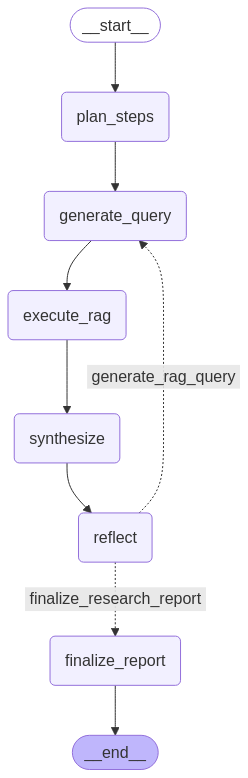

In [20]:
from IPython.display import Image, display

try:
    display(Image(deep_research_subgraph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
# test_deep_research.py

import asyncio
import json
import os
import logging
from dotenv import load_dotenv

# --- Environment and Logging Setup ---
load_dotenv()
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger("DeepResearchTest")

# --- Core Imports ---
from langchain_core.runnables import RunnableConfig

# --- Build the Subgraph ---
logger.info("Building the deep research subgraph...")
deep_research_subgraph = build_deep_research_subgraph()
logger.info("Subgraph built successfully.")

# --- Test Function ---
async def run_test():
    logger.info("--- Starting Deep Research Subgraph Test ---")

    # 1. Define Initial Input State
    initial_input: DeepFitnessResearchState = {
        "research_topic": "Effective training frequency and volume for natural lifters aiming for hypertrophy with 3-4 gym sessions per week.",
        "user_profile_str": json.dumps({
            "name": "Test User",
            "age": 30,
            "goals": ["muscle hypertrophy", "strength"],
            "fitness_level": "intermediate",
            "constraints": ["time-limited (3-4 sessions/week)", "natural lifter"],
            "available_equipment": ["standard gym equipment"]
        }),
        # Initialize internal state fields
        "sub_questions": None, "current_sub_question_idx": 0, "current_rag_query": None,
        "rag_results": None, "accumulated_findings": "", "reflections": [],
        "iteration_count": 0, "research_complete": False, "queries_this_sub_question": 0,
        "sub_question_complete_flag": False, "final_report": None, "max_iterations": 0,
        "max_queries_per_sub_question": 0,
    }
    logger.info(f"Initial Input State (Partial): { {k: v for k, v in initial_input.items() if k in ['research_topic']} }")

    # 2. Define Configuration
    config: RunnableConfig = {
        "configurable": {
            "max_iterations": 6,
            "max_queries_per_sub_question": 2,
        },
        "recursion_limit": 50 # Use the increased limit
    }
    logger.info(f"Runnable Config: {config['configurable']} | Recursion Limit: {config['recursion_limit']}")

    # --- Run Streaming and Capture Final Report ---
    logger.info("\n--- Starting Subgraph Streaming Test ---")
    print("\n" + "="*30 + " STREAMING OUTPUT " + "="*28)
    final_report_content = "Report not generated or captured." # Default message
    last_state_snapshot = {} # To hold the state at the end of the stream
    try:
        async for event in deep_research_subgraph.astream(initial_input, config=config):
            # Capture the last complete state snapshot if available
            # (Structure might vary slightly depending on LangGraph version)
            if "__end__" in event: # Check for the typical end marker
                 last_state_snapshot = event["__end__"]


            if isinstance(event, dict) and len(event) == 1:
                 node_name = list(event.keys())[0]
                 node_output = event[node_name]

                 if isinstance(node_output, dict):
                    print(f"\n--- Event from Node: {node_name} ---")
                    # ... (print other node outputs as before) ...
                    if 'final_report' in node_output:
                        print(f"  Final Report Generated (Length: {len(node_output['final_report'])})")
                        # *** CAPTURE THE REPORT ***
                        final_report_content = node_output['final_report']
                 else:
                     print(f"\n--- Event from Node: {node_name} (Non-dict output) ---")
                     print(f"  Output: {node_output}")
            else:
                 # Capture final state if event structure is different
                 last_state_snapshot = event
                 print(f"\n--- Final Streaming Event ---")
                 print(event)

        print("\n" + "="*75)
        logger.info("--- Subgraph Streaming Complete ---")

        # --- Print Captured Report ---
        print("\n" + "="*30 + " CAPTURED FINAL REPORT " + "="*25)
        print(final_report_content)
        print("="*75)

        # --- Optional: Print last state snapshot for inspection ---
        # print("\n" + "="*30 + " LAST STATE SNAPSHOT " + "="*26)
        # print(json.dumps(last_state_snapshot, indent=2, default=str)) # Use default=str for non-serializable items
        # print("="*75)


    except Exception as e:
        logger.error(f"Error during subgraph streaming: {e}", exc_info=True)
        print(f"\n!!! Error during subgraph streaming: {e} !!!")
        # Even if streaming errors, print what might have been captured
        print("\n" + "="*30 + " CAPTURED FINAL REPORT (Before Error) " + "="*15)
        print(final_report_content)
        print("="*75)


# --- Run the Test ---
if __name__ == "__main__":
    await run_test()

2025-03-30 19:49:54,018 - DeepResearchTest - INFO - Building the deep research subgraph...
2025-03-30 19:49:54,021 - DeepResearchTest - INFO - Deep research subgraph compiled successfully.
2025-03-30 19:49:54,022 - DeepResearchTest - INFO - Subgraph built successfully.
2025-03-30 19:49:54,023 - DeepResearchTest - INFO - --- Starting Deep Research Subgraph Test ---
2025-03-30 19:49:54,023 - DeepResearchTest - INFO - Initial Input State (Partial): {'research_topic': 'Effective training frequency and volume for natural lifters aiming for hypertrophy with 3-4 gym sessions per week.'}
2025-03-30 19:49:54,023 - DeepResearchTest - INFO - Runnable Config: {'max_iterations': 6, 'max_queries_per_sub_question': 2} | Recursion Limit: 50
2025-03-30 19:49:54,024 - DeepResearchTest - INFO - 
--- Starting Subgraph Streaming Test ---
2025-03-30 19:49:54,033 - DeepResearchTest - INFO - --- Deep Research: Planning Steps ---



============================== STREAMING OUTPUT ============================


2025-03-30 19:49:56,282 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:49:56,296 - DeepResearchTest - INFO - Planned sub-questions: ['What is the recommended training frequency per muscle group for natural lifters aiming for hypertrophy with 3-4 sessions per week?', 'How should training volume be distributed across sessions to maximize muscle growth for an intermediate lifter?', 'What are the most effective compound exercises for muscle hypertrophy using standard gym equipment?', 'How can progression be effectively managed in a time-limited training schedule to ensure continuous muscle growth?', 'What role does nutrition timing play in optimizing recovery and muscle protein synthesis for natural lifters?']
2025-03-30 19:49:56,301 - DeepResearchTest - INFO - --- Deep Research: Generating RAG Query (v2) ---



--- Event from Node: plan_steps ---


2025-03-30 19:49:57,305 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:49:57,312 - DeepResearchTest - INFO - Generated RAG query: "optimal training frequency per muscle group for hypertrophy in natural lifters with 3-4 weekly sessions"
2025-03-30 19:49:57,318 - DeepResearchTest - INFO - --- Deep Research: Executing RAG Query ---
2025-03-30 19:49:57,318 - agent.utils - INFO - RAG query: "optimal training frequency per muscle group for hypertrophy in natural lifters with 3-4 weekly sessions"



--- Event from Node: generate_query ---


2025-03-30 19:49:58,172 - agent.utils - INFO - Generated query embedding: [0.0034859718289226294, 0.03886004909873009, 0.02617236226797104, 0.01465822197496891, -0.02486317977309227]... (truncated)
2025-03-30 19:49:58,372 - agent.utils - INFO - Pinecone query results: {'matches': [{'id': 'X82vvocqe-8_0',
              'metadata': {'text': 'foreign to the house of hypertrophy a '
                                   'brand new study comparing training in '
                                   'muscle once a week to three times per week '
                                   'for hypertrophy and strength has come out '
                                   'in my view its the single best designed '
                                   'study on training frequency to date '
                                   'primarily as it provides individual data '
                                   'allowing us to know if the best training '
                                   'frequency differs between individua


--- Event from Node: execute_rag ---


2025-03-30 19:50:01,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:01,853 - DeepResearchTest - INFO - --- Deep Research: Reflecting on Progress (v2) ---



--- Event from Node: synthesize ---


2025-03-30 19:50:04,891 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:04,907 - DeepResearchTest - INFO - Reflection on 'What is the recommended training frequency per muscle group for natural lifters aiming for hypertrophy with 3-4 sessions per week?':
CONCLUSION: CONTINUE_SUB_QUESTION

Sufficiency: The findings provide a general overview of training frequency and volume for hypertrophy, but they do not specifically address the optimal distribution of sets across 3-4 sessions per week for natural lifters.

Gaps: The current findings lack specific guidance on how to effectively distribute the recommended 30-45 weekly sets per muscle group across 3-4 sessions. Details on how to balance intensity and recovery within this schedule are also missing.

Next Step: Perform another RAG query focusing on "optimal distribution of weekly sets per muscle group across 3-4 sessions for hypertrophy in natural lifters."
2025-03-30 19:50


--- Event from Node: reflect ---


2025-03-30 19:50:05,385 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:05,391 - DeepResearchTest - INFO - Generated RAG query: "optimal distribution of 30-45 weekly sets per muscle group across 3-4 sessions for hypertrophy in natural lifters"
2025-03-30 19:50:05,394 - DeepResearchTest - INFO - --- Deep Research: Executing RAG Query ---
2025-03-30 19:50:05,394 - agent.utils - INFO - RAG query: "optimal distribution of 30-45 weekly sets per muscle group across 3-4 sessions for hypertrophy in natural lifters"



--- Event from Node: generate_query ---


2025-03-30 19:50:06,070 - agent.utils - INFO - Generated query embedding: [-0.0009702761308290064, 0.02100333757698536, 0.013882896862924099, 0.007996094413101673, -0.02591620944440365]... (truncated)
2025-03-30 19:50:06,099 - agent.utils - INFO - Pinecone query results: {'matches': [{'id': 'MW99hv5M1Yg_48',
              'metadata': {'text': '. Nevertheless, returning to the 3 studies '
                                   'that found 1218 weekly sets to be '
                                   'sufficient or optimal for building muscle, '
                                   'and used longer rest intervals, we know '
                                   'that the highest set groups in these '
                                   'studies, performing 2428 weekly sets, '
                                   'distributed their sets across 2 days a '
                                   'week'},
              'score': 0.795421839,
              'values': []},
             {'id': 'MW99hv5M1Yg_17',
   


--- Event from Node: execute_rag ---


2025-03-30 19:50:10,210 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:10,291 - DeepResearchTest - INFO - --- Deep Research: Reflecting on Progress (v2) ---



--- Event from Node: synthesize ---


2025-03-30 19:50:13,229 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:13,242 - DeepResearchTest - INFO - Reflection on 'What is the recommended training frequency per muscle group for natural lifters aiming for hypertrophy with 3-4 sessions per week?':
CONCLUSION: SUB_QUESTION_COMPLETE

Sufficiency: Yes, the findings cover the core aspects of the sub-question adequately. The research indicates that distributing 30-45 weekly sets per muscle group over two to three days each week is effective for hypertrophy, which aligns with the user's constraints of 3-4 sessions per week. This approach also accommodates longer rest intervals, which are beneficial for muscle growth.

Gaps: Minor details such as specific exercise selection or variations for different muscle groups could be explored further, but these are not critical to the core question of training frequency.

Next Step: Conclude this sub-question.
2025-03-30 19:50:13,


--- Event from Node: reflect ---


2025-03-30 19:50:13,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:13,893 - DeepResearchTest - INFO - Generated RAG query: "optimal distribution of 30-45 weekly sets per muscle group across 3-4 sessions for hypertrophy in intermediate natural lifters, considering intensity and recovery"
2025-03-30 19:50:13,906 - DeepResearchTest - INFO - --- Deep Research: Executing RAG Query ---
2025-03-30 19:50:13,906 - agent.utils - INFO - RAG query: "optimal distribution of 30-45 weekly sets per muscle group across 3-4 sessions for hypertrophy in intermediate natural lifters, considering intensity and recovery"



--- Event from Node: generate_query ---


2025-03-30 19:50:14,548 - agent.utils - INFO - Generated query embedding: [-0.00967651978135109, 0.008315548300743103, 0.0207944568246603, 0.006487550679594278, -0.02843092940747738]... (truncated)
2025-03-30 19:50:14,605 - agent.utils - INFO - Pinecone query results: {'matches': [{'id': 'MW99hv5M1Yg_48',
              'metadata': {'text': '. Nevertheless, returning to the 3 studies '
                                   'that found 1218 weekly sets to be '
                                   'sufficient or optimal for building muscle, '
                                   'and used longer rest intervals, we know '
                                   'that the highest set groups in these '
                                   'studies, performing 2428 weekly sets, '
                                   'distributed their sets across 2 days a '
                                   'week'},
              'score': 0.797412157,
              'values': []},
             {'id': 'MW99hv5M1Yg_17',
      


--- Event from Node: execute_rag ---


2025-03-30 19:50:20,453 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:20,476 - DeepResearchTest - INFO - --- Deep Research: Reflecting on Progress (v2) ---



--- Event from Node: synthesize ---


2025-03-30 19:50:22,397 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:22,404 - DeepResearchTest - INFO - Reflection on 'How should training volume be distributed across sessions to maximize muscle growth for an intermediate lifter?':
CONCLUSION: SUB_QUESTION_COMPLETE

Sufficiency: Yes, the findings cover the core aspects of how training volume should be distributed across sessions to maximize muscle growth for an intermediate lifter. The recommendation to distribute 30-45 weekly sets per muscle group over 3-4 sessions is well-supported by the evidence provided, considering the user's constraints and goals.

Gaps: Minor details such as specific exercise selection, intensity levels, and individual variability could be explored further, but these are not critical to the core question of volume distribution.

Next Step: Conclude this sub-question.
2025-03-30 19:50:22,410 - DeepResearchTest - INFO - --- Deep Research: Routi


--- Event from Node: reflect ---


2025-03-30 19:50:22,905 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:22,913 - DeepResearchTest - INFO - Generated RAG query: "effective compound exercises for muscle hypertrophy using standard gym equipment"
2025-03-30 19:50:22,918 - DeepResearchTest - INFO - --- Deep Research: Executing RAG Query ---
2025-03-30 19:50:22,919 - agent.utils - INFO - RAG query: "effective compound exercises for muscle hypertrophy using standard gym equipment"



--- Event from Node: generate_query ---


2025-03-30 19:50:23,339 - agent.utils - INFO - Generated query embedding: [0.03374633938074112, -0.037446390837430954, 0.03718738257884979, -0.0031440972816199064, -0.016379214823246002]... (truncated)
2025-03-30 19:50:23,378 - agent.utils - INFO - Pinecone query results: {'matches': [{'id': 'Qtm1yCpjiPM_10',
              'metadata': {'text': '. contains improbable and atypical data. '
                                   'The data in these studies cannot be '
                                   'trusted, perhaps because the data is '
                                   'illegitimate. Thus, I believe we cannot '
                                   'use these studies as additional evidence. '
                                   'Hello There. Youre killing your gains. So '
                                   'its clear some researchers speculate '
                                   'compound exercises may indeed max '
                                   'hypertrophy'},
              'score': 0.


--- Event from Node: execute_rag ---


2025-03-30 19:50:29,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:29,889 - DeepResearchTest - INFO - --- Deep Research: Reflecting on Progress (v2) ---



--- Event from Node: synthesize ---


2025-03-30 19:50:34,752 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:34,760 - DeepResearchTest - INFO - Reflection on 'What are the most effective compound exercises for muscle hypertrophy using standard gym equipment?':
CONCLUSION: CONTINUE_SUB_QUESTION

Sufficiency: The findings provide a general overview of effective compound exercises for muscle hypertrophy, specifically mentioning back squats and conventional deadlifts. However, the information is somewhat limited and does not comprehensively cover a range of compound exercises that could be beneficial for muscle hypertrophy using standard gym equipment.

Gaps: The current findings lack a detailed list of compound exercises beyond back squats and deadlifts. There is no mention of other effective compound exercises such as bench press, overhead press, bent-over rows, or pull-ups, which are also commonly recommended for hypertrophy. Additionally, there is no discus


--- Event from Node: reflect ---


2025-03-30 19:50:35,368 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:35,372 - DeepResearchTest - INFO - Generated RAG query: "comprehensive list of effective compound exercises for muscle hypertrophy using standard gym equipment"
2025-03-30 19:50:35,375 - DeepResearchTest - INFO - --- Deep Research: Executing RAG Query ---
2025-03-30 19:50:35,375 - agent.utils - INFO - RAG query: "comprehensive list of effective compound exercises for muscle hypertrophy using standard gym equipment"



--- Event from Node: generate_query ---


2025-03-30 19:50:35,764 - agent.utils - INFO - Generated query embedding: [0.03452940285205841, -0.03427732363343239, 0.0298774354159832, 0.007605479098856449, 0.0010943671222776175]... (truncated)
2025-03-30 19:50:35,804 - agent.utils - INFO - Pinecone query results: {'matches': [{'id': 'JVyLnLWpbxE_26',
              'metadata': {'text': '. As a final point, I should emphasize '
                                   'that by no means am I saying every single '
                                   'exercise in existence is optimal for '
                                   'building muscle. Unquestionably there '
                                   'exist factors that would result in certain '
                                   'exercises being more favorable for '
                                   'hypertrophy. Its just that even with these '
                                   'factors in mind, a whole host of exercises '
                                   'are still highly effective for '



--- Event from Node: execute_rag ---


2025-03-30 19:50:42,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:42,180 - DeepResearchTest - INFO - --- Deep Research: Reflecting on Progress (v2) ---



--- Event from Node: synthesize ---


2025-03-30 19:50:45,698 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:45,706 - DeepResearchTest - INFO - Reflection on 'What are the most effective compound exercises for muscle hypertrophy using standard gym equipment?':
CONCLUSION: SUB_QUESTION_COMPLETE

Sufficiency: Yes, the findings cover the core aspects adequately. The research has identified key compound exercises such as back squats and conventional deadlifts as highly effective for muscle hypertrophy using standard gym equipment. Additionally, the findings support the inclusion of both free weights and machine exercises, providing a comprehensive approach to selecting exercises for hypertrophy.

Gaps: Minor details such as specific variations of compound exercises or additional exercises could be explored, but these are not critical to the core understanding of effective compound exercises for hypertrophy.

Next Step: Conclude this sub-question.
2025-03-30 19:


--- Event from Node: reflect ---


2025-03-30 19:50:46,371 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:46,379 - DeepResearchTest - INFO - Generated RAG query: "strategies for managing progression in time-limited training schedules to ensure continuous muscle growth"
2025-03-30 19:50:46,384 - DeepResearchTest - INFO - --- Deep Research: Executing RAG Query ---
2025-03-30 19:50:46,385 - agent.utils - INFO - RAG query: "strategies for managing progression in time-limited training schedules to ensure continuous muscle growth"
2025-03-30 19:50:46,469 - agent.utils - INFO - Generated query embedding: [0.050048455595970154, 0.05654877424240112, 0.032250866293907166, -0.02462334744632244, -0.0006319170352071524]... (truncated)
2025-03-30 19:50:46,496 - agent.utils - INFO - Pinecone query results: {'matches': [{'id': 'y6Eg3tOHfM4_6',
              'metadata': {'text': 'University of Tokyo does provide some '
                                   'insight the rese


--- Event from Node: generate_query ---

--- Event from Node: execute_rag ---


2025-03-30 19:50:53,935 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:53,944 - DeepResearchTest - INFO - --- Deep Research: Reflecting on Progress (v2) ---



--- Event from Node: synthesize ---


2025-03-30 19:50:59,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:50:59,411 - DeepResearchTest - INFO - Reflection on 'How can progression be effectively managed in a time-limited training schedule to ensure continuous muscle growth?':
CONCLUSION: CONTINUE_SUB_QUESTION

Sufficiency: The findings provide a solid foundation for understanding how to manage progression in a time-limited training schedule, particularly in terms of weekly set distribution and exercise selection. However, they do not fully address specific strategies for progression management, such as how to adjust intensity, volume, or exercise selection over time to ensure continuous muscle growth.

Gaps: The findings lack detailed strategies on how to progressively overload within the constraints of a time-limited schedule. Information on periodization techniques, progression models (e.g., linear, undulating), and how to incorporate deload weeks or adjus


--- Event from Node: reflect ---


2025-03-30 19:51:08,580 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-30 19:51:08,599 - DeepResearchTest - INFO - Generated final research report.
2025-03-30 19:51:08,603 - DeepResearchTest - INFO - --- Subgraph Streaming Complete ---



--- Event from Node: finalize_report ---
  Final Report Generated (Length: 3686)


============================== CAPTURED FINAL REPORT =========================
**Research Report: Effective Training Frequency and Volume for Natural Lifters Aiming for Hypertrophy with 3-4 Gym Sessions per Week**

**Introduction**

This report explores the optimal training frequency and volume for natural lifters aiming for muscle hypertrophy within a time-limited schedule of 3-4 gym sessions per week. The focus is on intermediate lifters using standard gym equipment, with an emphasis on effective exercise selection, progression management, and the role of nutrition timing in optimizing recovery and muscle growth.

**Training Frequency and Volume**

Recent studies indicate that no specific training frequency per week is superior for muscle hypertrophy, allowing for flexibility in scheduling. For intermediate lifters, evidence suggests that performing between 30-45 weekly sets per muscle group is benefi

In [20]:
initial_input['final_report']

NameError: name 'initial_input' is not defined

# Exercise Templates Union

In [21]:
import json
from pathlib import Path

# List of JSON file paths
json_files = [
    'page1.json',
    'page2.json', 
    'page3.json',
    'page4.json',
    'page5.json'
]

# Initialize combined list
combined_exercise_templates = []

# Process each file
for file_path in json_files:
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            if 'exercise_templates' in data:
                combined_exercise_templates.extend(data['exercise_templates'])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Create output dictionary
output_data = {
    'exercise_templates': combined_exercise_templates,
    'total_exercises': len(combined_exercise_templates)
}

# Write combined data to new JSON file
output_path = 'combined_exercise_templates.json'
with open(output_path, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"Successfully combined exercise templates from {len(json_files)} files into {output_path}")


Successfully combined exercise templates from 5 files into combined_exercise_templates.json


In [1]:
import json
# Load the combined exercise templates
with open('combined_exercise_templates.json', 'r') as f:
    data = json.load(f)

# Extract exercise templates
exercises = data['exercise_templates']

# Print basic info
print(f"Total exercises: {data['total_exercises']}\n")

# Analyze unique values for each field
fields_to_analyze = ['title', 'type', 'primary_muscle_group', 'equipment', 'is_custom']

for field in fields_to_analyze:
    unique_values = set(ex[field] for ex in exercises)
    print(f"Unique {field}s ({len(unique_values)}):")
    
    # For boolean fields, just show the possible values
    if field == 'is_custom':
        print(f"  Possible values: {unique_values}")
    else:
        # For other fields, show first 5 unique values as sample
        sample_values = list(unique_values)[:5]
        print(f"  Sample values: {sample_values}")
    
    print()

# Additional analysis - count exercises by primary muscle group
muscle_group_counts = {}
for ex in exercises:
    group = ex['primary_muscle_group']
    muscle_group_counts[group] = muscle_group_counts.get(group, 0) + 1

print("\nExercise count by primary muscle group:")
for group, count in sorted(muscle_group_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {group}: {count} exercises")

# Additional analysis - most common equipment types
equipment_counts = {}
for ex in exercises:
    equip = ex['equipment']
    equipment_counts[equip] = equipment_counts.get(equip, 0) + 1

print("\nExercise count by equipment type:")
for equip, count in sorted(equipment_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {equip}: {count} exercises")


Total exercises: 416

Unique titles (416):
  Sample values: ['Behind the Back Bicep Wrist Curl (Barbell)', 'Climbing', 'Reverse Plank', 'Standing Cable Glute Kickbacks', 'Pilates']

Unique types (9):
  Sample values: ['weight_reps', 'distance_duration', 'bodyweight_weighted', 'bodyweight_assisted', 'steps_duration']

Unique primary_muscle_groups (20):
  Sample values: ['hamstrings', 'biceps', 'abductors', 'triceps', 'shoulders']

Unique equipments (9):
  Sample values: ['suspension', 'machine', 'other', 'resistance_band', 'kettlebell']

Unique is_customs (2):
  Possible values: {False, True}


Exercise count by primary muscle group:
  quadriceps: 50 exercises
  abdominals: 48 exercises
  chest: 47 exercises
  full_body: 41 exercises
  shoulders: 32 exercises
  biceps: 30 exercises
  upper_back: 27 exercises
  triceps: 26 exercises
  cardio: 22 exercises
  lats: 22 exercises
  glutes: 19 exercises
  hamstrings: 18 exercises
  calves: 12 exercises
  traps: 6 exercises
  lower_back: 5 exe

In [2]:
# Connect to database and create session
from sqlalchemy.orm import Session
from models import ExerciseTemplate, SessionLocal

# Create database session
db = SessionLocal()

try:
    # Iterate through exercises and create ExerciseTemplate objects
    for ex in exercises:
        exercise = ExerciseTemplate(
            id=ex['id'],
            title=ex['title'],
            type=ex['type'],
            equipment=ex['equipment'],
            primary_muscle_group=ex['primary_muscle_group'],
            secondary_muscle_groups=ex.get('secondary_muscle_groups', []),
            is_custom=ex['is_custom']
        )
        db.add(exercise)
    
    # Commit all exercises to database
    db.commit()
    print(f"Successfully added {len(exercises)} exercises to database")
except Exception as e:
    db.rollback()
    print(f"Error adding exercises: {e}")
finally:
    db.close()


Successfully added 416 exercises to database


/Users/pranavtandra/Desktop/PersonalTrainerAI/venv/lib/python3.9/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'orm_mode' has been renamed to 'from_attributes'
  warnings.warn(message, UserWarning)


Okay, I understand the problem perfectly. The core issue is the impedance mismatch:

Planner Agent: Thinks conceptually about exercises (e.g., "Barbell Bench Press").

Hevy API Tool (tool_create_routine): Requires a precise exercise_template_id for each exercise.

Your current planner tries to directly output the format needed by the tool, but it lacks the necessary exercise_template_id.

Here's a revised approach to fix the planning agent and achieve your initial vision, incorporating the exercise template lookup:

Revised Strategy: Two-Step Planning & Formatting

Instead of having the planner directly try to generate the final Hevy API payload, we'll break it down:

Planning Agent (Conceptual Plan): The planner focuses on its core strength: designing the structure of the workout (exercises by name, sets, reps, rest, notes, progression logic) based on the user profile and research. Its output will be a structured representation of this plan, but using exercise names.

Formatting & ID Lookup Step (New): A separate, deterministic step (either a new agent node or a helper function called after the planner) takes the conceptual plan from the planner. It then uses your PostgreSQL database (or JSON file) to look up the exercise_template_id for each exercise name provided by the planner. It then constructs the final, precise JSON payload required by the tool_create_routine.

Hevy Tool Invocation: This step remains the same, but it receives the correctly formatted payload (with IDs) from the Formatting & ID Lookup step.

Implementation Steps:

Step 1: Modify the Planning Agent and Prompt

Goal: Get a structured plan using exact Hevy exercise names.

Revise PLANNING_TEMPLATE:

Remove the Pydantic class examples, as they imply the planner needs to know the final structure with IDs, which it doesn't yet.

Explicitly instruct the planner to use the exact titles of exercises as found in the Hevy app's standard library. You might provide a few examples of correct titles if helpful, but not the whole list.

Instruct the planner to output a structured format (like JSON or a very clear markdown list) that includes:

Routine Title

Routine Notes

A list of exercises, each with:

exercise_name: The exact title from Hevy (e.g., "Bench Press (Barbell)").

sets: A list of sets, each specifying type (normal, warmup, dropset), reps, and potentially weight_kg (or guidance like RPE/percentage).

rest_seconds: Rest time after this exercise.

notes: Any specific notes for this exercise.

superset_group: An identifier (e.g., 'A', 'B', or 1, 2) if the exercise is part of a superset, linking it with other exercises in the same group. null or absent if not part of a superset.

Revised PLANNING_TEMPLATE Example:
```python
PLANNING_TEMPLATE = """You are an expert workout programming specialist using evidence-based principles. Your task is to create a detailed, personalized workout routine based on the provided user profile and research findings.

**User Profile:**
{{user_profile}}

**Research Findings:**
{{research_findings}}

**Instructions:**

1.  **Design the Routine:** Create a structured workout plan including specific exercises, the number of sets for each, the target repetitions (reps) per set, and rest periods (in seconds) between exercises. Specify set types (e.g., 'warmup', 'normal', 'dropset') where appropriate (default is 'normal').
2.  **Use Exact Exercise Names:** You **MUST** use the precise, official 'title' for each exercise as found in the Hevy application's standard exercise library. For example, use "Bench Press (Barbell)", "Lat Pulldown (Cable)", "Squat (Barbell)", etc. Do NOT invent exercises or use variations unless you are certain they exist with that exact name in Hevy.
3.  **Specify Supersets:** If exercises should be performed as a superset, assign them the same `superset_group` identifier (e.g., "A", "B", or 1, 2). Exercises not in a superset should have no `superset_group`.
4.  **Weight Guidance:** Provide guidance on weight selection if possible (e.g., target RPE, %1RM, or a starting weight recommendation based on profile). If specific weights are required, provide `weight_kg`.
5.  **Output Format:** Structure your response as a JSON object containing the following keys:
    *   `title`: A descriptive title for the workout routine.
    *   `notes`: General notes or instructions for the routine.
    *   `exercises`: A list of exercise objects, where each object has:
        *   `exercise_name`: The exact Hevy exercise title (string).
        *   `sets`: A list of set objects, each with `type` (string, default 'normal'), `reps` (integer), and optionally `weight_kg` (float).
        *   `rest_seconds`: Rest time in seconds after this exercise (integer).
        *   `notes`: Specific notes for the exercise (string).
        *   `superset_group`: An optional identifier (string or integer) for grouping supersets.

**Example Output Structure (Conceptual Plan):**

```json
{{
  "title": "Full Body Strength A",
  "notes": "Focus on controlled movements. Aim for RPE 8 on working sets.",
  "exercises": [
    {{
      "exercise_name": "Squat (Barbell)",
      "sets": [
        {{"type": "warmup", "reps": 8, "weight_kg": 40.0}},
        {{"type": "normal", "reps": 5, "weight_kg": 80.0}},
        {{"type": "normal", "reps": 5, "weight_kg": 80.0}},
        {{"type": "normal", "reps": 5, "weight_kg": 80.0}}
      ],
      "rest_seconds": 120,
      "notes": "Keep back straight, go below parallel.",
      "superset_group": None
    }},
    {{
      "exercise_name": "Bench Press (Barbell)",
      "sets": [
        {{"type": "warmup", "reps": 8, "weight_kg": 30.0}},
        {{"type": "normal", "reps": 6, "weight_kg": 60.0}},
        {{"type": "normal", "reps": 6, "weight_kg": 60.0}},
        {{"type": "normal", "reps": 6, "weight_kg": 60.0}}
      ],
      "rest_seconds": 90,
      "notes": "Touch chest lightly, elbows slightly tucked.",
      "superset_group": None
    }},
    {{
      "exercise_name": "Pull Up",
      "sets": [
        {{"type": "normal", "reps": 8}},
        {{"type": "normal", "reps": 8}},
        {{"type": "normal", "reps": 7}}
      ],
      "rest_seconds": 0,
      "notes": "Use assist if needed.",
      "superset_group": "A"
    }},
    {{
      "exercise_name": "Dip",
      "sets": [
        {{"type": "normal", "reps": 10}},
        {{"type": "normal", "reps": 10}},
        {{"type": "normal", "reps": 9}}
      ],
      "rest_seconds": 90,
      "notes": "Focus on chest activation.",
      "superset_group": "A"
    }}
    // ... more exercises
  ]
}}


Generate the workout plan now based on the user profile and research findings.
"""
```

*   **Update `planning_agent` function:**
    *   It should still invoke the LLM with the revised prompt.
    *   It should parse the LLM response (ideally expecting JSON now).
    *   Store this *conceptual* plan (with names) in the state, perhaps under a key like `conceptual_fitness_plan`.
    *   Do *not* try to call `tool_create_routine` yet.

```python
import json
from typing import Dict, Any, List, Optional
# Assuming you have setup DB access functions (see Step 2)
# from .db_utils import get_exercise_template_by_title 
# Assuming AgentState is defined elsewhere
# from .state import AgentState 
# Assuming logger and llm are configured
# import logging

# Placeholder for DB access function (implement this separately)
async def get_exercise_template_by_title(title: str) -> Optional[Dict[str, Any]]:
    # This function needs to query your PostgreSQL DB or search your JSON
    # Example using a hypothetical DB session (adapt to your DB library):
    # async with get_db_session() as session:
    #     result = await session.execute(
    #         select(ExerciseTemplate).where(ExerciseTemplate.title == title)
    #     )
    #     template = result.scalars().first()
    #     if template:
    #         return {
    #             "id": template.id, 
    #             "title": template.title, 
    #             # include other fields if needed later
    #         }
    # return None
    
    # --- OR --- Example using a loaded JSON file (less efficient for many lookups)
    # global exercise_data_list # Assume this is loaded once at startup
    # for exercise in exercise_data_list:
    #     if exercise.get('title') == title:
    #         return {"id": exercise.get("id"), "title": exercise.get("title")}
    # return None
    
    # Simulated response for now:
    print(f"DB Lookup (Simulated): Searching for title='{title}'")
    mock_db = {
        "Squat (Barbell)": {"id": "SOME_SQUAT_ID", "title": "Squat (Barbell)"},
        "Bench Press (Barbell)": {"id": "SOME_BENCH_ID", "title": "Bench Press (Barbell)"},
        "Pull Up": {"id": "SOME_PULLUP_ID", "title": "Pull Up"},
        "Dip": {"id": "SOME_DIP_ID", "title": "Dip"},
        "Leg Press Horizontal (Machine)": {"id": "0EB695C9", "title": "Leg Press Horizontal (Machine)"},
        "Seated Leg Curl (Machine)": {"id": "11A123F3", "title": "Seated Leg Curl (Machine)"},
         # Add more mappings as needed for testing
    }
    await asyncio.sleep(0.05) # Simulate async DB call
    return mock_db.get(title)



# --- Planning Agent ---
async def planning_agent(state: AgentState) -> AgentState:
    """Designs a conceptual workout plan using exercise names."""
    logger.info("Planning Agent - Step 1: Designing Conceptual Plan")

    planning_prompt = get_planning_prompt() # Use the revised template above

    # Prepare prompt inputs
    user_profile_str = json.dumps(state.get("user_model", {}), indent=2)
    research_findings_str = json.dumps(state.get("working_memory", {}).get("research_findings", {}), indent=2)
    
    filled_prompt = planning_prompt.format(
        user_profile=user_profile_str,
        research_findings=research_findings_str
    )

    messages = state["messages"] + [SystemMessage(content=filled_prompt)]
    
    logger.info("Invoking LLM for conceptual plan...")
    response = await llm.ainvoke(messages)
    logger.info(f"\033[91m PLANNER's Conceptual Response: {response.content} \033[0m")

    try:
        # Attempt to parse the conceptual plan (assuming JSON output)
        # Add robust error handling for JSON parsing
        conceptual_plan_dict = json.loads(response.content)
        
        # Store the conceptual plan in the state
        updated_state = {
            **state,
            "messages": state["messages"] + [AIMessage(content=f"Conceptual Plan Generated:\n```json\n{json.dumps(conceptual_plan_dict, indent=2)}\n```")],
            "conceptual_fitness_plan": conceptual_plan_dict # New state key
        }
        logger.info("Planning Agent - Conceptual plan created successfully.")
        return updated_state

    except json.JSONDecodeError as e:
        error_message = f"Error: Planner did not return valid JSON. Response:\n{response.content}"
        logger.error(error_message, exc_info=True)
        # Handle error - maybe add error message to state, retry, or halt
        updated_state = {
            **state,
            "messages": state["messages"] + [
                AIMessage(content=response.content), # Show original response
                AIMessage(content=f"⚠️ Error: Failed to parse the conceptual plan from the planner. {e}")
            ],
            "conceptual_fitness_plan": None # Indicate failure
        }
        return updated_state
    except Exception as e:
        error_message = f"An unexpected error occurred in the planning agent: {str(e)}"
        logger.error(error_message, exc_info=True)
        # Handle generic error
        updated_state = {
            **state,
            "messages": state["messages"] + [
                AIMessage(content=response.content), # Show original response
                AIMessage(content=f"⚠️ Error: An unexpected error occurred during planning: {e}")
            ],
            "conceptual_fitness_plan": None # Indicate failure
        }
        return updated_state
```

Step 2: Create the Formatting & ID Lookup Function/Node

Goal: Convert the conceptual plan (with names) into the Hevy API format (with IDs).

Functionality:

Takes the conceptual_fitness_plan from the state.

Iterates through the exercises list in the conceptual plan.

For each exercise, calls a helper function (get_exercise_template_by_title) to query your PostgreSQL database (or search the JSON) using the exercise_name.

Handles cases where the exercise name is not found (log error, add message to user, potentially halt).

Constructs the ExerciseRoutineCreate objects using the retrieved exercise_template_id.

Handles supersets: Assigns unique string superset_ids (e.g., "0", "1", "2"...) based on the superset_group identifier from the conceptual plan. Exercises in the same group get the same superset_id.

Builds the final RoutineCreate object.

Stores this final, Hevy-ready payload in the state, perhaps as hevy_routine_payload.

```python
import asyncio
# Assume Pydantic models (SetRoutineCreate, ExerciseRoutineCreate, RoutineCreate) are defined
# from .models import SetRoutineCreate, ExerciseRoutineCreate, RoutineCreate 

# --- Formatting and ID Lookup Function/Node ---
async def format_routine_for_hevy(state: AgentState) -> AgentState:
    """Looks up exercise IDs and formats the plan for the Hevy API tool."""
    logger.info("Formatting Agent - Step 2: Looking up IDs and Formatting for Hevy")
    
    conceptual_plan = state.get("conceptual_fitness_plan")
    
    if not conceptual_plan or not isinstance(conceptual_plan, dict):
        logger.error("Formatting Agent - Error: Conceptual plan not found or invalid in state.")
        # Return state with error message
        return {
            **state,
            "messages": state["messages"] + [AIMessage(content="⚠️ Error: Conceptual plan is missing. Cannot format for Hevy.")],
            "hevy_routine_payload": None 
        }

    hevy_exercises = []
    errors = []
    superset_mapping = {} # Maps conceptual group identifier to Hevy superset_id (string)
    next_superset_id_numeric = 0

    for i, conceptual_ex in enumerate(conceptual_plan.get("exercises", [])):
        exercise_name = conceptual_ex.get("exercise_name")
        if not exercise_name:
            errors.append(f"Exercise at index {i} is missing 'exercise_name'.")
            continue

        # --- Lookup Exercise ID ---
        template_info = await get_exercise_template_by_title(exercise_name)
        
        if not template_info or not template_info.get("id"):
            errors.append(f"Exercise '{exercise_name}' not found in Hevy exercise database. Cannot add to routine.")
            logger.warning(f"Hevy exercise template not found for title: '{exercise_name}'")
            continue # Skip this exercise

        exercise_template_id = template_info["id"]
        
        # --- Handle Sets ---
        hevy_sets = []
        for j, conceptual_set in enumerate(conceptual_ex.get("sets", [])):
            try:
                hevy_sets.append(SetRoutineCreate(
                    type=conceptual_set.get("type", "normal"),
                    # Provide default 0 if weight/reps missing, or make required in Pydantic
                    weight_kg=float(conceptual_set.get("weight_kg", 0.0)), 
                    reps=int(conceptual_set.get("reps", 0)),
                    # Add distance/duration if your conceptual plan includes them
                    distance_meters=conceptual_set.get("distance_meters"), 
                    duration_seconds=conceptual_set.get("duration_seconds") 
                ))
            except (ValueError, TypeError) as e:
                 errors.append(f"Invalid set data for '{exercise_name}', set {j+1}: {e}. Set: {conceptual_set}")
                 # Decide if you want to skip the set or the whole exercise
                 continue # Skipping this set for now

        if not hevy_sets and conceptual_ex.get("sets"):
             logger.warning(f"No valid sets could be created for exercise '{exercise_name}'. Skipping exercise.")
             continue # Skip exercise if no valid sets were created


        # --- Handle Supersets ---
        conceptual_superset_group = conceptual_ex.get("superset_group")
        hevy_superset_id = None
        if conceptual_superset_group is not None:
            group_key = str(conceptual_superset_group) # Ensure consistent key type
            if group_key not in superset_mapping:
                 # Assign the next available numeric ID as a string
                 superset_mapping[group_key] = str(next_superset_id_numeric)
                 next_superset_id_numeric += 1
            hevy_superset_id = superset_mapping[group_key]

        # --- Create Hevy Exercise Object ---
        hevy_exercises.append(ExerciseRoutineCreate(
            exercise_template_id=exercise_template_id,
            superset_id=hevy_superset_id, # Assign the looked-up/generated string ID
            rest_seconds=int(conceptual_ex.get("rest_seconds", 60)), # Default rest
            notes=conceptual_ex.get("notes", ""), # Use notes from conceptual plan
            sets=hevy_sets
        ))

    # --- Construct Final Routine Payload ---
    if not hevy_exercises and conceptual_plan.get("exercises"):
         errors.append("No valid exercises could be added to the routine after processing.")

    hevy_routine_payload = None
    if not errors and hevy_exercises:
        try:
            final_routine = RoutineCreate(
                title=conceptual_plan.get("title", "AI Generated Routine"),
                notes=conceptual_plan.get("notes", "Generated by AI Agent"),
                exercises=hevy_exercises,
                folder_id=None # Or get from state/config if needed
            )
            # Prepare the structure expected by the tool (wrapper dict)
            hevy_routine_payload = {"routine_data": final_routine.dict()} 
            logger.info("Formatting Agent - Successfully formatted routine for Hevy API.")
            
        except Exception as e: # Catch potential Pydantic validation errors
             errors.append(f"Failed to create final routine structure: {e}")
             logger.error(f"Error creating final RoutineCreate object: {e}", exc_info=True)

    # --- Update State ---
    final_messages = state["messages"]
    if errors:
        error_summary = "Found errors during formatting:\n- " + "\n- ".join(errors)
        final_messages = final_messages + [AIMessage(content=f"⚠️ {error_summary}")]
        logger.error(f"Formatting Agent - Errors encountered: {errors}")
        # Optionally clear the payload if errors occurred
        hevy_routine_payload = None 
        
    if hevy_routine_payload:
         final_messages = final_messages + [AIMessage(content=f"Plan formatted for Hevy:\n```json\n{json.dumps(hevy_routine_payload, indent=2)}\n```")]


    updated_state = {
        **state,
        "messages": final_messages,
        "hevy_routine_payload": hevy_routine_payload # Store the final payload or None
    }
    return updated_state
```

Step 3: Update Agent Workflow (Graph)

You need to modify your agent's control flow (e.g., in LangGraph) so that format_routine_for_hevy runs after planning_agent and before the step that calls tool_create_routine.

Workflow: ... -> planning_agent -> format_routine_for_hevy -> (Conditional Edge: if hevy_routine_payload exists) -> call_hevy_tool_node -> ...

The node that calls tool_create_routine should now take state["hevy_routine_payload"] as its input.

Step 4: Implement Database/JSON Lookup

Create the get_exercise_template_by_title async function.

Use your preferred library (asyncpg, SQLAlchemy asyncio, or simply load the JSON into memory if it's small enough and access is infrequent) to perform the lookup based on the title field.

Make sure this lookup is efficient, especially if you use the database (add an index on the title column).

Advantages of this Approach:

Clear Separation of Concerns: The LLM planner focuses on high-level planning, while deterministic code handles the precise data lookup and formatting.

Robustness: Less prone to LLM hallucinations regarding IDs. Errors in exercise naming are caught before calling the API.

Maintainability: Easier to update the exercise list (just update the DB/JSON) without changing the planner prompt significantly.

Flexibility: The conceptual plan can be used for other purposes besides just Hevy export (e.g., displaying in a UI).

This structured approach directly addresses the blocker you encountered and aligns the planning agent's capabilities with the requirements of the Hevy API tool. Remember to implement proper error handling, especially for cases where exercise names from the planner don't match your database.

# Routine Creation Agent

In [5]:
from pydantic import BaseModel, Field
from typing import Annotated, List, Dict, Any, Optional, Literal, Union, TypedDict
#Pydantic models for routine extraction from planner

from rapidfuzz import process, fuzz
import json
import logging
import asyncio
from typing import List, Optional, Dict, Any, Tuple

# Configure logging
logger = logging.getLogger(__name__)

# --- !!! IMPORTANT: Load your Hevy exercise data here !!! ---
# This should happen ONCE when your application starts.

HEVY_EXERCISES_LIST: List[Dict[str, Any]] = []
HEVY_TITLES: List[str] = []
HEVY_TITLE_TO_TEMPLATE_MAP: Dict[str, Dict[str, Any]] = {}

def load_hevy_exercise_data(filepath: str = "hevy_exercises.json"):
    """Loads Hevy exercise data from a JSON file."""
    global HEVY_EXERCISES_LIST, HEVY_TITLES, HEVY_TITLE_TO_TEMPLATE_MAP
    try:
        # Check if data is already loaded
        if HEVY_EXERCISES_LIST:
            logger.info("Hevy exercise data already loaded.")
            return

        logger.info(f"Loading Hevy exercise data from {filepath}...")
        # Example: Loading from a JSON file
        with open(filepath, 'r') as f:
            HEVY_EXERCISES_LIST = json.load(f) # Assuming file contains a list of dicts

        # --- Alternative: Loading from DB ---
        # async def load_from_db():
        #     global HEVY_EXERCISES_LIST
        #     # Replace with your actual async DB query
        #     # async with get_db_session() as session:
        #     #     result = await session.execute(select(ExerciseTemplate))
        #     #     templates = result.scalars().all()
        #     #     HEVY_EXERCISES_LIST = [
        #     #         template.__dict__ for template in templates # Adjust conversion as needed
        #     #     ]
        #     pass # Placeholder
        # asyncio.run(load_from_db()) # Or integrate into your app's async startup

        # --- Post-processing for faster lookups ---
        # Ensure all required keys exist
        valid_exercises = []
        for exercise in HEVY_EXERCISES_LIST:
             if isinstance(exercise, dict) and "id" in exercise and "title" in exercise:
                  valid_exercises.append(exercise)
             else:
                  logger.warning(f"Skipping invalid exercise data format: {exercise}")
        HEVY_EXERCISES_LIST = valid_exercises
        
        HEVY_TITLES = [str(exercise['title']) for exercise in HEVY_EXERCISES_LIST if exercise.get('title')]
        # Create a map for quick retrieval after matching the title
        HEVY_TITLE_TO_TEMPLATE_MAP = {
            str(exercise['title']): exercise
            for exercise in HEVY_EXERCISES_LIST if exercise.get('title')
        }
        logger.info(f"Loaded {len(HEVY_TITLES)} Hevy exercise templates.")

    except FileNotFoundError:
        logger.error(f"Hevy exercise data file not found at {filepath}. Fuzzy matching will not work.")
        # Handle this critical error appropriately in your application
        HEVY_EXERCISES_LIST = []
        HEVY_TITLES = []
        HEVY_TITLE_TO_TEMPLATE_MAP = {}
    except Exception as e:
        logger.error(f"Error loading Hevy exercise data: {e}", exc_info=True)
        HEVY_EXERCISES_LIST = []
        HEVY_TITLES = []
        HEVY_TITLE_TO_TEMPLATE_MAP = {}




class RoutineCreationState(TypedDict):
    user_model: Dict[str, Any]
    research_findings: str

    planner_output: Dict[str, Any]




import json
import logging
import asyncio
from typing import List, Optional, TypedDict, Dict, Any, Sequence

# --- Core LangChain/LangGraph Imports ---
from langchain_core.messages import BaseMessage, SystemMessage, AIMessage, HumanMessage

from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, END
from agent.llm_tools import tool_create_routine


from langchain_openai import ChatOpenAI 
llm = None # Replace with your LLM instance


tool_create_routine.name = "tool_create_routine" 


async def get_exercise_template_by_title_fuzzy(
    planner_exercise_name: str,
    threshold: int = 80 # Default similarity threshold (0-100)
) -> Optional[Dict[str, Any]]:
    """
    Finds the best matching Hevy exercise template for a given name.

    1. Preprocesses the input name.
    2. Attempts an exact (case-insensitive) match against loaded Hevy titles.
    3. If no exact match, performs fuzzy matching using rapidfuzz.
    4. Applies ambiguity checks to avoid incorrect matches for generic terms.
    5. Returns the matched template dictionary (containing at least 'id', 'title')
       or None if no suitable match is found.

    Args:
        planner_exercise_name: The exercise name provided by the planner.
        threshold: The minimum similarity score (0-100) for a fuzzy match.

    Returns:
        A dictionary with the matched Hevy exercise template info, or None.
    """
    if not planner_exercise_name:
        logger.warning("Received empty exercise name for lookup.")
        return None

    if not HEVY_TITLES or not HEVY_TITLE_TO_TEMPLATE_MAP:
        logger.error("Hevy exercise data not loaded. Cannot perform lookup.")
        # Depending on application requirements, you might raise an error here
        return None

    # --- 1. Preprocessing ---
    processed_name = planner_exercise_name.lower().strip()
    # Optional: Replace common variations like 'db' with 'dumbbell'?
    # processed_name = processed_name.replace(" db ", " dumbbell ") # Example

    logger.debug(f"Attempting lookup for processed name: '{processed_name}'")

    # --- 2. Exact Match (Case-Insensitive) ---
    for hevy_title in HEVY_TITLES:
        if hevy_title.lower() == processed_name:
            logger.info(f"Exact match found for '{planner_exercise_name}' -> '{hevy_title}'")
            # Return a copy to prevent modification of the original cache
            return HEVY_TITLE_TO_TEMPLATE_MAP[hevy_title].copy()

    logger.debug(f"No exact match for '{processed_name}'. Proceeding with fuzzy matching (threshold: {threshold})...")

    # --- 3. Fuzzy Match ---
    # Use WRatio for better handling of word order and subset strings
    # extractOne returns tuple: (best_match_string, score, index) or None
    result: Optional[Tuple[str, float, int]] = process.extractOne(
        processed_name,
        HEVY_TITLES,
        scorer=fuzz.WRatio,
        score_cutoff=threshold
    )

    if result:
        matched_title, score, _ = result
        logger.info(f"Fuzzy match candidate for '{planner_exercise_name}' -> '{matched_title}' (Score: {score:.2f})")

        # --- 4. Ambiguity Check ---
        # Is the *input* name generic? (Lacks specific equipment keywords)
        input_is_generic = not any(keyword in processed_name for keyword in EQUIPMENT_KEYWORDS)

        # If the input was generic AND we needed fuzzy matching (no exact match found),
        # be extra cautious.
        if input_is_generic:
            # Check if multiple DIFFERENT variations might also match closely.
            # This helps distinguish "Bench Press" (generic) from a slight typo
            # like "Bench Presss (Dumbell)" (specific, typo).
            potential_matches = process.extract(
                processed_name,
                HEVY_TITLES,
                scorer=fuzz.WRatio,
                limit=3, # Check top 3 matches
                score_cutoff=threshold * 0.9 # Slightly lower threshold to catch alternatives
            )

            # Filter out the exact best match we already found
            alternative_matches = [m for m in potential_matches if m[0] != matched_title and m[1] > threshold * 0.9] # Check if other variations also score high

            if len(alternative_matches) > 0:
                 # If other plausible variations exist, it's likely ambiguous
                 logger.warning(
                     f"Ambiguous fuzzy match for generic input '{planner_exercise_name}'. "
                     f"Best match '{matched_title}' ({score:.2f}), but alternatives exist "
                     f"(e.g., '{alternative_matches[0][0]}' at {alternative_matches[0][1]:.2f}). "
                     f"Rejecting match."
                 )
                 return None # Reject due to ambiguity

            # If input is generic, but no other variations score highly, it might be
            # a generic exercise that *exists* in Hevy (like 'Pull Up' or 'Dip').
            # We accept the match but log a note.
            logger.debug(f"Input '{planner_exercise_name}' looks generic, but no strong alternative matches found. Accepting match '{matched_title}'.")


        # If not ambiguous or input was specific, accept the match
        logger.info(f"Confirmed match for '{planner_exercise_name}' -> '{matched_title}'")
        return HEVY_TITLE_TO_TEMPLATE_MAP[matched_title].copy()

    else:
        logger.warning(f"No suitable match found for '{planner_exercise_name}' (Threshold: {threshold})")
        return None

    
# --- Logging Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Pydantic Schemas ---

# 1. Planner Output Schemas (as provided by user)
# 1. Planner Output Schemas (REVISED)
class PlannerSetRoutineCreate(BaseModel):
    # MODIFIED: Removed default from Field, made Optional
    type: Optional[str] = Field(None, description="Type of set (e.g., normal, warmup, drop). Default to 'normal' if unsure.")
    weight_kg: Optional[float] = Field(None, description="Weight used in kilograms")
    reps: int = Field(..., description="Number of repetitions")
    distance_meters: Optional[float] = Field(None, description="Distance in meters for cardio/distance exercises")
    duration_seconds: Optional[float] = Field(None, description="Duration in seconds for timed exercises")
    notes: Optional[str] = Field(None, description="Specific notes for this set")

class PlannerExerciseRoutineCreate(BaseModel):
    exercise_name: str = Field(..., description="The specific name of the exercise, including equipment (e.g., 'Bench Press (Barbell)', 'Squat (Barbell)'). Be precise.")
    superset_id: Optional[str] = Field(None, description="Identifier (e.g., 'A', 'B', '1', '2') to group exercises performed back-to-back in a superset. Null or absent if not part of a superset.")
    # MODIFIED: Removed default from Field, made Optional
    rest_seconds: Optional[int] = Field(None, description="Rest time in seconds after completing all sets of this exercise. Default to 60 if unsure.")
    notes: Optional[str] = Field(None, description="Overall notes or instructions for the exercise")
    sets: List[PlannerSetRoutineCreate] = Field(..., description="List of sets for this exercise")

class PlannerRoutineCreate(BaseModel):
    title: str = Field(..., description="Title/name of the workout routine (e.g., 'Push Day 1', 'Full Body Strength A')")
    notes: Optional[str] = Field(None, description="Overall notes or description for the routine")
    exercises: List[PlannerExerciseRoutineCreate] = Field(..., description="List of exercises in this routine")

# Wrapper remains the same
class PlannerOutputContainer(BaseModel):
    """Container for the workout plan generated by the AI planner."""
    routines: List[PlannerRoutineCreate] = Field(..., description="A list of individual workout routines making up the plan.")

# 2. Hevy API Tool Schemas (as provided by user, slightly adjusted for optionality)
class SetRoutineCreate(BaseModel):
    type: str = "normal"
    weight_kg: Optional[float] = 0.0 # Default to 0.0 if None
    reps: Optional[int] = 0 # Default to 0 if None
    distance_meters: Optional[float] = None
    duration_seconds: Optional[float] = None

class ExerciseRoutineCreate(BaseModel):
    exercise_template_id: str
    superset_id: Optional[str] = None
    rest_seconds: int = 60
    notes: str = "" # Default to empty string
    sets: List[SetRoutineCreate]

class RoutineCreate(BaseModel):
    title: str
    folder_id: Optional[str] = None # Hevy API uses string for folder_id
    notes: str = "" # Default to empty string
    exercises: List[ExerciseRoutineCreate]

# This is the structure the tool_create_routine actually expects based on the test example
class HevyRoutineApiPayload(BaseModel):
     routine_data: RoutineCreate


# --- Agent State ---

class StreamlinedRoutineState(TypedDict):
    messages: Sequence[BaseMessage]
    user_model: Dict[str, Any]
    research_findings: Dict[str, Any]
    
    # Outputs from nodes
    planner_structured_output: Optional[List[PlannerRoutineCreate]] # List of routines from planner
    hevy_payloads: Optional[List[Dict[str, Any]]] # List of dicts ready for the tool (HevyRoutineApiPayload format)
    hevy_results: Optional[List[Dict[str, Any]]] # List of results from tool calls
    
    # Error tracking
    errors: List[str]


# --- Node Functions ---

async def structured_planning_node(state: StreamlinedRoutineState) -> StreamlinedRoutineState:
    """Generates the workout plan directly as a validated Pydantic object using with_structured_output."""
    logger.info("--- Executing Structured Planning Node (using with_structured_output) ---")
    messages = state["messages"]
    user_model_str = json.dumps(state.get("user_model", {}), indent=2)
    research_findings_str = json.dumps(state.get("research_findings", {}), indent=2)
    errors = state.get("errors", [])

    # Prompt Template - Simplified: No explicit format instructions needed here usually
    # Rely on the model descriptions and the structure passed via with_structured_output
    PLANNING_PROMPT_TEMPLATE = """You are an expert personal trainer specializing in evidence-based workout programming.
Based on the user profile and research findings provided below, create a detailed workout plan.

**Critical Instructions:**
1.  **Exercise Names:** For `exercise_name` in each exercise, use the MOST SPECIFIC name possible, including the equipment used (e.g., 'Bench Press (Barbell)', 'Squat (Barbell)', 'Lat Pulldown (Cable)', 'Arnold Press (Dumbbell)'). This is crucial for matching with the exercise database. Do NOT use generic names like 'Bench Press' or 'Row' without specifying equipment.
2.  **Completeness:** Fill in all required fields based on the requested output structure. Provide reasonable defaults for optional fields if appropriate (e.g., rest times = 60s).
3.  **Multiple Routines:** If the plan involves multiple workout days (e.g., Push/Pull/Legs), create a separate routine object within the `routines` list for each day.

User Profile:
{user_profile}

Research Findings:
{research_findings}

Generate the workout plan adhering strictly to the required output structure based on the user profile and research findings.
"""

    prompt = PromptTemplate(
        template=PLANNING_PROMPT_TEMPLATE,
        input_variables=["user_profile", "research_findings"],
        # No partial_variables for format_instructions needed here
    )

    prompt_str = prompt.format(user_profile=user_model_str, research_findings=research_findings_str)

    # Prepare messages for the LLM
    # Use the state's messages if you want history, or just the system prompt + human prompt
    # For structured output, sometimes just the latest instruction is cleaner
    current_messages_for_llm = [
        SystemMessage(content=prompt_str),
        # You might optionally include the initial human message from state['messages'][0]
        # HumanMessage(content=state['messages'][0].content)
    ]


    try:
        # *** Use with_structured_output ***
        # Pass the desired Pydantic output model class
        # Ensure your 'llm' instance supports this method and function/tool calling
        structured_llm = llm.with_structured_output(PlannerOutputContainer)

        # Ainvoke with the prepared messages
        parsed_output_container = await structured_llm.ainvoke(current_messages_for_llm)

        # Check the type just in case, although it should be the Pydantic object
        if isinstance(parsed_output_container, PlannerOutputContainer):
            planner_routines = parsed_output_container.routines
            logger.info(f"Successfully received structured output with {len(planner_routines)} routine(s) via with_structured_output.")

            structured_message_content = f"Planner generated {len(planner_routines)} routine(s) via structured output:\n" + \
                                         "\n".join([f"- {r.title}" for r in planner_routines])
            structured_message = AIMessage(content=structured_message_content) # Add summary to messages

            return {
                **state,
                "messages": messages + [structured_message], # Add summary to original messages
                "planner_structured_output": planner_routines,
                "errors": errors
            }
        else:
            # This case should ideally not happen if with_structured_output works correctly
            logger.error(f"llm.with_structured_output returned unexpected type: {type(parsed_output_container)}")
            error_message = AIMessage(content="⚠️ Error: Planner returned an unexpected data type after requesting structured output.")
            return {
                **state,
                "messages": messages + [error_message],
                "planner_structured_output": None,
                "errors": errors + ["Structured Planning Node Failed: Unexpected return type from with_structured_output"]
                }

    # Catch potential errors during the LLM call or structuring process
    except Exception as e:
        logger.error(f"Error using llm.with_structured_output: {e}", exc_info=True)
        # Check if the error message indicates a Pydantic schema issue (common if V1/V2 conflict)
        error_detail = str(e)
        if "model_json_schema" in error_detail or "schema_json" in error_detail:
             error_detail += " (Possible Pydantic V1/V2 incompatibility with with_structured_output. Consider migrating models to standard Pydantic V2.)"

        error_message = AIMessage(content=f"⚠️ Error: Failed to generate structured plan using with_structured_output.\nDetails: {error_detail}")
        return {
            **state,
            "messages": messages + [error_message],
            "planner_structured_output": None,
            "errors": errors + [f"Structured Planning Node Failed (with_structured_output): {error_detail}"]
        }

async def format_and_lookup_node(state: StreamlinedRoutineState) -> StreamlinedRoutineState:
    """Looks up exercise IDs and formats routines for the Hevy API tool."""
    logger.info("--- Executing Format & Lookup Node ---")
    planner_routines: Optional[List[PlannerRoutineCreate]] = state.get("planner_structured_output")
    messages = state["messages"]
    errors = state.get("errors", [])
    hevy_payloads = []

    if not planner_routines:
        logger.warning("No structured planner output found to format.")
        if not state.get("errors"): # Only add error if no previous error occurred
             errors.append("Format/Lookup Node Error: No structured plan available from planner.")
        return {**state, "hevy_payloads": [], "errors": errors}

    routine_errors = []
    processed_routine_count = 0
    skipped_exercises = []

    for planner_routine in planner_routines:
        logger.info(f"Formatting routine: '{planner_routine.title}'")
        hevy_exercises = []
        superset_mapping = {}
        next_superset_id_numeric = 0
        exercise_skipped_in_this_routine = False

        for planner_ex in planner_routine.exercises:
            exercise_name = planner_ex.exercise_name # Name from Planner output
            logger.debug(f"Processing exercise: '{exercise_name}'")

            template_info = await get_exercise_template_by_title_fuzzy(exercise_name)

            if not template_info or not template_info.get("id"):
                err_msg = f"Exercise '{exercise_name}' in routine '{planner_routine.title}' could not be matched to a Hevy exercise template. Skipping exercise."
                logger.warning(err_msg)
                routine_errors.append(err_msg)
                skipped_exercises.append(f"'{exercise_name}' (in routine '{planner_routine.title}')")
                exercise_skipped_in_this_routine = True
                continue

            exercise_template_id = template_info["id"]
            matched_title = template_info["title"] # Official Hevy title
            logger.debug(f"Matched '{exercise_name}' to '{matched_title}' (ID: {exercise_template_id})")

            # --- Handle Sets (Mapping PlannerSet -> SetRoutineCreate) ---
            # ... (set handling code remains the same) ...
            hevy_sets = []
            for planner_set in planner_ex.sets:
                 weight = planner_set.weight_kg if planner_set.weight_kg is not None else 0
                 reps = planner_set.reps
                 set_type = planner_set.type if planner_set.type is not None else "normal"
                 hevy_sets.append(SetRoutineCreate(
                     type=set_type,
                     weight_kg=weight,
                     reps=reps,
                     distance_meters=planner_set.distance_meters,
                     duration_seconds=planner_set.duration_seconds,
                 ))
            if not hevy_sets and planner_ex.sets:
                 logger.warning(f"No valid sets created for exercise '{matched_title}' although sets were defined conceptually. Skipping exercise.")
                 exercise_skipped_in_this_routine = True
                 continue


            # --- Handle Supersets ---
            # ... (superset handling code remains the same) ...
            hevy_superset_id = None
            conceptual_superset_group = planner_ex.superset_id
            if conceptual_superset_group is not None and str(conceptual_superset_group).strip():
                group_key = str(conceptual_superset_group).strip()
                if group_key not in superset_mapping:
                    superset_mapping[group_key] = str(next_superset_id_numeric)
                    next_superset_id_numeric += 1
                hevy_superset_id = superset_mapping[group_key]
                logger.debug(f"Assigning Hevy superset_id '{hevy_superset_id}' for planner group '{group_key}'")


            # --- **** MODIFIED DEFAULT FOR NOTES **** ---
            # If planner_ex.notes is None or empty, default to the matched_title
            exercise_notes = planner_ex.notes or matched_title
            # --- **** END OF MODIFICATION **** ---
            # --- *** ADD DEFAULT HANDLING FOR REST SECONDS *** ---
            rest_time = planner_ex.rest_seconds if planner_ex.rest_seconds is not None else 60 # Or use target default: ExerciseRoutineCreate.__fields__['rest_seconds'].default


            # --- Create Hevy Exercise Object (ExerciseRoutineCreate) ---
            hevy_exercises.append(ExerciseRoutineCreate(
                exercise_template_id=exercise_template_id,
                superset_id=hevy_superset_id,
                rest_seconds=rest_time,
                notes=exercise_notes, # Use the modified notes
                sets=hevy_sets
            ))

        # --- Construct Final Routine Payload ---
        # ... (rest of the node remains the same) ...
        if hevy_exercises:
            final_hevy_routine = RoutineCreate(
                title=planner_routine.title,
                notes=planner_routine.notes or "", # Routine notes can maybe be empty? Check API. Defaulting to ""
                exercises=hevy_exercises
            )
            api_payload = HevyRoutineApiPayload(routine_data=final_hevy_routine)
            hevy_payloads.append(api_payload.model_dump(exclude_none=True))
            processed_routine_count += 1
            logger.info(f"Successfully formatted routine '{planner_routine.title}' for Hevy API.")
        elif planner_routine.exercises:
             err_msg = f"Routine '{planner_routine.title}' had no valid/matched exercises after formatting. Skipping routine export."
             logger.warning(err_msg)
             routine_errors.append(err_msg)


    final_errors = errors + routine_errors

    
    # Add summary message
    summary_parts = []
    if processed_routine_count > 0:
        summary_parts.append(f"Successfully prepared {processed_routine_count} routine(s) for Hevy export.")
    if skipped_exercises:
         # Use set to avoid duplicate exercise names in summary
         unique_skipped = sorted(list(set(skipped_exercises)))
         summary_parts.append(f"Skipped exercises due to matching issues: {', '.join(unique_skipped)}.")
    if planner_routines and len(planner_routines) > processed_routine_count:
         num_skipped_routines = len(planner_routines) - processed_routine_count
         summary_parts.append(f"{num_skipped_routines} routine(s) could not be fully prepared or were empty.")

    summary_message = " ".join(summary_parts) if summary_parts else "Formatting complete. No routines to process or format."
    
    return {
        **state,
        "messages": messages + [AIMessage(content=summary_message)],
        "hevy_payloads": hevy_payloads,
        "errors": final_errors
    }


async def tool_execution_node(state: StreamlinedRoutineState) -> StreamlinedRoutineState:
    """Executes the tool_create_routine for each formatted payload."""
    logger.info("--- Executing Tool Execution Node ---")
    payloads = state.get("hevy_payloads", [])
    messages = state["messages"]
    errors = state.get("errors", [])
    hevy_results = []

    if not payloads:
        logger.info("No Hevy payloads to execute.")
        return {**state, "hevy_results": []}

    logger.info(f"Attempting to create {len(payloads)} routines in Hevy...")

    # --- **** MODIFIED TASK CREATION **** ---
    tasks = []
    # Get the actual tool object (assuming it's globally accessible or passed appropriately)
    # If tool_create_routine is defined globally as shown, this works.
    # If it's part of a class, you'd need access to the instance.
    hevy_tool = tool_create_routine 

    for i, payload in enumerate(payloads):
        routine_title = payload.get("routine_data", {}).get("title", f"Routine {i+1}")
        logger.info(f"Scheduling tool_create_routine call for: '{routine_title}' using ainvoke")
        # Explicitly use the tool's async invocation method
        tasks.append(hevy_tool.ainvoke(input=payload)) 
    # --- **** END OF MODIFIED TASK CREATION **** ---


    # Gather results (same as before)
    tool_outputs = await asyncio.gather(*tasks, return_exceptions=True)

    # Process results (same as before)
    for i, result in enumerate(tool_outputs):
        routine_title = payloads[i].get("routine_data", {}).get("title", f"Routine {i+1}")
        if isinstance(result, Exception):
            # Handle exceptions (same logic)
            logger.error(f"Error during tool ainvoke for '{routine_title}': {result}", exc_info=result)
            error_detail = str(result)
            # Add more specific exception handling if needed
            if isinstance(result, NotImplementedError): # Specifically catch this if it persists
                 error_detail += " (Sync invocation attempted on async tool?)"
            elif hasattr(result, 'detail'):
                 error_detail = f"{getattr(result, 'status_code', 'Unknown Status')}: {result.detail}"
            
            errors.append(f"Tool Execution Failed for '{routine_title}': {error_detail}")
            hevy_results.append({"error": f"Tool Execution Failed: {error_detail}", "routine_title": routine_title, "status": "failed"})
        else:
            # Process successful calls or error dicts (same logic)
            logger.info(f"Tool result for '{routine_title}': {result}")
            hevy_results.append(result)
            if isinstance(result, dict) and result.get("error"):
                 error_msg = f"Hevy API Error for '{routine_title}': {result.get('error')} (Status: {result.get('status_code', 'N/A')})"
                 logger.error(error_msg)
                 errors.append(error_msg)
                 if "status" not in result: result["status"] = "failed"

    # Add summary message (same as before)
    success_count = sum(1 for r in hevy_results if isinstance(r, dict) and "id" in r and not r.get("error"))
    failure_count = len(hevy_results) - success_count
    result_summary = f"Hevy Routine Creation Attempt Results: {success_count} succeeded, {failure_count} failed."
    logger.info(result_summary)

    return {
        **state,
        "messages": messages + [AIMessage(content=result_summary)],
        "hevy_results": hevy_results,
        "errors": errors
    }


# --- Build the Graph ---

def build_streamlined_routine_graph():
    workflow = StateGraph(StreamlinedRoutineState)

    # Add nodes
    workflow.add_node("planner", structured_planning_node)
    workflow.add_node("format_lookup", format_and_lookup_node)
    workflow.add_node("execute_tool", tool_execution_node)

    # Define edges (Linear Flow)
    workflow.set_entry_point("planner")
    workflow.add_edge("planner", "format_lookup")
    workflow.add_edge("format_lookup", "execute_tool")
    workflow.add_edge("execute_tool", END) # End after tool execution

    # Compile the graph
    app = workflow.compile()
    logger.info("Streamlined Routine Creation Agent graph compiled.")
    return app

# --- Example Invocation ---

async def run_agent(user_data, research_data, compiled_graph):
    logger.info("Starting Streamlined Routine Creation Agent run...")
    
    if not llm:
         raise ValueError("LLM not initialized. Set the 'llm' variable.")
         
    initial_state = StreamlinedRoutineState(
        messages=[HumanMessage(content="Create a workout plan for me based on my profile and the research findings.")], 
        user_model=user_data,
        research_findings=research_data,
        planner_structured_output=None,
        hevy_payloads=None,
        hevy_results=None,
        errors=[]
    )

    final_state = await compiled_graph.ainvoke(initial_state)

    logger.info("--- Agent Run Finished ---")
    print("\n--- Final State ---")
    print(f"User Model: {json.dumps(final_state['user_model'], indent=2)}")
    print(f"Research: {json.dumps(final_state['research_findings'], indent=2)}")
    
    print("\nPlanner Structured Output (List[PlannerRoutineCreate]):")
    if final_state.get('planner_structured_output'):
        # Need to convert list of Pydantic models to dicts for json.dumps
        output_dicts = [routine.model_dump() for routine in final_state['planner_structured_output']]
        print(json.dumps(output_dicts, indent=2))
    else:
        print("None")
        
    print("\nHevy Payloads (Generated for Tool):")
    if final_state.get('hevy_payloads'):
         print(json.dumps(final_state['hevy_payloads'], indent=2))
    else:
         print("None")
         
    print("\nHevy Results (From Tool):")
    if final_state.get('hevy_results'):
        print(json.dumps(final_state['hevy_results'], indent=2))
    else:
        print("None")
        
    print("\nErrors Accumulated:")
    if final_state.get('errors'):
        for error in final_state['errors']:
            print(f"- {error}")
    else:
        print("No errors reported.")
        
    print("\nFinal Messages Log:")
    for msg in final_state.get('messages', []):
         print(f"- {msg.type}: {msg.content[:300]}...") # Truncate long messages




In [39]:
graph = build_streamlined_routine_graph()

2025-04-01 22:49:55,809 - INFO - Streamlined Routine Creation Agent graph compiled.


/Users/pranavtandra/Desktop/PersonalTrainerAI/venv/lib/python3.9/site-packages/pydantic/_internal/_generate_schema.py:775: UserWarning: Mixing V1 models and V2 models (or constructs, like `TypeAdapter`) is not supported. Please upgrade `PlannerRoutineCreate` to V2.
  warn(


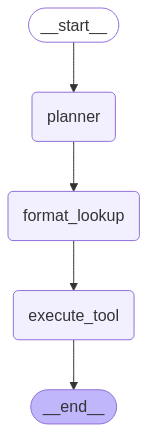

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
# --- Main Execution (Example) ---
if __name__ == "__main__":
    # --- LLM Initialization (Replace with yours) ---
    from langchain_openai import ChatOpenAI
    import os
    # Make sure OPENAI_API_KEY is set in your environment
    # os.environ["OPENAI_API_KEY"] = "your_key_here" 
    try:
        # Use a model known for good JSON adherence and instruction following
        llm = ChatOpenAI(model="gpt-4o", temperature=0.1) 
        # Or: llm = ChatOpenAI(model="gpt-4-turbo", temperature=0.1)
    except Exception as e:
        print(f"Failed to initialize LLM: {e}")
        print("Please ensure OPENAI_API_KEY is set correctly.")
        exit()

    # --- Sample Data ---
    sample_user_model = {
        "name": "Charlie",
        "goal": "Strength and Power",
        "experience_level": "Advanced",
        "days_per_week": 4,
        "preferred_equipment": ["barbell", "dumbbells", "kettlebells", "pullup bar"],
        "notes": "Focus on compound lifts, incorporate some explosive movements."
    }
    sample_research_findings = {
        "strength_principles": [
            "Lower rep ranges (1-6) are effective for top sets.",
            "Higher intensity (%1RM) is crucial.",
            "Adequate rest between sets (2-5 min) needed.",
            "Periodization helps manage fatigue and progress."
        ],
        "split_recommendation": "Upper/Lower or specific compound lift focus days.",
        "exercise_selection": "Prioritize Squat, Bench, Deadlift, Overhead Press variations. Include rows/pull-ups. Consider Olympic lift variations or plyometrics if suitable."
    }
    load_hevy_exercise_data()

    # --- Build and Run ---
    streamlined_graph = build_streamlined_routine_graph()

    async def main():
       await run_agent(sample_user_model, sample_research_findings, streamlined_graph)

    await main()

2025-04-03 21:08:30,239 - INFO - Loading Hevy exercise data from hevy_exercises.json...
2025-04-03 21:08:30,245 - INFO - Loaded 416 Hevy exercise templates.
2025-04-03 21:08:30,260 - INFO - Streamlined Routine Creation Agent graph compiled.
2025-04-03 21:08:30,261 - INFO - Starting Streamlined Routine Creation Agent run...
2025-04-03 21:08:30,268 - INFO - --- Executing Structured Planning Node (using with_structured_output) ---
2025-04-03 21:08:54,542 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-03 21:08:54,601 - INFO - Successfully received structured output with 4 routine(s) via with_structured_output.
2025-04-03 21:08:54,609 - INFO - --- Executing Format & Lookup Node ---
2025-04-03 21:08:54,609 - INFO - Formatting routine: 'Upper Body Strength A'
2025-04-03 21:08:54,610 - INFO - Exact match found for 'Bench Press (Barbell)' -> 'Bench Press (Barbell)'
2025-04-03 21:08:54,610 - INFO - Exact match found for 'Overhead Press (Barbell)'


--- Final State ---
User Model: {
  "name": "Charlie",
  "goal": "Strength and Power",
  "experience_level": "Advanced",
  "days_per_week": 4,
  "preferred_equipment": [
    "barbell",
    "dumbbells",
    "kettlebells",
    "pullup bar"
  ],
  "notes": "Focus on compound lifts, incorporate some explosive movements."
}
Research: {
  "strength_principles": [
    "Lower rep ranges (1-6) are effective for top sets.",
    "Higher intensity (%1RM) is crucial.",
    "Adequate rest between sets (2-5 min) needed.",
    "Periodization helps manage fatigue and progress."
  ],
  "split_recommendation": "Upper/Lower or specific compound lift focus days.",
  "exercise_selection": "Prioritize Squat, Bench, Deadlift, Overhead Press variations. Include rows/pull-ups. Consider Olympic lift variations or plyometrics if suitable."
}

Planner Structured Output (List[PlannerRoutineCreate]):
[
  {
    "title": "Upper Body Strength A",
    "notes": "Focus on compound lifts with emphasis on strength and powe

/var/folders/w1/3xy8j07565bb5vb8bqp7sbkm0000gn/T/ipykernel_15774/532322293.py:696: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  output_dicts = [routine.dict() for routine in final_state['planner_structured_output']]


In [43]:
# Load the JSON data from file
with open('combined_exercise_templates.json') as f:
    data = json.load(f)

# Extract all exercise titles into a list
titles = [exercise['title'] for exercise in data]


In [48]:
available_exercises = ", ".join(titles)

21s Bicep Curl, Ab Scissors, Ab Wheel, Aerobics, Air Bike, Arnold Press (Dumbbell), Around The World, Assisted Pistol Squats, Back Extension (Hyperextension), Back Extension (Machine), Back Extension (Weighted Hyperextension), Ball Slams, Band Pullaparts, Battle Ropes, Behind the Back Bicep Wrist Curl (Barbell), Bench Dip, Bench Press (Barbell), Bench Press (Cable), Bench Press - Close Grip (Barbell), Bench Press (Dumbbell), Bench Press (Smith Machine), Bench Press - Wide Grip (Barbell), Bent Over Row (Band), Bent Over Row (Barbell), Bent Over Row (Dumbbell), Bicep Curl (Barbell), Bicep Curl (Cable), Bicep Curl (Dumbbell), Bicep Curl (Machine), Bicep Curl (Suspension), Bicycle Crunch, Bicycle Crunch Raised Legs, Bird Dog, Boxing, Box Jump, Box Squat (Barbell), Bulgarian Split Squat, Burpee, Burpee Over the Bar, Butterfly (Pec Deck), Cable Core Palloff Press, Cable Crunch, Cable Fly Crossovers, Cable Pull Through, Cable Twist (Down to up), Cable Twist (Up to down), Calf Extension (Machi

In [50]:
print(titles)

['21s Bicep Curl', 'Ab Scissors', 'Ab Wheel', 'Aerobics', 'Air Bike', 'Arnold Press (Dumbbell)', 'Around The World', 'Assisted Pistol Squats', 'Back Extension (Hyperextension)', 'Back Extension (Machine)', 'Back Extension (Weighted Hyperextension)', 'Ball Slams', 'Band Pullaparts', 'Battle Ropes', 'Behind the Back Bicep Wrist Curl (Barbell)', 'Bench Dip', 'Bench Press (Barbell)', 'Bench Press (Cable)', 'Bench Press - Close Grip (Barbell)', 'Bench Press (Dumbbell)', 'Bench Press (Smith Machine)', 'Bench Press - Wide Grip (Barbell)', 'Bent Over Row (Band)', 'Bent Over Row (Barbell)', 'Bent Over Row (Dumbbell)', 'Bicep Curl (Barbell)', 'Bicep Curl (Cable)', 'Bicep Curl (Dumbbell)', 'Bicep Curl (Machine)', 'Bicep Curl (Suspension)', 'Bicycle Crunch', 'Bicycle Crunch Raised Legs', 'Bird Dog', 'Boxing', 'Box Jump', 'Box Squat (Barbell)', 'Bulgarian Split Squat', 'Burpee', 'Burpee Over the Bar', 'Butterfly (Pec Deck)', 'Cable Core Palloff Press', 'Cable Crunch', 'Cable Fly Crossovers', 'Cable

In [1]:
import logging, json
from agent.agent_models import StreamlinedRoutineState
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
async def run_agent(user_data, working_memory, compiled_graph):
    logger.info("Starting Streamlined Routine Creation Agent run...")
    
    # if not llm:
    #      raise ValueError("LLM not initialized. Set the 'llm' variable.")
         
    initial_state = StreamlinedRoutineState(
        user_model=user_data,
        working_memory=working_memory,
        planner_structured_output=None,
        hevy_payloads=None,
        hevy_results=None,
        errors=[]
    )

    final_state = await compiled_graph.ainvoke(initial_state)

    logger.info("--- Agent Run Finished ---")
    print("\n--- Final State ---")
    print(f"User Model: {json.dumps(final_state['user_model'], indent=2)}")
    print(f"Research: {json.dumps(final_state['working_memory']['research_findings'], indent=2)}")
    
    print("\nPlanner Structured Output (List[PlannerRoutineCreate]):")
    if final_state.get('planner_structured_output'):
        # Need to convert list of Pydantic models to dicts for json.dumps
        output_dicts = [routine.model_dump() for routine in final_state['planner_structured_output']]
        print(json.dumps(output_dicts, indent=2))
    else:
        print("None")
        
    print("\nHevy Payloads (Generated for Tool):")
    if final_state.get('hevy_payloads'):
         print(json.dumps(final_state['hevy_payloads'], indent=2))
    else:
         print("None")
         
    print("\nHevy Results (From Tool):")
    if final_state.get('hevy_results'):
        print(json.dumps(final_state['hevy_results'], indent=2))
    else:
        print("None")
        
    print("\nErrors Accumulated:")
    if final_state.get('errors'):
        for error in final_state['errors']:
            print(f"- {error}")
    else:
        print("No errors reported.")
        
    print("\nFinal Messages Log:")
    for msg in final_state.get('messages', []):
         print(f"- {msg.type}: {msg.content[:300]}...") # Truncate long messages

if __name__ == "__main__":
    # --- LLM Initialization (Replace with yours) ---
    from langchain_openai import ChatOpenAI
    import os
    # Make sure OPENAI_API_KEY is set in your environment
    # os.environ["OPENAI_API_KEY"] = "your_key_here" 
    # try:
    #     # Use a model known for good JSON adherence and instruction following
    #     llm = ChatOpenAI(model="gpt-4o", temperature=0.1) 
    #     # Or: llm = ChatOpenAI(model="gpt-4-turbo", temperature=0.1)
    # except Exception as e:
    #     print(f"Failed to initialize LLM: {e}")
    #     print("Please ensure OPENAI_API_KEY is set correctly.")
    #     exit()

    # --- Sample Data ---
    sample_user_model = {
        "name": "Charlie",
        "goal": "Strength and Power",
        "experience_level": "Advanced",
        "days_per_week": 4,
        "preferred_equipment": ["barbell", "dumbbells", "kettlebells", "pullup bar"],
        "notes": "Focus on compound lifts, incorporate some explosive movements."
    }
    sample_research_findings = {
        "strength_principles": [
            "Lower rep ranges (1-6) are effective for top sets.",
            "Higher intensity (%1RM) is crucial.",
            "Adequate rest between sets (2-5 min) needed.",
            "Periodization helps manage fatigue and progress."
        ],
        "split_recommendation": "Upper/Lower or specific compound lift focus days.",
        "exercise_selection": "Prioritize Squat, Bench, Deadlift, Overhead Press variations. Include rows/pull-ups. Consider Olympic lift variations or plyometrics if suitable."
    }
    working_memory = {}
    working_memory['research_findings'] = sample_research_findings
    # load_hevy_exercise_data()

    # --- Build and Run ---
    
    from agent.graph import build_streamlined_routine_graph

    streamlined_graph = build_streamlined_routine_graph()
    async def main():
       await run_agent(sample_user_model, working_memory, streamlined_graph)

    await main()


/Users/pranavtandra/Desktop/PersonalTrainerAI/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
2025-04-03 21:35:25,479 - INFO - Use pytorch device_name: mps
2025-04-03 21:35:25,480 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2025-04-03 21:35:27,301 - INFO - Loading Hevy exercise data from hevy_exercises.json...
2025-04-03 21:35:27,304 - INFO - Loaded 416 Hevy exercise templates.
2025-04-03 21:35:28,297 - INFO - Use pytorch device_name: mps
2025-04-03 21:35:28,298 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2025-04-03 21:35:29,450 - INFO - Streamlined Routine Creation Agent graph compiled.
2025-04-03 21:35:29,450 - INFO - Starting Streamlined Routine Creation Agent run...
/Users/pranavtandra/Desktop/PersonalT


--- Final State ---
User Model: {
  "name": "Charlie",
  "goal": "Strength and Power",
  "experience_level": "Advanced",
  "days_per_week": 4,
  "preferred_equipment": [
    "barbell",
    "dumbbells",
    "kettlebells",
    "pullup bar"
  ],
  "notes": "Focus on compound lifts, incorporate some explosive movements."
}
Research: {
  "strength_principles": [
    "Lower rep ranges (1-6) are effective for top sets.",
    "Higher intensity (%1RM) is crucial.",
    "Adequate rest between sets (2-5 min) needed.",
    "Periodization helps manage fatigue and progress."
  ],
  "split_recommendation": "Upper/Lower or specific compound lift focus days.",
  "exercise_selection": "Prioritize Squat, Bench, Deadlift, Overhead Press variations. Include rows/pull-ups. Consider Olympic lift variations or plyometrics if suitable."
}

Planner Structured Output (List[PlannerRoutineCreate]):
[
  {
    "title": "Upper Body Strength and Power",
    "notes": "Focus on upper body compound lifts. Include pressi

2025-04-03 21:35:52,825 - WARNING - Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')


# Adaptation Agent

In [8]:
# agent_models.py (Add this new TypedDict)
from typing import TypedDict, Optional, List, Dict, Any, Literal
from pydantic import BaseModel, Field
from agent.agent_models import UserModel, RoutineUpdate # Import necessary models

# prompts_v2.py (or add to prompts.py)

from langchain_core.prompts import PromptTemplate

# --- Prompts for V2 Adaptation Subgraph ---

# Use ANALYSIS_TEMPLATE_V2 content from previous messages
ANALYSIS_TEMPLATE_V2 = """You are a fitness progress analyst reviewing a user's workout data from the Hevy app, specifically in the context of ONE potential target routine.
Your goal is to:
1.  Generate a Comprehensive Report Summary: Summarize the user's workout history from the provided logs *as it relates to the exercises in the target routine*. Include adherence (if logs match routine structure), performance trends (volume, weight, reps on matching exercises), consistency, and any notable achievements or plateaus for exercises in *this specific routine*.
2.  Identify Key Observations: List the most important positive and negative trends observed *related to this routine*.
3.  Pinpoint Areas for Adjustment/Research: Based on the report and the user's profile/goals, identify specific, actionable areas where *this specific routine* might be adjusted or where further research is needed.

User Profile:
{user_profile}

Target Routine Details:
{target_routine_details}

Recent Workout Logs (provide context for analysis):
{workout_logs}

{format_instructions} # For AnalysisFindings model

Output ONLY the JSON object conforming to the AnalysisFindings structure.
"""

def get_analysis_v2_template(version=None):
    return PromptTemplate(
        input_variables=["user_profile", "target_routine_details", "workout_logs", "format_instructions"],
        template=ANALYSIS_TEMPLATE_V2
    )

# Use TARGETED_RAG_QUERY_TEMPLATE content from previous messages
TARGETED_RAG_QUERY_TEMPLATE = """Based on the user's profile and a specific area identified for potential adjustment in their fitness plan, generate a concise, targeted query for our fitness science RAG system (`retrieve_from_rag`).

User Profile:
{user_profile}

Area for Adjustment/Research: "{area_for_adjustment}"

Previous RAG Query (if any for this area): {previous_query}
Previous RAG Result (if any for this area): {previous_result}

Generate the *next* best query string to get specific, actionable scientific information related to the adjustment area. Focus on principles, techniques, or evidence. Output ONLY the query string.
"""
def get_targeted_rag_query_template(version=None):
    return PromptTemplate(
        input_variables=["user_profile", "area_for_adjustment", "previous_query", "previous_result"],
        template=TARGETED_RAG_QUERY_TEMPLATE
    )

# Use ROUTINE_MODIFICATION_TEMPLATE_V2 content from previous messages
ROUTINE_MODIFICATION_TEMPLATE_V2 = """You are an expert workout adaptation specialist. You are given the user's current workout routine as a JSON object and findings from their progress analysis and research for *this specific routine*. Your task is to **modify the provided JSON object** to incorporate necessary adjustments based on the findings and return the **entire, updated JSON object**.

**Critical Instructions:**
1.  **Input & Output:** You will receive the `current_routine_json`. Your output MUST be a valid JSON object representing the *complete*, *modified* routine, adhering strictly to the structure of the input JSON.
2.  **Modify, Don't Recreate:** Make targeted changes to the input JSON based on the `analysis_findings` and `adaptation_rag_results`. Do NOT create a new structure from scratch.
3.  **Preserve Metadata:** Ensure all original keys (like `id`, `folder_id`, `updated_at`, `created_at`, `index`, `custom_metric` within sets, etc.) are present in your output JSON, even if their values are unchanged or null. The API requires the full object structure.
4.  **Handling Exercise Changes:**
    *   **Modification:** To change sets, reps, weight, rest, or notes for an *existing* exercise, modify its properties directly within its JSON object. Keep its original `exercise_template_id`.
    *   **Deletion:** To remove an exercise, simply omit its entire JSON object from the `exercises` list in your output.
    *   **Addition:** To add a *new* exercise:
        *   Create a new exercise JSON object in the desired position within the `exercises` list.
        *   Set `"exercise_template_id": null`.
        *   Provide the **full, specific name** of the desired exercise (including equipment, e.g., 'Squat (Barbell)', 'Dumbbell Bench Press') in the `"title"` field.
        *   Fill in the `sets`, `rest_seconds`, `notes`, etc., for the new exercise.
    *   **Replacement:** To replace an *existing* exercise with a different one:
        *   Remove the original exercise's JSON object from the `exercises` list.
        *   Add a *new* exercise JSON object (as described in "Addition" above) in its place, setting `"exercise_template_id": null` and using the new exercise's specific name in the `"title"` field.
    *   **IMPORTANT:** NEVER invent or guess an `exercise_template_id`. Only use `null` for additions/replacements. The system will look up the correct ID based on the `title` you provide.
5.  **Explain Changes:** You will be asked to generate reasoning in a separate step. Focus *only* on outputting the modified JSON here.
6.  **Focus:** Modify weights, reps, sets, notes, add/replace/delete exercises based *only* on the `analysis_findings` and `adaptation_rag_results`. Ensure `rest_seconds` is present.

User Profile:
{user_profile}

Analysis Findings (for this routine):
{analysis_findings} # Example: "User plateaud on Barbell Bench Press. Consider swapping for Dumbbell Bench Press.", "Add Lateral Raises for shoulder width."

Relevant RAG Research Results (for this routine):
{adaptation_rag_results} # Example: "Dumbbell presses allow greater range of motion...", "Lateral raises effectively target medial deltoid..."

Current Routine JSON (Modify this structure):
```json
{current_routine_json}
```
Output only the complete, modified JSON object for the routine. Do not include ```json markdown delimiters or any other text.
"""

def get_routine_modification_template_v2(version=None):
    return PromptTemplate(
    input_variables=["user_profile", "analysis_findings", "adaptation_rag_results", "current_routine_json"],
    template=ROUTINE_MODIFICATION_TEMPLATE_V2
    )

REASONING_GENERATION_TEMPLATE = """Based on the changes made between the original routine and the modified routine, and considering the analysis/research findings, generate a concise user-facing explanation for the modifications made to this specific routine.

Original Routine Snippet (for context):
{original_routine_snippet}

Modified Routine Snippet (for context):
{modified_routine_snippet}

Analysis Findings (for this routine):
{analysis_findings}

Relevant RAG Research Results (for this routine):
{adaptation_rag_results}

Generate the reasoning text only.
"""

def get_reasoning_generation_template(version=None):
    return PromptTemplate(
    input_variables=["original_routine_snippet", "modified_routine_snippet", "analysis_findings", "adaptation_rag_results"],
    template=REASONING_GENERATION_TEMPLATE
    )

FINAL_CYCLE_REPORT_TEMPLATE_V2 = """You are an AI fitness coach summarizing the results of a potentially multi-routine progress analysis and adaptation cycle for the user.

User's Name: {user_name}

Summary of Processed Routines:
{processed_results_summary} # A formatted string summarizing outcome for each routine processed

Overall Cycle Status: {overall_status} # e.g., "Success", "Partial Success", "No Changes Made", "Failed"
Overall Message: {overall_message} # General concluding message based on status

Task: Generate a concise, clear, and encouraging final notification message for the user based on the information above.

Start with a greeting (e.g., "Hi {user_name},").

Use the overall_message as the main body.

Incorporate details from processed_results_summary if appropriate and not redundant with the overall message.

Keep the tone supportive and action-oriented if failures occurred (e.g., "I couldn't update routine X, we can look into that...").

Generate only the user-facing message.
"""
def get_final_cycle_report_template_v2(version=None):
    return PromptTemplate(
    input_variables=["user_name", "processed_results_summary", "overall_status", "overall_message"],
    template=FINAL_CYCLE_REPORT_TEMPLATE_V2
    )

ROUTINE_IDENTIFICATION_PROMPT = """You are an AI assistant analyzing a user's fitness routines and workout logs to identify which routine(s) should be targeted for adaptation.

User Profile:
{user_profile}

User's Explicit Request (if any): "{user_request_context}"

Available Saved Routines (List of JSON objects):

```json
{routines_list_json}
```

Recent Workout Logs (List of JSON objects):

```json
{logs_list_json}
```

Task: Identify the routine(s) from the Available Saved Routines list that are most relevant for adaptation based on the user's request, recent logs, and profile. Consider:

User Request: If the user mentioned a specific routine (e.g., "leg day", "push workout"), prioritize routines matching that description.

Log Matching: Find routines whose exercises strongly overlap with exercises performed in the most recent logs. Look for consistent use patterns.

Primary Routine: Identify if there seems to be a main routine the user follows most often.

Goals: Align the selected routine(s) with the user's stated goals.

Output Format:
Return a JSON list containing the full JSON object of each identified routine from the input Available Saved Routines list. Include a reason_for_selection key within each object in the output list.

Example Output:
```json
[
  {{
    "routine_data": {{ ... full routine object from input list ... }},
    "reason_for_selection": "Matches user request 'leg day' and has high overlap with recent logs."
  }},
  {{
    "routine_data": {{ ... another full routine object ... }},
    "reason_for_selection": "Appears to be the primary strength routine based on log frequency."
  }}
]
```

If no suitable routines are found, return an empty JSON list [].

Output only the JSON list. Do not include ```json markdown delimiters or any other text.
"""

def get_routine_identification_prompt(version=None):
    return PromptTemplate(
    input_variables=["user_profile", "user_request_context", "routines_list_json", "logs_list_json"],
    template=ROUTINE_IDENTIFICATION_PROMPT
    )

# --- Models specific to V2 Subgraph ---

class AnalysisFindings(BaseModel):
    """Structured findings from workout log analysis."""
    summary: str = Field(description="A brief text summary of the progress report.")
    key_observations: List[str] = Field(description="List of key positive or negative observations.")
    areas_for_potential_adjustment: List[str] = Field(description="Specific areas identified for adjustment/research.")

class IdentifiedRoutineTarget(TypedDict):
    """Represents a routine identified for adaptation."""
    routine_data: Dict[str, Any] # Full routine data from Hevy (structure matches GET /routines/{id})
    reason_for_selection: str # Why this routine was chosen

class RoutineAdaptationResult(TypedDict):
    """Stores the outcome of adapting a single routine."""
    routine_id: str
    original_title: str
    status: Literal["Success", "Failed", "Skipped (No Changes)", "Skipped (Error)"]
    message: str # e.g., Hevy response, error details, "No changes needed"
    updated_routine_data: Optional[Dict[str, Any]] # The full data after successful update

class ProgressAnalysisAdaptationStateV2(TypedDict):
    """State for subgraph V2 handling identification, analysis, and adaptation."""

    # --- Inputs (Required from parent graph) ---
    user_model: UserModel
    user_request_context: Optional[str] # Specific user request, e.g., "Make my leg day harder"

    # --- Internal State (Managed by the subgraph nodes) ---
    fetched_routines_list: Optional[List[Dict[str, Any]]]
    workout_logs: Optional[List[Dict[str, Any]]]
    identified_targets: Optional[List[IdentifiedRoutineTarget]]
    # Use List[] default factory if supported, otherwise initialize in first node
    processed_results: List[RoutineAdaptationResult] # Results for each processed target

    # Error tracking across the whole process
    process_error: Optional[str]

    # --- Outputs (Returned to parent graph) ---
    final_report_and_notification: Optional[str]
    cycle_completed_successfully: bool


In [9]:


import json
import logging
import asyncio
from typing import Dict, Any, Optional, List, Tuple
from pydantic import BaseModel, Field, ValidationError
from langchain.output_parsers.pydantic import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
import os
from agent.utils import (
    get_exercise_template_by_title_fuzzy,
    HEVY_EXERCISES_LIST,
    HEVY_TITLE_TO_TEMPLATE_MAP
)

# Import Tools
from agent.llm_tools import (
    tool_fetch_routines,
    tool_fetch_workouts,
    tool_get_workout_count,
    retrieve_from_rag,
    tool_update_routine
)
# Import V2 Prompts


logger = logging.getLogger(__name__)
# Ensure OPENAI_API_KEY is loaded, e.g., via load_dotenv() in the main script
llm = ChatOpenAI(model="gpt-4o", temperature=0.1) # Lower temp for structured output

# --- Node Implementations ---



async def validate_and_lookup_exercises(
    proposed_routine_json: Dict[str, Any],
    original_routine_title: str # For logging context
) -> Tuple[Optional[Dict[str, Any]], List[str]]:
    """
    Validates exercises in a proposed routine JSON from the LLM.
    - Keeps exercises with existing, valid IDs (corrects title if needed).
    - If an *invalid* ID is provided, attempts fallback fuzzy lookup using the title.
    - Uses fuzzy lookup for exercises where ID is null (indicating addition/replacement).
    - Removes exercises where lookup fails or structure is invalid.
    - Corrects titles to match official Hevy titles post-lookup.

    Args:
        proposed_routine_json: The full routine JSON dictionary proposed by the LLM.
        original_routine_title: The title of the routine being processed (for logging).

    Returns:
        A tuple containing:
        - The validated/corrected routine JSON dictionary (or None if fatal error).
        - A list of warning/error messages encountered during validation for this routine.
    """
    if not proposed_routine_json or not isinstance(proposed_routine_json.get("exercises"), list):
        return None, ["Invalid routine structure received from LLM."]

    # Check if fuzzy matching data is loaded
    if not HEVY_EXERCISES_LIST or not HEVY_TITLE_TO_TEMPLATE_MAP:
         error_msg = f"Cannot validate exercises for routine '{original_routine_title}': Hevy exercise data not loaded."
         logger.error(error_msg)
         # This is a fatal error for validation
         return None, [error_msg]

    corrected_exercises = []
    validation_errors = [] # Store non-fatal warnings/errors for this routine
    original_exercises = proposed_routine_json.get("exercises", [])

    logger.debug(f"Validating {len(original_exercises)} exercises proposed for routine '{original_routine_title}'.")

    # Create a quick lookup map of valid template IDs from loaded data
    valid_template_ids = {ex['id'] for ex in HEVY_EXERCISES_LIST if isinstance(ex, dict) and 'id' in ex}
    # Optional: Map ID back to official title for correction
    id_to_official_title = {
        ex['id']: ex['title']
        for ex in HEVY_EXERCISES_LIST if isinstance(ex, dict) and 'id' in ex and 'title' in ex
    }

    for index, proposed_ex in enumerate(original_exercises):
        if not isinstance(proposed_ex, dict):
             warn_msg = f"Skipping item at index {index} in routine '{original_routine_title}': Invalid format (not a dictionary)."
             logger.warning(warn_msg)
             validation_errors.append(warn_msg)
             continue

        llm_provided_id = proposed_ex.get("exercise_template_id")
        # Ensure title is treated as string and stripped
        llm_provided_title = str(proposed_ex.get("title", "")).strip()

        # Case 1: LLM provided an ID (could be valid, invalid, or hallucinated)
        if llm_provided_id is not None and str(llm_provided_id).strip() != "":
            # Ensure comparison is consistent (e.g., string comparison if IDs are strings)
            current_id_str = str(llm_provided_id).strip()

            if current_id_str in valid_template_ids:
                # --- Subcase 1.1: ID is VALID ---
                official_title = id_to_official_title.get(current_id_str, llm_provided_title)
                if official_title != llm_provided_title:
                     logger.debug(f"Correcting title for existing exercise {index} (ID: {current_id_str}) from '{llm_provided_title}' to '{official_title}' in routine '{original_routine_title}'.")
                     proposed_ex["title"] = official_title
                # Ensure template ID is explicitly set with the validated ID
                proposed_ex["exercise_template_id"] = current_id_str
                corrected_exercises.append(proposed_ex)
                logger.debug(f"Exercise {index} ('{official_title}') validated using provided valid ID {current_id_str} in routine '{original_routine_title}'.")
            else:
                # --- Subcase 1.2: ID is INVALID ---
                # Log the initial problem
                warn_msg = (f"Provided exercise_template_id '{current_id_str}' for exercise '{llm_provided_title}' (index {index}) "
                            f"in routine '{original_routine_title}' is invalid or not found in Hevy data.")
                logger.warning(warn_msg)
                validation_errors.append(warn_msg) # Record the fact that an invalid ID was given

                # --- !! Optional Fallback Logic !! ---
                if llm_provided_title:
                    logger.info(f"Attempting fallback for index {index}: Fuzzy matching title '{llm_provided_title}' since ID '{current_id_str}' was invalid...")
                    matched_template = await get_exercise_template_by_title_fuzzy(llm_provided_title)

                    if matched_template and matched_template.get("id"):
                        # Fallback Successful!
                        matched_id = matched_template["id"]
                        matched_title = matched_template["title"]
                        logger.info(f"Fallback successful for index {index}! Matched '{llm_provided_title}' to '{matched_title}' (Correct ID: {matched_id}). Using this match.")
                        # Update the exercise dict with the correct ID and official title
                        proposed_ex["exercise_template_id"] = matched_id
                        proposed_ex["title"] = matched_title
                        corrected_exercises.append(proposed_ex)
                        # Continue to next exercise in the loop
                        continue
                    else:
                        # Fallback Failed (No Match Found)
                        err_msg_detail = (f"Fallback failed for index {index}: Could not find fuzzy match for title '{llm_provided_title}'. "
                                          f"Skipping exercise originally proposed with invalid ID '{current_id_str}'.")
                        logger.error(err_msg_detail)
                        validation_errors.append(err_msg_detail) # Add specific fallback failure message
                        # Skip this exercise - continue to next iteration
                        continue
                else:
                    # Fallback Not Possible (No Title Provided)
                    err_msg_detail = (f"Cannot perform fallback lookup for exercise at index {index}: No title provided. "
                                      f"Skipping exercise originally proposed with invalid ID '{current_id_str}'.")
                    logger.error(err_msg_detail)
                    validation_errors.append(err_msg_detail) # Add specific reason for skipping
                    # Skip this exercise - continue to next iteration
                    continue
                # --- !! End Fallback Logic !! ---

        # Case 2: LLM provided null/empty ID (signaling Add/Replace) and a title
        elif llm_provided_id is None or str(llm_provided_id).strip() == "":
            if not llm_provided_title:
                err_msg = (f"Skipping exercise at index {index} in routine '{original_routine_title}': "
                           f"exercise_template_id is null/empty, but no title was provided for lookup.")
                logger.error(err_msg)
                validation_errors.append(err_msg)
                continue

            logger.debug(f"Attempting fuzzy lookup for '{llm_provided_title}' (index {index}) in routine '{original_routine_title}' as ID was null/empty.")
            matched_template = await get_exercise_template_by_title_fuzzy(llm_provided_title)

            if matched_template and matched_template.get("id"):
                # Fuzzy Match Successful
                matched_id = matched_template["id"]
                matched_title = matched_template["title"]
                logger.info(f"Fuzzy match successful for '{llm_provided_title}': Corrected to '{matched_title}' (ID: {matched_id}) in routine '{original_routine_title}'.")
                # Update the exercise dict with the correct ID and official title
                proposed_ex["exercise_template_id"] = matched_id
                proposed_ex["title"] = matched_title
                corrected_exercises.append(proposed_ex)
            else:
                # Fuzzy Match Failed
                err_msg = (f"Skipping exercise '{llm_provided_title}' at index {index} in routine '{original_routine_title}': "
                           f"Failed to find a suitable fuzzy match in Hevy exercise data (ID was null/empty).")
                logger.error(err_msg)
                validation_errors.append(err_msg)
                continue
        else:
             # Should not happen if template ID is handled correctly (string, null, or empty)
             # but added for completeness
             warn_msg = f"Unexpected format or value for exercise_template_id ('{llm_provided_id}') for exercise '{llm_provided_title}' at index {index} in routine '{original_routine_title}'. Skipping."
             logger.warning(warn_msg)
             validation_errors.append(warn_msg)
             continue

    # --- Final Routine Assembly and Checks ---
    validated_routine_dict = {**proposed_routine_json, "exercises": corrected_exercises}

    # Final check: Did we end up with any exercises?
    if not validated_routine_dict.get("exercises") and original_exercises:
         # Only raise fatal error if exercises were proposed but ALL failed validation/lookup
         error_msg = f"Validation resulted in no valid exercises remaining for routine '{original_routine_title}', although exercises were proposed. Cannot update."
         logger.error(error_msg)
         validation_errors.append(error_msg)
         # Return None to signal a failure to update this routine
         return None, validation_errors
    elif not validated_routine_dict.get("exercises"):
         logger.info(f"Routine '{original_routine_title}' is proposed to have no exercises after modification and validation. This might be intentional.")
         # Allow empty exercise list if that was the outcome

    logger.info(f"Exercise validation/lookup complete for routine '{original_routine_title}'. {len(corrected_exercises)} exercises prepared. Issues: {len(validation_errors)}")
    # Return the corrected dictionary and any non-fatal errors encountered
    return validated_routine_dict, validation_errors


async def fetch_all_routines_node(state: ProgressAnalysisAdaptationStateV2) -> Dict[str, Any]:
    """Fetches all available routines from Hevy."""
    logger.info("--- Progress Cycle V2: Fetching All Routines ---")
    all_routines = []
    page = 1
    page_size = 20 # Fetch in batches
    try:
        while True:
            logger.debug(f"Fetching routines page {page}...")
            result = await tool_fetch_routines.ainvoke({"page": page, "pageSize": page_size})
            if isinstance(result, dict) and result.get("routines"):
                fetched_page = result["routines"]
                all_routines.extend(fetched_page)
                # Check if this was the last page (Hevy API might indicate this,
                # otherwise, stop if fewer routines than page_size were returned)
                if len(fetched_page) < page_size:
                    break
                page += 1
            elif isinstance(result, dict) and result.get("error"):
                 raise Exception(f"Hevy API error fetching routines: {result.get('error')}")
            else:
                 # Assume empty list or unexpected format means no more routines
                 break
        logger.info(f"Successfully fetched {len(all_routines)} routines.")
        return {"fetched_routines_list": all_routines, "process_error": None}
    except Exception as e:
        logger.error(f"Error fetching routines: {e}", exc_info=True)
        return {"fetched_routines_list": None, "process_error": f"Failed to fetch routines: {e}"}

async def fetch_logs_node(state: ProgressAnalysisAdaptationStateV2) -> Dict[str, Any]:
    """Fetches workout logs from Hevy."""
    if state.get("process_error"): return {} # Skip on prior error
    logger.info("--- Progress Cycle V2: Fetching Logs ---")
    try:
        # Fetch a reasonable number of logs for context
        workout_count_data = await tool_get_workout_count.ainvoke({})
        total_workouts = workout_count_data.get('count', 20)
        page_size = 30 # Increase slightly for better identification context?
        logger.info(f"Fetching latest {page_size} workout logs (total: {total_workouts})...")
        fetched_logs = await tool_fetch_workouts.ainvoke({"page": 1, "pageSize": page_size})
        workout_logs_data = fetched_logs.get('workouts', [])

        if not workout_logs_data:
            logger.warning("No workout logs found.")
            # Don't set process_error, identification might proceed without logs or fail gracefully
            return {"workout_logs": []}
        logger.info(f"Successfully fetched {len(workout_logs_data)} logs.")
        return {"workout_logs": workout_logs_data, "process_error": None}
    except Exception as e:
        logger.error(f"Error fetching workout logs: {e}", exc_info=True)
        # Treat log fetch failure as potentially recoverable, don't halt immediately
        return {"workout_logs": None, "process_error": f"Warning: Failed to fetch logs: {e}"}


async def identify_target_routines_node(state: ProgressAnalysisAdaptationStateV2) -> Dict[str, Any]:
    """Identifies target routines based on logs, request, and available routines."""
    if state.get("process_error") and "Failed to fetch routines" in state["process_error"]:
        # Cannot proceed without routines
        logger.error("Halting identification: Failed to fetch routines list.")
        return {"process_error": state["process_error"]}
    logger.info("--- Progress Cycle V2: Identifying Target Routines ---")

    routines_list = state.get("fetched_routines_list")
    logs = state.get("workout_logs")
    user_model = state.get("user_model")
    user_request = state.get("user_request_context", "")

    if not routines_list:
        logger.warning("No routines available to identify targets from.")
        return {"identified_targets": [], "process_error": state.get("process_error")} # Return empty list, keep potential log error

    # Prepare prompt
    id_prompt_template = get_routine_identification_prompt()
    try:
        # Limit size of JSON passed to LLM if necessary
        routines_json = json.dumps(routines_list[:10], indent=2) # Limit to first 10 routines?
        logs_json = json.dumps(logs[:10] if logs else [], indent=2) # Limit logs context

        filled_prompt = id_prompt_template.format(
            user_profile=json.dumps(user_model.model_dump() if user_model else {}),
            user_request_context=user_request,
            routines_list_json=routines_json,
            logs_list_json=logs_json
        )
    except Exception as e:
         logger.error(f"Error formatting identification prompt: {e}")
         return {"process_error": f"Internal error formatting identification prompt: {e}"}

    # Call LLM
    messages = [SystemMessage(content=filled_prompt)]
    try:
        response = await llm.ainvoke(messages)
        output_str = response.content.strip()

        # Parse the JSON list output
        identified_targets_raw = json.loads(output_str)

        # Validate the structure (basic check)
        if not isinstance(identified_targets_raw, list):
            raise ValueError("LLM did not return a JSON list.")

        # Re-structure slightly to match IdentifiedRoutineTarget TypedDict if needed
        # The prompt asks for {"routine_data": {...}, "reason": "..."} structure
        # This already matches IdentifiedRoutineTarget
        identified_targets: List[IdentifiedRoutineTarget] = identified_targets_raw

        # Further validation can be added here if needed

        logger.info(f"Identified {len(identified_targets)} target routine(s).")
        # Filter targets to ensure 'routine_data' and 'id' exist
        valid_targets = [
            t for t in identified_targets
            if isinstance(t, dict) and isinstance(t.get("routine_data"), dict) and t["routine_data"].get("id")
        ]
        if len(valid_targets) != len(identified_targets):
             logger.warning("Some identified targets had invalid structure and were filtered.")

        return {"identified_targets": valid_targets, "process_error": state.get("process_error")} # Keep potential log error

    except json.JSONDecodeError as e:
         logger.error(f"Error parsing identification JSON from LLM: {e}\nLLM Response:\n{output_str}", exc_info=True)
         return {"process_error": f"Failed to parse valid JSON targets from LLM: {e}"}
    except Exception as e:
        logger.error(f"Error during routine identification LLM call: {e}\nLLM Response:\n{output_str if 'output_str' in locals() else 'N/A'}", exc_info=True)
        return {"process_error": f"Error during routine identification: {e}"}


async def process_targets_node(state: ProgressAnalysisAdaptationStateV2) -> Dict[str, Any]:
    """Iterates through identified targets and attempts adaptation for each."""
    if state.get("process_error"): return {} # Skip if critical error happened before
    logger.info("--- Progress Cycle V2: Processing Identified Targets ---")

    targets = state.get("identified_targets", [])
    if not targets:
        logger.info("No targets to process.")
        return {"processed_results": []} # Return empty list if no targets

    logs = state.get("workout_logs")
    user_model = state.get("user_model")
    processed_results: List[RoutineAdaptationResult] = []
    any_target_failed = False # Flag if any individual adaptation fails

    # --- Get Prompt Templates Once ---
    analysis_prompt_template = get_analysis_v2_template()
    rag_query_prompt_template = get_targeted_rag_query_template()
    modification_prompt_template = get_routine_modification_template_v2()
    reasoning_prompt_template = get_reasoning_generation_template()
    analysis_parser = PydanticOutputParser(pydantic_object=AnalysisFindings)
    analysis_format_instructions = analysis_parser.get_format_instructions()

    # --- Loop Through Each Target ---
    for target in targets:
        routine_data = target["routine_data"]
        routine_id = routine_data["id"]
        original_title = routine_data.get("title", "Unknown Title")
        logger.info(f"--- Processing Target: '{original_title}' (ID: {routine_id}) ---")

        # Initialize result for this target
        current_result = RoutineAdaptationResult(
            routine_id=routine_id,
            original_title=original_title,
            status="Skipped (Error)", # Default to error
            message="Processing started",
            updated_routine_data=None
        )

        try:
            # 1. Analyze Report for Target
            logger.debug(f"Analyzing target '{original_title}'...")
            analysis_findings: Optional[AnalysisFindings] = None
            analysis_error = None
            try:
                analysis_filled_prompt = analysis_prompt_template.format(
                    user_profile=json.dumps(user_model.model_dump() if user_model else {}),
                    target_routine_details=json.dumps(routine_data),
                    workout_logs=json.dumps(logs[:20] if logs else []), # Limit context
                    format_instructions=analysis_format_instructions
                )
                analysis_response = await llm.ainvoke([SystemMessage(content=analysis_filled_prompt)])
                analysis_findings = analysis_parser.parse(analysis_response.content)
                logger.debug(f"Analysis successful for '{original_title}'. Areas found: {len(analysis_findings.areas_for_potential_adjustment)}")
            except Exception as e:
                analysis_error = f"Failed analysis step: {e}"
                logger.error(analysis_error, exc_info=True)
                current_result["message"] = analysis_error
                any_target_failed = True
                processed_results.append(current_result)
                continue # Skip to next target if analysis fails

            # Check if adjustments are needed
            if not analysis_findings or not analysis_findings.areas_for_potential_adjustment:
                logger.info(f"No adjustment areas identified for '{original_title}'. Skipping further steps.")
                current_result["status"] = "Skipped (No Changes)"
                current_result["message"] = "Analysis completed, no modifications needed for this routine."
                processed_results.append(current_result)
                continue # Skip to next target

            # 2. Research Gaps for Target
            logger.debug(f"Researching gaps for '{original_title}'...")
            adaptation_rag_results = {}
            rag_error = None
            try:
                user_profile_json = json.dumps(user_model.model_dump() if user_model else {})
                for area in analysis_findings.areas_for_potential_adjustment:
                    try:
                        query_gen_prompt = rag_query_prompt_template.format(
                            user_profile=user_profile_json, area_for_adjustment=area,
                            previous_query="N/A", previous_result="N/A"
                        )
                        query_response = await llm.ainvoke([SystemMessage(content=query_gen_prompt)])
                        rag_query = query_response.content.strip()
                        if rag_query:
                            rag_result = await retrieve_from_rag.ainvoke({"query": rag_query})
                            adaptation_rag_results[area] = rag_result or "No specific info."
                        else:
                            adaptation_rag_results[area] = "Could not generate query."
                    except Exception as inner_e:
                         logger.warning(f"Failed RAG for area '{area}': {inner_e}")
                         adaptation_rag_results[area] = f"Error: {inner_e}"
                         rag_error = f"Partial RAG failure on area '{area}'" # Flag partial failure
            except Exception as e:
                 rag_error = f"Failed RAG step: {e}"
                 logger.error(rag_error, exc_info=True)
                 # Continue processing, but note the RAG failure

            if rag_error and not current_result["message"].startswith("Failed"): # Don't overwrite analysis error
                 current_result["message"] = rag_error # Report partial failure


            # 3. Generate Modifications for Target
            logger.debug(f"Generating modifications for '{original_title}'...")
            proposed_mods_dict: Optional[Dict[str, Any]] = None
            modification_reasoning = "N/A"
            mod_output_str = "N/A" # Initialize for error logging
            generation_error = None
            try:
                mod_filled_prompt = modification_prompt_template.format( # Uses updated template
                    user_profile=json.dumps(user_model.model_dump() if user_model else {}),
                    analysis_findings=json.dumps(analysis_findings.model_dump()),
                    adaptation_rag_results=json.dumps(adaptation_rag_results),
                    current_routine_json=json.dumps(routine_data, indent=2)
                )
                mod_response = await llm.ainvoke([SystemMessage(content=mod_filled_prompt)])
                mod_output_str = mod_response.content.strip()
                proposed_mods_dict = json.loads(mod_output_str)
                if not isinstance(proposed_mods_dict, dict) or 'exercises' not in proposed_mods_dict:
                    raise ValueError("LLM output was not a valid routine JSON dict.")

                # Generate reasoning
                try:
                     reasoning_filled_prompt = reasoning_prompt_template.format(
                         original_routine_snippet=json.dumps(routine_data.get('exercises', [])[:2], indent=2),
                         modified_routine_snippet=json.dumps(proposed_mods_dict.get('exercises', [])[:2], indent=2),
                         analysis_findings=json.dumps(analysis_findings.model_dump()),
                         adaptation_rag_results=json.dumps(adaptation_rag_results)
                     )
                     reasoning_response = await llm.ainvoke([SystemMessage(content=reasoning_filled_prompt)])
                     modification_reasoning = reasoning_response.content.strip()
                except Exception as reason_e:
                     logger.warning(f"Failed to generate reasoning: {reason_e}")
                     modification_reasoning = "(Failed to generate reasoning)"

                logger.debug(f"Modification generation successful for '{original_title}'.")

            except Exception as e:
                generation_error = f"Failed modification step: {e}"
                logger.error(f"{generation_error}\nLLM Response:\n{mod_output_str if 'mod_output_str' in locals() else 'N/A'}", exc_info=True)
                current_result["message"] = generation_error
                any_target_failed = True
                processed_results.append(current_result)
                continue # Skip to next target

            # --- *** NEW STEP: Validate and Lookup Exercises *** ---
            logger.debug(f"Validating and looking up exercises for '{original_title}'...")
            validated_routine_dict, validation_errors = await validate_and_lookup_exercises(
                proposed_mods_dict,
                original_title
            )

            if validation_errors:
                # Log errors, decide if they are fatal for this routine
                errors_string = "; ".join(validation_errors)
                logger.warning(f"Validation issues found for routine '{original_title}': {errors_string}")
                # If validation returned None, it's a fatal error for this routine
                if validated_routine_dict is None:
                    fatal_error_msg = f"Fatal validation error for '{original_title}', cannot update Hevy. Issues: {errors_string}"
                    logger.error(fatal_error_msg)
                    current_result["message"] = fatal_error_msg
                    current_result["status"] = "Skipped (Error)" # Ensure status reflects failure
                    any_target_failed = True
                    processed_results.append(current_result)
                    continue # Skip Hevy update for this target

            # If validation passed (even with minor warnings), proceed with the validated data
            logger.info(f"Validation successful for '{original_title}'. Proceeding to update Hevy.")

            # --- *** ADD THIS LOGGING *** ---
            logger.debug(f"Payload prepared for Hevy update (routine: '{original_title}', ID: {routine_id}):")
            try:
                # Pretty print the dictionary for readability in DEBUG logs
                logger.debug(json.dumps(validated_routine_dict, indent=2, default=str))
            except Exception as log_e:
                logger.error(f"Failed to serialize validated_routine_dict for logging: {log_e}")
                logger.debug(f"Raw validated_routine_dict: {validated_routine_dict}")
            # --- *** END OF ADDED LOGGING *** ---
            # 4. Update Hevy for Target
            logger.debug(f"Updating Hevy for '{original_title}'...")
            hevy_error = None
            updated_data_from_hevy = None
            try:
                # *** USE THE VALIDATED DICTIONARY ***
                hevy_result = await tool_update_routine.ainvoke({
                    "routine_id": routine_id,
                    "routine_data": validated_routine_dict # Send the validated/corrected dict
                })

                logger.info(f"Hevy API update result (raw type: {type(hevy_result)}): {hevy_result}") # Log type

                # --- FIX V2: Check expected structures ---
                updated_routine_dict = None
                is_success = False

                # Check if result is {'routine': [ {routine_dict} ] }
                if isinstance(hevy_result, dict) and \
                   isinstance(hevy_result.get("routine"), list) and \
                   len(hevy_result["routine"]) > 0 and \
                   isinstance(hevy_result["routine"][0], dict) and \
                   hevy_result["routine"][0].get("id"):

                    updated_routine_dict = hevy_result["routine"][0] # Extract from list
                    is_success = True
                    logger.info(f"Hevy routine '{original_title}' updated successfully (via dict wrapping list).")

                # Check if result is { "routine": {routine_dict} } (Original expectation)
                elif isinstance(hevy_result, dict) and \
                     isinstance(hevy_result.get("routine"), dict) and \
                     hevy_result["routine"].get("id"):

                     updated_routine_dict = hevy_result["routine"] # Directly use the dict
                     is_success = True
                     logger.info(f"Hevy routine '{original_title}' updated successfully (via dict wrapping dict).")

                # Check if result is [ {routine_dict} ] (Previous attempt's expectation)
                elif isinstance(hevy_result, list) and \
                     len(hevy_result) > 0 and \
                     isinstance(hevy_result[0], dict) and \
                     hevy_result[0].get("id"):

                    updated_routine_dict = hevy_result[0] # Extract from list
                    is_success = True
                    logger.info(f"Hevy routine '{original_title}' updated successfully (via direct list).")

                # --- End Fix V2 ---

                if is_success:
                    logger.info(f"Hevy routine '{original_title}' updated successfully.")
                    current_result["status"] = "Success"
                    current_result["message"] = f"Routine '{original_title}' updated successfully."
                    current_result["updated_routine_data"] = hevy_result.get("routine")
                    updated_data_from_hevy = hevy_result.get("routine")
                else:
                    hevy_error_detail = json.dumps(hevy_result.get("error", hevy_result) if isinstance(hevy_result, dict) else hevy_result)
                    hevy_error = f"Hevy update failed for '{original_title}': {hevy_error_detail}"
                    logger.error(hevy_error)
                    current_result["message"] = hevy_error
                    any_target_failed = True

            except Exception as e:
                hevy_error = f"Internal error during Hevy update for '{original_title}': {e}"
                logger.error(hevy_error, exc_info=True)
                current_result["message"] = hevy_error
                current_result["status"] = "Skipped (Error)" # Ensure status reflects failure
                any_target_failed = True

            # Append result for this target
            processed_results.append(current_result)

        except Exception as outer_e:
             # Catch unexpected errors in the loop logic itself
            logger.error(f"Unexpected error processing target '{original_title}': {outer_e}", exc_info=True)
            current_result["message"] = f"Unexpected error: {outer_e}"
            current_result["status"] = "Skipped (Error)" # Ensure status reflects failure
            any_target_failed = True
            processed_results.append(current_result)
            continue # Ensure loop continues

    # --- Return Accumulated Results ---
    final_state_update = {"processed_results": processed_results}
    # If any individual target failed, propagate a general process error message
    # but don't overwrite a more specific earlier error (like routine fetch failure)
    if any_target_failed and not state.get("process_error"):
         final_state_update["process_error"] = "One or more routines failed during the adaptation process."

    logger.info(f"Finished processing all targets. Results count: {len(processed_results)}")
    return final_state_update


async def compile_final_report_node_v2(state: ProgressAnalysisAdaptationStateV2) -> Dict[str, Any]:
    """Compiles the final user-facing report for potentially multiple routines."""
    logger.info("--- Progress Cycle V2: Compiling Final Report ---")

    processed_results = state.get("processed_results", [])
    initial_process_error = state.get("process_error") # Error from early stages (fetch, identify)
    user_model = state.get("user_model")

    # Determine overall status
    overall_status = "Failed" # Default
    overall_message = initial_process_error or "An unknown error occurred." # Start with initial error if present
    processed_summary_lines = []
    success_count = 0
    skipped_no_changes_count = 0
    failure_count = 0
    total_processed = len(processed_results)

    if not initial_process_error:
        if not state.get("identified_targets") and not processed_results:
            overall_status = "Completed (No Targets)"
            overall_message = "I looked at your routines and recent logs, but didn't identify any specific routines needing adaptation right now based on the analysis."
            cycle_completed_successfully = True
        elif processed_results:
            for res in processed_results:
                status_icon = "✅" if res["status"] == "Success" else ("⚠️" if res["status"] == "Skipped (No Changes)" else "❌")
                processed_summary_lines.append(f"{status_icon} **{res['original_title']}**: {res['message']}")
                if res["status"] == "Success": success_count += 1
                if res["status"] == "Skipped (No Changes)": skipped_no_changes_count += 1
                if res["status"] == "Failed" or res["status"] == "Skipped (Error)": failure_count += 1

            if failure_count == 0 and success_count > 0:
                overall_status = "Success"
                overall_message = "I've finished analyzing your progress and successfully updated the relevant routines!"
            elif failure_count == 0 and success_count == 0 and skipped_no_changes_count > 0:
                overall_status = "Completed (No Changes)"
                overall_message = "I've analyzed your progress for the relevant routines, and everything looks on track - no changes needed this time!"
            elif success_count > 0 and failure_count > 0:
                overall_status = "Partial Success"
                overall_message = f"I analyzed your routines. I was able to update {success_count} routine(s), but encountered issues with {failure_count}."
            else: # All failed or skipped with errors
                overall_status = "Failed"
                overall_message = "I tried to analyze and adapt your routines, but encountered errors during the process."

            cycle_completed_successfully = failure_count == 0
        else:
             # This case shouldn't be reached if logic is right (targets identified but no results)
             overall_message = "An unexpected state occurred after identifying targets."
             cycle_completed_successfully = False
    else:
         # Initial process error occurred (e.g., fetch routines failed)
         overall_status = "Failed"
         overall_message = f"I couldn't complete the progress review due to an initial error: {initial_process_error}"
         cycle_completed_successfully = False


    # Format summary string
    processed_results_summary = "\n".join(processed_summary_lines) if processed_summary_lines else "No routines were processed."

    # Generate the final user message using LLM
    final_report_prompt_template = get_final_cycle_report_template_v2()
    user_name = user_model.name if user_model else "there"
    final_message = overall_message # Fallback

    try:
         filled_prompt = final_report_prompt_template.format(
             user_name=user_name,
             processed_results_summary=processed_results_summary,
             overall_status=overall_status,
             overall_message=overall_message
         )
         response = await llm.ainvoke([SystemMessage(content=filled_prompt)])
         final_message = response.content.strip()
    except Exception as e:
         logger.error(f"Error generating final report message: {e}", exc_info=True)
         # Use the constructed message as fallback
         final_message = f"Hi {user_name}, {overall_message}\n\nDetails:\n{processed_results_summary}"


    logger.info(f"Final Cycle Report V2: Status={overall_status}, Successful={cycle_completed_successfully}")
    return {
        "final_report_and_notification": final_message,
        "cycle_completed_successfully": cycle_completed_successfully,
        "process_error": initial_process_error if initial_process_error else state.get("process_error") # Persist any error msg
    }

In [10]:
# subgraphs_v2.py
from langgraph.graph import StateGraph, END
# Import V2 state and nodes


# Routing condition after identification
def _check_targets_found(state: ProgressAnalysisAdaptationStateV2) -> str:
    if state.get("process_error"):
        logger.warning(f"Routing to compile_report due to process error: {state['process_error']}")
        return "compile_report" # Go straight to report on error
    identified = state.get("identified_targets")
    if isinstance(identified, list) and len(identified) > 0:
        logger.info(f"Targets identified ({len(state['identified_targets'])}). Proceeding to process.")
        return "process_targets"
    else:
        logger.info("No relevant targets identified for adaptation. Proceeding to compile report.")
        return "compile_report" # No targets, go straight to report

def build_progress_analysis_adaptation_graph_v2() -> StateGraph:
    """Builds subgraph V2: identifies and adapts routines."""
    workflow = StateGraph(ProgressAnalysisAdaptationStateV2)

    # Add nodes
    workflow.add_node("fetch_routines", fetch_all_routines_node)
    workflow.add_node("fetch_logs", fetch_logs_node)
    workflow.add_node("identify_targets", identify_target_routines_node)
    workflow.add_node("process_targets", process_targets_node) # Node handles looping/calling sub-steps
    workflow.add_node("compile_report", compile_final_report_node_v2)

    # Define edges
    workflow.set_entry_point("fetch_routines")
    workflow.add_edge("fetch_routines", "fetch_logs") # Fetch both upfront
    workflow.add_edge("fetch_logs", "identify_targets") # Then try to identify

    # After identification
    workflow.add_conditional_edges(
        "identify_targets",
        _check_targets_found,
        {
            "process_targets": "process_targets",
            "compile_report": "compile_report"
        }
    )

    # After processing all targets (or error during processing)
    workflow.add_edge("process_targets", "compile_report")

    # End after compiling report
    workflow.add_edge("compile_report", END)

    logger.info("Progress Analysis & Adaptation subgraph built (V2 - Identification Inside).")
    return workflow.compile()

In [11]:
# test_progress_subgraph_v2.py (or your chosen filename)
import asyncio
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
import uuid
import json
import os # Import os to check for env vars if needed

# --- Core Agent Imports ---
# Adjust these paths based on your project structure
from agent.agent_models import UserModel

# Import the function to load exercise data and potentially the lookup function if testing standalone

from agent.utils import load_hevy_exercise_data


# # --- Logging Configuration ---
# # ***** SET LEVEL TO DEBUG to see detailed validation logs *****
# logging.basicConfig(
#     level=logging.DEBUG, # Changed from INFO to DEBUG
#     format='%(asctime)s - %(name)s - %(levelname)s - [%(funcName)s] - %(message)s' # Added funcName
# )
# # Optionally reduce verbosity of noisy libraries
# logging.getLogger("httpx").setLevel(logging.WARNING)
# logging.getLogger("openai").setLevel(logging.WARNING)
# logging.getLogger("asyncio").setLevel(logging.INFO)


# Load environment variables (like OPENAI_API_KEY)
load_dotenv()
# Optional: Check if necessary keys are present
if not os.getenv("OPENAI_API_KEY"):
    logging.warning("OPENAI_API_KEY environment variable not found.")

# --- Load Exercise Data ---
# *** CRITICAL: Load the data BEFORE running the agent ***
# Ensure 'hevy_exercises.json' (or your actual data file) is accessible
try:
    # Use the correct path to your Hevy exercise JSON data file
    exercise_data_path = "hevy_exercises.json"
    load_hevy_exercise_data(exercise_data_path)
    logging.info(f"Attempted to load Hevy exercise data from: {exercise_data_path}")
except Exception as e:
    logging.error(f"Failed to load Hevy exercise data: {e}", exc_info=True)
    # Decide if the test should halt or proceed with validation likely failing
    # exit() # Or raise error


# --- Mock Inputs ---
# Create a realistic UserModel instance
mock_user = UserModel(
    name="Test User V2 Fallback",
    age=25,
    gender="Male",
    goals=["Build Muscle", "Max Hypertrophy"],
    preferences=["Machines"],
    constraints=[],
    fitness_level="Intermediate",
    available_equipment=["All Gym Equipment"],
    training_environment="Gym",
    schedule={"Mon": "PM", "Wed": "PM", "Fri": "PM"},
)

# Optional: Mock specific user request designed to trigger adaptations
# Try to make it likely the LLM will suggest adding/replacing exercises
# mock_user_request = ("My current push day feels stale. "
#                      "The chest press and chest fly are not progressing well. "
#                      "Maybe replace it with something else."
#                      "Also, my abs are not progressing, And I feel I am working on my back more than necessary.")
mock_user_request = None # Test without specific request


# --- Build and Run ---
async def main():
    logger.info("Building progress analysis subgraph V2...")
    # Ensure the graph builder uses the LLM instance with the API key loaded
    # (Assuming the build function or the imported llm instance handles this)
    try:
        progress_graph_app = build_progress_analysis_adaptation_graph_v2()
        logger.info("Subgraph V2 built successfully.")
    except Exception as e:
        logger.error(f"Error building the graph: {e}", exc_info=True)
        return # Stop if graph can't be built

    memory = MemorySaver()
    thread_id = f"v2-test-fallback-{uuid.uuid4()}"
    config = {"configurable": {"thread_id": thread_id, "checkpointer": memory}}

    logger.info("Preparing initial state V2...")
    # Initialize V2 State
    initial_state: ProgressAnalysisAdaptationStateV2 = {
        "user_model": mock_user,
        "user_request_context": mock_user_request,
        # Initialize internal states to None or empty lists
        "fetched_routines_list": None,
        "workout_logs": None, # Provide mock logs later if needed for better analysis results
        "identified_targets": None,
        "processed_results": [], # Start with empty list
        "process_error": None,
        "final_report_and_notification": None,
        "cycle_completed_successfully": False
    }

    logger.info(f"Invoking subgraph V2 with config: {config}")
    logger.info(f"Initial State: user_request='{initial_state.get('user_request_context')}', user_name='{initial_state.get('user_model').name}'")


    final_state = None
    last_event_value = None

    try:
        async for event in progress_graph_app.astream(initial_state, config=config):
            # event is a dictionary where keys are node names
            for node_name, output_update in event.items():
                 # Log entry/exit or just output
                 logger.debug(f"--- Event from node: {node_name} ---")
                 # Output_update contains the delta/changes to the state from this node
                 if isinstance(output_update, dict):
                     # Log the keys updated by this node
                     logger.debug(f"State keys updated: {list(output_update.keys())}")
                     # Pretty print the update dictionary for readability in logs
                     # Be cautious with very large outputs (like full routines/logs)
                     try:
                         # Truncate long lists/strings for logging clarity if needed
                         loggable_output = {}
                         for k, v in output_update.items():
                             if isinstance(v, list) and len(v) > 5:
                                 loggable_output[k] = f"[List length: {len(v)} - First 5: {v[:5]}]"
                             elif isinstance(v, str) and len(v) > 500:
                                  loggable_output[k] = v[:500] + "... (truncated)"
                             elif hasattr(v, 'model_dump'): # Handle Pydantic models
                                 loggable_output[k] = v.model_dump()
                             else:
                                 loggable_output[k] = v

                         logger.info(f"Output from '{node_name}': {json.dumps(loggable_output, indent=2, default=str)}")
                     except Exception as json_e:
                         logger.warning(f"Could not JSON serialize output from '{node_name}': {json_e}. Raw output: {output_update}")

                     last_event_value = output_update # Store the dict output
                 else:
                     logger.info(f"Output from '{node_name}': {output_update}")
                     last_event_value = output_update

                # --- Specific check for validation output (via logs) ---
                # After 'process_targets_node' runs, check the DEBUG logs from
                # 'validate_and_lookup_exercises' to see details like:
                # - "Attempting fallback..."
                # - "Fuzzy match successful..." or "Fallback failed..."
                # - "Skipping exercise..."
                # - "Correcting title..."
                # The `processed_results` in the output of `process_targets_node`
                # will show the *outcome* (Success/Failed/Skipped) and messages.

    except Exception as e:
        logger.error(f"Error during graph execution: {e}", exc_info=True)
        # Attempt to get the state even if the stream errored mid-way
        final_checkpoint = memory.get(config)

    # After the loop, get the final state from the checkpointer
    logger.info("Graph execution finished or errored. Retrieving final state...")
    final_checkpoint = memory.get(config)
    if final_checkpoint:
         # Checkpointer structure might vary slightly depending on version/type
         # Common structure is a dict with 'channel_values' or directly the state
         if hasattr(final_checkpoint, 'channel_values'):
             final_state = final_checkpoint.channel_values
         elif isinstance(final_checkpoint, dict) and 'user_model' in final_checkpoint: # Check for a key expected in the state
             final_state = final_checkpoint
         else:
              logger.warning(f"Could not extract final state dict from checkpoint. Checkpoint structure: {final_checkpoint}")
              final_state = None # Fallback
    else:
         logger.error("Could not retrieve final state from checkpointer.")


    print("\n--- Subgraph V2 Execution Complete ---")
    if final_state:
        print("\nFinal State (from Checkpointer):")
        # Use json.dumps for consistent printing of the state dict
        # Define a helper to handle non-serializable items if necessary
        def safe_default(obj):
            if isinstance(obj, (set,)): # Example: Handle sets if they appear
                return list(obj)
            if hasattr(obj, 'model_dump'): # Handle Pydantic models
                 return obj.model_dump()
            try:
                return str(obj) # Fallback to string representation
            except Exception:
                return f"<Object of type {type(obj).__name__} not serializable>"

        print(json.dumps(final_state, indent=2, default=safe_default))

        # Also print key fields separately for clarity
        print(f"\n  Cycle Successful: {final_state.get('cycle_completed_successfully')}")
        print(f"  Final Report/Notification:\n{final_state.get('final_report_and_notification', 'N/A')}")
        if final_state.get('process_error'):
             print(f"  PROCESS ERROR: {final_state.get('process_error')}")

        print("\n  Processed Results Details:")
        processed = final_state.get('processed_results', [])
        if processed and isinstance(processed, list):
            for i, res in enumerate(processed):
                 print(f"\n    --- Result {i+1} ---")
                 # Ensure res is a dict before accessing keys
                 if isinstance(res, dict):
                     print(f"      Routine: '{res.get('original_title', 'N/A')}' (ID: {res.get('routine_id', 'N/A')})")
                     print(f"      Status: {res.get('status', 'N/A')}")
                     # Print full message, might contain validation errors
                     print(f"      Message: {res.get('message', 'N/A')}")
                     print(f"      Updated Data Present in State: {'Yes' if res.get('updated_routine_data') else 'No'}")
                     # Optionally print a snippet of the updated data if present
                     if res.get('updated_routine_data'):
                         print(f"      Updated Data Snippet: {str(res.get('updated_routine_data'))[:200]}...")
                 else:
                      print(f"      Invalid result format: {res}")
        elif processed:
             print(f"    Processed results field has unexpected type: {type(processed)}")
        else:
            print("    (No routines were processed or results field empty/missing)")

    else:
        print("\nError: Could not retrieve or parse final state from checkpointer.")
        print("Last event value seen during stream:", last_event_value)


if __name__ == "__main__":
    print("Running main test function...")
    # Using asyncio.run directly
    try:
        await main()
    except RuntimeError as e:
        # Handle cases where an event loop is already running (e.g., Jupyter)
        if "Cannot run the event loop while another loop is running" in str(e):
            print("Detected running event loop. Applying nest_asyncio.")
            import nest_asyncio
            nest_asyncio.apply()
            asyncio.run(main())
        else:
            # Re-raise other runtime errors
            raise e
    print("Main test function finished.")

2025-04-07 16:37:53,985 - agent.utils - INFO - Hevy exercise data already loaded.
2025-04-07 16:37:53,985 - root - INFO - Attempted to load Hevy exercise data from: hevy_exercises.json
2025-04-07 16:37:53,987 - __main__ - INFO - Building progress analysis subgraph V2...
2025-04-07 16:37:53,988 - __main__ - INFO - Progress Analysis & Adaptation subgraph built (V2 - Identification Inside).
2025-04-07 16:37:54,078 - __main__ - INFO - Subgraph V2 built successfully.
2025-04-07 16:37:54,094 - __main__ - INFO - Preparing initial state V2...
2025-04-07 16:37:54,096 - __main__ - INFO - Invoking subgraph V2 with config: {'configurable': {'thread_id': 'v2-test-fallback-5e1f7e67-2c99-4ef2-8bfa-dc58b0139e93', 'checkpointer': <langgraph.checkpoint.memory.InMemorySaver object at 0x10d53c4c0>}}
2025-04-07 16:37:54,097 - __main__ - INFO - Initial State: user_request='None', user_name='Test User V2 Fallback'
/Users/pranavtandra/Desktop/PersonalTrainerAI/venv/lib/python3.9/site-packages/langsmith/client

Running main test function...


2025-04-07 16:37:54,295 - __main__ - INFO - --- Progress Cycle V2: Fetching All Routines ---
2025-04-07 16:37:54,546 - httpx - INFO - HTTP Request: GET https://api.hevyapp.com/v1/routines?page=1&pageSize=5 "HTTP/1.1 200 OK"
2025-04-07 16:37:54,586 - __main__ - INFO - Successfully fetched 3 routines.
2025-04-07 16:37:54,590 - __main__ - INFO - Output from 'fetch_routines': {
  "fetched_routines_list": [
    {
      "id": "56b56a12-9f6b-4953-9cc9-a3fcf0181018",
      "title": "Back and biceps",
      "folder_id": null,
      "updated_at": "2025-04-07T20:12:04.714Z",
      "created_at": "2025-02-25T07:15:02.118Z",
      "exercises": [
        {
          "index": 0,
          "title": "Lat Pulldown (Cable)",
          "notes": null,
          "exercise_template_id": "6A6C31A5",
          "superset_id": null,
          "sets": [
            {
              "index": 0,
              "type": "normal",
              "weight_kg": 54.43114913227677,
              "reps": 10,
              "dist


--- Subgraph V2 Execution Complete ---

Error: Could not retrieve or parse final state from checkpointer.
Last event value seen during stream: {'final_report_and_notification': "Hi Test User V2 Fallback,\n\nI've finished analyzing your progress and successfully updated the relevant routines! Your 'Chest, Shoulders and triceps' and 'Back and biceps' routines have been updated successfully. Keep up the great work and let's continue making progress together!", 'cycle_completed_successfully': True, 'process_error': None}
Main test function finished.


2025-04-07 16:40:10,710 - langsmith.client - WARNING - Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')


In [3]:
# Cell 1: Setup (Run Once)
import logging
import asyncio
import json
import uuid
import os
from dotenv import load_dotenv
from typing import Optional, List, Dict, Any, Literal, Tuple # Keep non-TypedDict imports
from typing_extensions import TypedDict # Use typing_extensions
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI

# Import your agent code dependencies (adjust paths as needed)
from agent.agent_models import UserModel, RoutineUpdate # Assuming RoutineUpdate is needed?
from agent.utils import load_hevy_exercise_data, get_exercise_template_by_title_fuzzy, HEVY_EXERCISES_LIST, HEVY_TITLE_TO_TEMPLATE_MAP
from agent.llm_tools import (
    tool_fetch_routines,
    tool_fetch_workouts,
    tool_get_workout_count,
    retrieve_from_rag,
    tool_update_routine
)
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers.pydantic import PydanticOutputParser
from langchain_core.messages import SystemMessage

print("Starting Cell 1: Setup...")

load_dotenv()

# --- Explicit Logging Setup ---
log_format = '%(asctime)s - %(name)s - %(levelname)s - [%(funcName)s] - %(message)s'
log_level = logging.DEBUG # Keep DEBUG level

# Force basicConfig to ensure handlers are set, overwrite=True might be needed in some envs
# Use force=True cautiously, it can affect other library logging.
logging.basicConfig(level=log_level, format=log_format, force=True)

# Set levels for specific loggers if needed (adjust names based on your actual file structure/imports)
logging.getLogger('__main__').setLevel(log_level) # Logger for code directly in the notebook cells
# Add loggers for your specific modules if they use logging.getLogger(__name__)
# e.g., logging.getLogger('agent.subgraphs_v2_module_name').setLevel(log_level) # Replace with actual module name if nodes are in a file

# Reduce noise from libraries
logging.getLogger("httpx").setLevel(logging.WARNING)
logging.getLogger("openai").setLevel(logging.WARNING)
logging.getLogger("asyncio").setLevel(logging.INFO)

logging.info("Logging configured.")

# --- Load Exercise Data ---
try:
    exercise_data_path = "hevy_exercises.json"
    load_hevy_exercise_data(exercise_data_path)
    logging.info(f"Attempted to load Hevy exercise data from: {exercise_data_path}")
except Exception as e:
    logging.error(f"Failed to load Hevy exercise data: {e}", exc_info=True)

# --- LLM Instance ---
try:
    llm = ChatOpenAI(model="gpt-4o", temperature=0.1)
    logging.info("LLM instance configured.")
except Exception as e:
     logging.error(f"Failed to initialize LLM: {e}. Check API Key.")
     llm = None # Ensure llm is None if init fails

# --- Checkpointer ---
memory = MemorySaver()
logging.info("MemorySaver checkpointer created.")

print("Cell 1 Setup Complete.")

/Users/pranavtandra/Desktop/PersonalTrainerAI/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
2025-04-07 17:07:48,404 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-04-07 17:07:48,405 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2025-04-07 17:07:50,400 - agent.utils - INFO - Loading Hevy exercise data from hevy_exercises.json...
2025-04-07 17:07:50,408 - agent.utils - INFO - Loaded 416 Hevy exercise templates.
2025-04-07 17:07:50,793 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-04-07 17:07:50,794 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2

Starting Cell 1: Setup...
Cell 1 Setup Complete.


In [4]:
# Cell 2: Agent Definitions (Run when code changes)
import logging # Ensure logger is available if nodes use __name__
logger = logging.getLogger(__name__) # Logger for this cell/module scope

# --- Prompts ---
ANALYSIS_TEMPLATE_V2 = """You are a fitness progress analyst reviewing a user's workout data from the Hevy app, specifically in the context of ONE potential target routine.
Your goal is to:
1.  Generate a Comprehensive Report Summary: Summarize the user's workout history from the provided logs *as it relates to the exercises in the target routine*. Include adherence (if logs match routine structure), performance trends (volume, weight, reps on matching exercises), consistency, and any notable achievements or plateaus for exercises in *this specific routine*.
2.  Identify Key Observations: List the most important positive and negative trends observed *related to this routine*.
3.  Pinpoint Areas for Adjustment/Research: Based on the report and the user's profile/goals, identify specific, actionable areas where *this specific routine* might be adjusted or where further research is needed.

User Profile:
{user_profile}

Target Routine Details:
{target_routine_details}

Recent Workout Logs (provide context for analysis):
{workout_logs}

{format_instructions} # For AnalysisFindings model

Output ONLY the JSON object conforming to the AnalysisFindings structure.
"""

def get_analysis_v2_template(version=None):
    return PromptTemplate(
        input_variables=["user_profile", "target_routine_details", "workout_logs", "format_instructions"],
        template=ANALYSIS_TEMPLATE_V2
    )

# Use TARGETED_RAG_QUERY_TEMPLATE content from previous messages
TARGETED_RAG_QUERY_TEMPLATE = """Based on the user's profile and a specific area identified for potential adjustment in their fitness plan, generate a concise, targeted query for our fitness science RAG system (`retrieve_from_rag`).

User Profile:
{user_profile}

Area for Adjustment/Research: "{area_for_adjustment}"

Previous RAG Query (if any for this area): {previous_query}
Previous RAG Result (if any for this area): {previous_result}

Generate the *next* best query string to get specific, actionable scientific information related to the adjustment area. Focus on principles, techniques, or evidence. Output ONLY the query string.
"""
def get_targeted_rag_query_template(version=None):
    return PromptTemplate(
        input_variables=["user_profile", "area_for_adjustment", "previous_query", "previous_result"],
        template=TARGETED_RAG_QUERY_TEMPLATE
    )

# Use ROUTINE_MODIFICATION_TEMPLATE_V2 content from previous messages
ROUTINE_MODIFICATION_TEMPLATE_V2 = """You are an expert workout adaptation specialist. You are given the user's current workout routine as a JSON object and findings from their progress analysis and research for *this specific routine*. Your task is to **modify the provided JSON object** to incorporate necessary adjustments based on the findings and return the **entire, updated JSON object**.

**Critical Instructions:**
1.  **Input & Output:** You will receive the `current_routine_json`. Your output MUST be a valid JSON object representing the *complete*, *modified* routine, adhering strictly to the structure of the input JSON.
2.  **Modify, Don't Recreate:** Make targeted changes to the input JSON based on the `analysis_findings` and `adaptation_rag_results`. Do NOT create a new structure from scratch.
3.  **Preserve Metadata:** Ensure all original keys (like `id`, `folder_id`, `updated_at`, `created_at`, `index`, `custom_metric` within sets, etc.) are present in your output JSON, even if their values are unchanged or null. The API requires the full object structure.
4.  **Handling Exercise Changes:**
    *   **Modification:** To change sets, reps, weight, rest, or notes for an *existing* exercise, modify its properties directly within its JSON object. Keep its original `exercise_template_id`.
    *   **Deletion:** To remove an exercise, simply omit its entire JSON object from the `exercises` list in your output.
    *   **Addition:** To add a *new* exercise:
        *   Create a new exercise JSON object in the desired position within the `exercises` list.
        *   Set `"exercise_template_id": null`.
        *   Provide the **full, specific name** of the desired exercise (including equipment, e.g., 'Squat (Barbell)', 'Dumbbell Bench Press') in the `"title"` field.
        *   Fill in the `sets`, `rest_seconds`, `notes`, etc., for the new exercise.
    *   **Replacement:** To replace an *existing* exercise with a different one:
        *   Remove the original exercise's JSON object from the `exercises` list.
        *   Add a *new* exercise JSON object (as described in "Addition" above) in its place, setting `"exercise_template_id": null` and using the new exercise's specific name in the `"title"` field.
    *   **IMPORTANT:** NEVER invent or guess an `exercise_template_id`. Only use `null` for additions/replacements. The system will look up the correct ID based on the `title` you provide.
5.  **Explain Changes:** You will be asked to generate reasoning in a separate step. Focus *only* on outputting the modified JSON here.
6.  **Focus:** Modify weights, reps, sets, notes, add/replace/delete exercises based *only* on the `analysis_findings` and `adaptation_rag_results`. Ensure `rest_seconds` is present.

User Profile:
{user_profile}

Analysis Findings (for this routine):
{analysis_findings} # Example: "User plateaud on Barbell Bench Press. Consider swapping for Dumbbell Bench Press.", "Add Lateral Raises for shoulder width."

Relevant RAG Research Results (for this routine):
{adaptation_rag_results} # Example: "Dumbbell presses allow greater range of motion...", "Lateral raises effectively target medial deltoid..."

Current Routine JSON (Modify this structure):
```json
{current_routine_json}
```
Output only the complete, modified JSON object for the routine. Do not include ```json markdown delimiters or any other text.
"""

def get_routine_modification_template_v2(version=None):
    return PromptTemplate(
    input_variables=["user_profile", "analysis_findings", "adaptation_rag_results", "current_routine_json"],
    template=ROUTINE_MODIFICATION_TEMPLATE_V2
    )

REASONING_GENERATION_TEMPLATE = """Based on the changes made between the original routine and the modified routine, and considering the analysis/research findings, generate a concise user-facing explanation for the modifications made to this specific routine.

Original Routine Snippet (for context):
{original_routine_snippet}

Modified Routine Snippet (for context):
{modified_routine_snippet}

Analysis Findings (for this routine):
{analysis_findings}

Relevant RAG Research Results (for this routine):
{adaptation_rag_results}

Generate the reasoning text only.
"""

def get_reasoning_generation_template(version=None):
    return PromptTemplate(
    input_variables=["original_routine_snippet", "modified_routine_snippet", "analysis_findings", "adaptation_rag_results"],
    template=REASONING_GENERATION_TEMPLATE
    )

FINAL_CYCLE_REPORT_TEMPLATE_V2 = """You are an AI fitness coach summarizing the results of a potentially multi-routine progress analysis and adaptation cycle for the user.

User's Name: {user_name}

Summary of Processed Routines:
{processed_results_summary} # A formatted string summarizing outcome for each routine processed

Overall Cycle Status: {overall_status} # e.g., "Success", "Partial Success", "No Changes Made", "Failed"
Overall Message: {overall_message} # General concluding message based on status

Task: Generate a concise, clear, and encouraging final notification message for the user based on the information above.

Start with a greeting (e.g., "Hi {user_name},").

Use the overall_message as the main body.

Incorporate details from processed_results_summary if appropriate and not redundant with the overall message.

Keep the tone supportive and action-oriented if failures occurred (e.g., "I couldn't update routine X, we can look into that...").

Generate only the user-facing message.
"""
def get_final_cycle_report_template_v2(version=None):
    return PromptTemplate(
    input_variables=["user_name", "processed_results_summary", "overall_status", "overall_message"],
    template=FINAL_CYCLE_REPORT_TEMPLATE_V2
    )

ROUTINE_IDENTIFICATION_PROMPT = """You are an AI assistant analyzing a user's fitness routines and workout logs to identify which routine(s) should be targeted for adaptation.

User Profile:
{user_profile}

User's Explicit Request (if any): "{user_request_context}"

Available Saved Routines (List of JSON objects):

```json
{routines_list_json}
```

Recent Workout Logs (List of JSON objects):

```json
{logs_list_json}
```

Task: Identify the routine(s) from the Available Saved Routines list that are most relevant for adaptation based on the user's request, recent logs, and profile. Consider:

User Request: If the user mentioned a specific routine (e.g., "leg day", "push workout"), prioritize routines matching that description.

Log Matching: Find routines whose exercises strongly overlap with exercises performed in the most recent logs. Look for consistent use patterns.

Primary Routine: Identify if there seems to be a main routine the user follows most often.

Goals: Align the selected routine(s) with the user's stated goals.

Output Format:
Return a JSON list containing the full JSON object of each identified routine from the input Available Saved Routines list. Include a reason_for_selection key within each object in the output list.

Example Output:
```json
[
  {{
    "routine_data": {{ ... full routine object from input list ... }},
    "reason_for_selection": "Matches user request 'leg day' and has high overlap with recent logs."
  }},
  {{
    "routine_data": {{ ... another full routine object ... }},
    "reason_for_selection": "Appears to be the primary strength routine based on log frequency."
  }}
]
```

If no suitable routines are found, return an empty JSON list [].

Output only the JSON list. Do not include ```json markdown delimiters or any other text.
"""

def get_routine_identification_prompt(version=None):
    return PromptTemplate(
    input_variables=["user_profile", "user_request_context", "routines_list_json", "logs_list_json"],
    template=ROUTINE_IDENTIFICATION_PROMPT
    )

# --- State and Model Definitions ---
class AnalysisFindings(BaseModel):
    """Structured findings from workout log analysis."""
    summary: str = Field(description="A brief text summary of the progress report.")
    key_observations: List[str] = Field(description="List of key positive or negative observations.")
    areas_for_potential_adjustment: List[str] = Field(description="Specific areas identified for adjustment/research.")

class IdentifiedRoutineTarget(TypedDict):
    """Represents a routine identified for adaptation."""
    routine_data: Dict[str, Any] # Full routine data from Hevy (structure matches GET /routines/{id})
    reason_for_selection: str # Why this routine was chosen

class RoutineAdaptationResult(TypedDict):
    """Stores the outcome of adapting a single routine."""
    routine_id: str
    original_title: str
    status: Literal["Success", "Failed", "Skipped (No Changes)", "Skipped (Error)"]
    message: str # e.g., Hevy response, error details, "No changes needed"
    updated_routine_data: Optional[Dict[str, Any]] # The full data after successful update

class ProgressAnalysisAdaptationStateV2(TypedDict):
    """State for subgraph V2 handling identification, analysis, and adaptation."""

    # --- Inputs (Required from parent graph) ---
    user_model: UserModel
    user_request_context: Optional[str] # Specific user request, e.g., "Make my leg day harder"

    # --- Internal State (Managed by the subgraph nodes) ---
    fetched_routines_list: Optional[List[Dict[str, Any]]]
    workout_logs: Optional[List[Dict[str, Any]]]
    identified_targets: Optional[List[IdentifiedRoutineTarget]]
    # Use List[] default factory if supported, otherwise initialize in first node
    processed_results: List[RoutineAdaptationResult] # Results for each processed target

    # Error tracking across the whole process
    process_error: Optional[str]

    # --- Outputs (Returned to parent graph) ---
    final_report_and_notification: Optional[str]
    cycle_completed_successfully: bool



# --- Node Function Definitions ---


import json
import logging
import asyncio
from typing import Dict, Any, Optional, List, Tuple
from pydantic import BaseModel, Field, ValidationError
from langchain.output_parsers.pydantic import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
import os
from agent.utils import (
    get_exercise_template_by_title_fuzzy,
    HEVY_EXERCISES_LIST,
    HEVY_TITLE_TO_TEMPLATE_MAP
)

# Import Tools
from agent.llm_tools import (
    tool_fetch_routines,
    tool_fetch_workouts,
    tool_get_workout_count,
    retrieve_from_rag,
    tool_update_routine
)
# Import V2 Prompts


logger = logging.getLogger(__name__)
# Ensure OPENAI_API_KEY is loaded, e.g., via load_dotenv() in the main script
llm = ChatOpenAI(model="gpt-4o", temperature=0.1) # Lower temp for structured output

# --- Node Implementations ---



async def validate_and_lookup_exercises(
    proposed_routine_json: Dict[str, Any],
    original_routine_title: str # For logging context
) -> Tuple[Optional[Dict[str, Any]], List[str]]:
    """
    Validates exercises in a proposed routine JSON from the LLM.
    - Keeps exercises with existing, valid IDs (corrects title if needed).
    - If an *invalid* ID is provided, attempts fallback fuzzy lookup using the title.
    - Uses fuzzy lookup for exercises where ID is null (indicating addition/replacement).
    - Removes exercises where lookup fails or structure is invalid.
    - Corrects titles to match official Hevy titles post-lookup.

    Args:
        proposed_routine_json: The full routine JSON dictionary proposed by the LLM.
        original_routine_title: The title of the routine being processed (for logging).

    Returns:
        A tuple containing:
        - The validated/corrected routine JSON dictionary (or None if fatal error).
        - A list of warning/error messages encountered during validation for this routine.
    """
    if not proposed_routine_json or not isinstance(proposed_routine_json.get("exercises"), list):
        return None, ["Invalid routine structure received from LLM."]

    # Check if fuzzy matching data is loaded
    if not HEVY_EXERCISES_LIST or not HEVY_TITLE_TO_TEMPLATE_MAP:
         error_msg = f"Cannot validate exercises for routine '{original_routine_title}': Hevy exercise data not loaded."
         logger.error(error_msg)
         # This is a fatal error for validation
         return None, [error_msg]

    corrected_exercises = []
    validation_errors = [] # Store non-fatal warnings/errors for this routine
    original_exercises = proposed_routine_json.get("exercises", [])

    logger.debug(f"Validating {len(original_exercises)} exercises proposed for routine '{original_routine_title}'.")

    # Create a quick lookup map of valid template IDs from loaded data
    valid_template_ids = {ex['id'] for ex in HEVY_EXERCISES_LIST if isinstance(ex, dict) and 'id' in ex}
    # Optional: Map ID back to official title for correction
    id_to_official_title = {
        ex['id']: ex['title']
        for ex in HEVY_EXERCISES_LIST if isinstance(ex, dict) and 'id' in ex and 'title' in ex
    }

    for index, proposed_ex in enumerate(original_exercises):
        if not isinstance(proposed_ex, dict):
             warn_msg = f"Skipping item at index {index} in routine '{original_routine_title}': Invalid format (not a dictionary)."
             logger.warning(warn_msg)
             validation_errors.append(warn_msg)
             continue

        llm_provided_id = proposed_ex.get("exercise_template_id")
        # Ensure title is treated as string and stripped
        llm_provided_title = str(proposed_ex.get("title", "")).strip()

        # Case 1: LLM provided an ID (could be valid, invalid, or hallucinated)
        if llm_provided_id is not None and str(llm_provided_id).strip() != "":
            # Ensure comparison is consistent (e.g., string comparison if IDs are strings)
            current_id_str = str(llm_provided_id).strip()

            if current_id_str in valid_template_ids:
                # --- Subcase 1.1: ID is VALID ---
                official_title = id_to_official_title.get(current_id_str, llm_provided_title)
                if official_title != llm_provided_title:
                     logger.debug(f"Correcting title for existing exercise {index} (ID: {current_id_str}) from '{llm_provided_title}' to '{official_title}' in routine '{original_routine_title}'.")
                     proposed_ex["title"] = official_title
                # Ensure template ID is explicitly set with the validated ID
                proposed_ex["exercise_template_id"] = current_id_str
                corrected_exercises.append(proposed_ex)
                logger.debug(f"Exercise {index} ('{official_title}') validated using provided valid ID {current_id_str} in routine '{original_routine_title}'.")
            else:
                # --- Subcase 1.2: ID is INVALID ---
                # Log the initial problem
                warn_msg = (f"Provided exercise_template_id '{current_id_str}' for exercise '{llm_provided_title}' (index {index}) "
                            f"in routine '{original_routine_title}' is invalid or not found in Hevy data.")
                logger.warning(warn_msg)
                validation_errors.append(warn_msg) # Record the fact that an invalid ID was given

                # --- !! Optional Fallback Logic !! ---
                if llm_provided_title:
                    logger.info(f"Attempting fallback for index {index}: Fuzzy matching title '{llm_provided_title}' since ID '{current_id_str}' was invalid...")
                    matched_template = await get_exercise_template_by_title_fuzzy(llm_provided_title)

                    if matched_template and matched_template.get("id"):
                        # Fallback Successful!
                        matched_id = matched_template["id"]
                        matched_title = matched_template["title"]
                        logger.info(f"Fallback successful for index {index}! Matched '{llm_provided_title}' to '{matched_title}' (Correct ID: {matched_id}). Using this match.")
                        # Update the exercise dict with the correct ID and official title
                        proposed_ex["exercise_template_id"] = matched_id
                        proposed_ex["title"] = matched_title
                        corrected_exercises.append(proposed_ex)
                        # Continue to next exercise in the loop
                        continue
                    else:
                        # Fallback Failed (No Match Found)
                        err_msg_detail = (f"Fallback failed for index {index}: Could not find fuzzy match for title '{llm_provided_title}'. "
                                          f"Skipping exercise originally proposed with invalid ID '{current_id_str}'.")
                        logger.error(err_msg_detail)
                        validation_errors.append(err_msg_detail) # Add specific fallback failure message
                        # Skip this exercise - continue to next iteration
                        continue
                else:
                    # Fallback Not Possible (No Title Provided)
                    err_msg_detail = (f"Cannot perform fallback lookup for exercise at index {index}: No title provided. "
                                      f"Skipping exercise originally proposed with invalid ID '{current_id_str}'.")
                    logger.error(err_msg_detail)
                    validation_errors.append(err_msg_detail) # Add specific reason for skipping
                    # Skip this exercise - continue to next iteration
                    continue
                # --- !! End Fallback Logic !! ---

        # Case 2: LLM provided null/empty ID (signaling Add/Replace) and a title
        elif llm_provided_id is None or str(llm_provided_id).strip() == "":
            if not llm_provided_title:
                err_msg = (f"Skipping exercise at index {index} in routine '{original_routine_title}': "
                           f"exercise_template_id is null/empty, but no title was provided for lookup.")
                logger.error(err_msg)
                validation_errors.append(err_msg)
                continue

            logger.debug(f"Attempting fuzzy lookup for '{llm_provided_title}' (index {index}) in routine '{original_routine_title}' as ID was null/empty.")
            matched_template = await get_exercise_template_by_title_fuzzy(llm_provided_title)

            if matched_template and matched_template.get("id"):
                # Fuzzy Match Successful
                matched_id = matched_template["id"]
                matched_title = matched_template["title"]
                logger.info(f"Fuzzy match successful for '{llm_provided_title}': Corrected to '{matched_title}' (ID: {matched_id}) in routine '{original_routine_title}'.")
                # Update the exercise dict with the correct ID and official title
                proposed_ex["exercise_template_id"] = matched_id
                proposed_ex["title"] = matched_title
                corrected_exercises.append(proposed_ex)
            else:
                # Fuzzy Match Failed
                err_msg = (f"Skipping exercise '{llm_provided_title}' at index {index} in routine '{original_routine_title}': "
                           f"Failed to find a suitable fuzzy match in Hevy exercise data (ID was null/empty).")
                logger.error(err_msg)
                validation_errors.append(err_msg)
                continue
        else:
             # Should not happen if template ID is handled correctly (string, null, or empty)
             # but added for completeness
             warn_msg = f"Unexpected format or value for exercise_template_id ('{llm_provided_id}') for exercise '{llm_provided_title}' at index {index} in routine '{original_routine_title}'. Skipping."
             logger.warning(warn_msg)
             validation_errors.append(warn_msg)
             continue

    # --- Final Routine Assembly and Checks ---
    validated_routine_dict = {**proposed_routine_json, "exercises": corrected_exercises}

    # Final check: Did we end up with any exercises?
    if not validated_routine_dict.get("exercises") and original_exercises:
         # Only raise fatal error if exercises were proposed but ALL failed validation/lookup
         error_msg = f"Validation resulted in no valid exercises remaining for routine '{original_routine_title}', although exercises were proposed. Cannot update."
         logger.error(error_msg)
         validation_errors.append(error_msg)
         # Return None to signal a failure to update this routine
         return None, validation_errors
    elif not validated_routine_dict.get("exercises"):
         logger.info(f"Routine '{original_routine_title}' is proposed to have no exercises after modification and validation. This might be intentional.")
         # Allow empty exercise list if that was the outcome

    logger.info(f"Exercise validation/lookup complete for routine '{original_routine_title}'. {len(corrected_exercises)} exercises prepared. Issues: {len(validation_errors)}")
    # Return the corrected dictionary and any non-fatal errors encountered
    return validated_routine_dict, validation_errors


async def fetch_all_routines_node(state: ProgressAnalysisAdaptationStateV2) -> Dict[str, Any]:
    """Fetches all available routines from Hevy."""
    logger.info("--- Progress Cycle V2: Fetching All Routines ---")
    all_routines = []
    page = 1
    page_size = 20 # Fetch in batches
    try:
        while True:
            logger.debug(f"Fetching routines page {page}...")
            result = await tool_fetch_routines.ainvoke({"page": page, "pageSize": page_size})
            if isinstance(result, dict) and result.get("routines"):
                fetched_page = result["routines"]
                all_routines.extend(fetched_page)
                # Check if this was the last page (Hevy API might indicate this,
                # otherwise, stop if fewer routines than page_size were returned)
                if len(fetched_page) < page_size:
                    break
                page += 1
            elif isinstance(result, dict) and result.get("error"):
                 raise Exception(f"Hevy API error fetching routines: {result.get('error')}")
            else:
                 # Assume empty list or unexpected format means no more routines
                 break
        logger.info(f"Successfully fetched {len(all_routines)} routines.")
        return {"fetched_routines_list": all_routines, "process_error": None}
    except Exception as e:
        logger.error(f"Error fetching routines: {e}", exc_info=True)
        return {"fetched_routines_list": None, "process_error": f"Failed to fetch routines: {e}"}

async def fetch_logs_node(state: ProgressAnalysisAdaptationStateV2) -> Dict[str, Any]:
    """Fetches workout logs from Hevy."""
    if state.get("process_error"): return {} # Skip on prior error
    logger.info("--- Progress Cycle V2: Fetching Logs ---")
    try:
        # Fetch a reasonable number of logs for context
        workout_count_data = await tool_get_workout_count.ainvoke({})
        total_workouts = workout_count_data.get('count', 20)
        page_size = 30 # Increase slightly for better identification context?
        logger.info(f"Fetching latest {page_size} workout logs (total: {total_workouts})...")
        fetched_logs = await tool_fetch_workouts.ainvoke({"page": 1, "pageSize": page_size})
        workout_logs_data = fetched_logs.get('workouts', [])

        if not workout_logs_data:
            logger.warning("No workout logs found.")
            # Don't set process_error, identification might proceed without logs or fail gracefully
            return {"workout_logs": []}
        logger.info(f"Successfully fetched {len(workout_logs_data)} logs.")
        return {"workout_logs": workout_logs_data, "process_error": None}
    except Exception as e:
        logger.error(f"Error fetching workout logs: {e}", exc_info=True)
        # Treat log fetch failure as potentially recoverable, don't halt immediately
        return {"workout_logs": None, "process_error": f"Warning: Failed to fetch logs: {e}"}


async def identify_target_routines_node(state: ProgressAnalysisAdaptationStateV2) -> Dict[str, Any]:
    """Identifies target routines based on logs, request, and available routines."""
    if state.get("process_error") and "Failed to fetch routines" in state["process_error"]:
        # Cannot proceed without routines
        logger.error("Halting identification: Failed to fetch routines list.")
        return {"process_error": state["process_error"]}
    logger.info("--- Progress Cycle V2: Identifying Target Routines ---")

    routines_list = state.get("fetched_routines_list")
    logs = state.get("workout_logs")
    user_model = state.get("user_model")
    user_request = state.get("user_request_context", "")

    if not routines_list:
        logger.warning("No routines available to identify targets from.")
        return {"identified_targets": [], "process_error": state.get("process_error")} # Return empty list, keep potential log error

    # Prepare prompt
    id_prompt_template = get_routine_identification_prompt()
    try:
        # Limit size of JSON passed to LLM if necessary
        routines_json = json.dumps(routines_list[:10], indent=2) # Limit to first 10 routines?
        logs_json = json.dumps(logs[:10] if logs else [], indent=2) # Limit logs context

        filled_prompt = id_prompt_template.format(
            user_profile=json.dumps(user_model.model_dump() if user_model else {}),
            user_request_context=user_request,
            routines_list_json=routines_json,
            logs_list_json=logs_json
        )
    except Exception as e:
         logger.error(f"Error formatting identification prompt: {e}")
         return {"process_error": f"Internal error formatting identification prompt: {e}"}

    # Call LLM
    messages = [SystemMessage(content=filled_prompt)]
    try:
        response = await llm.ainvoke(messages)
        output_str = response.content.strip()

        # Parse the JSON list output
        identified_targets_raw = json.loads(output_str)

        # Validate the structure (basic check)
        if not isinstance(identified_targets_raw, list):
            raise ValueError("LLM did not return a JSON list.")

        # Re-structure slightly to match IdentifiedRoutineTarget TypedDict if needed
        # The prompt asks for {"routine_data": {...}, "reason": "..."} structure
        # This already matches IdentifiedRoutineTarget
        identified_targets: List[IdentifiedRoutineTarget] = identified_targets_raw

        # Further validation can be added here if needed

        logger.info(f"Identified {len(identified_targets)} target routine(s).")
        # Filter targets to ensure 'routine_data' and 'id' exist
        valid_targets = [
            t for t in identified_targets
            if isinstance(t, dict) and isinstance(t.get("routine_data"), dict) and t["routine_data"].get("id")
        ]
        if len(valid_targets) != len(identified_targets):
             logger.warning("Some identified targets had invalid structure and were filtered.")

        return {"identified_targets": valid_targets, "process_error": state.get("process_error")} # Keep potential log error

    except json.JSONDecodeError as e:
         logger.error(f"Error parsing identification JSON from LLM: {e}\nLLM Response:\n{output_str}", exc_info=True)
         return {"process_error": f"Failed to parse valid JSON targets from LLM: {e}"}
    except Exception as e:
        logger.error(f"Error during routine identification LLM call: {e}\nLLM Response:\n{output_str if 'output_str' in locals() else 'N/A'}", exc_info=True)
        return {"process_error": f"Error during routine identification: {e}"}


async def process_targets_node(state: ProgressAnalysisAdaptationStateV2) -> Dict[str, Any]:
    """Iterates through identified targets and attempts adaptation for each."""
    if state.get("process_error"): return {} # Skip if critical error happened before
    logger.info("--- Progress Cycle V2: Processing Identified Targets ---")

    targets = state.get("identified_targets", [])
    if not targets:
        logger.info("No targets to process.")
        return {"processed_results": []} # Return empty list if no targets

    logs = state.get("workout_logs")
    user_model = state.get("user_model")
    processed_results: List[RoutineAdaptationResult] = []
    any_target_failed = False # Flag if any individual adaptation fails

    # --- Get Prompt Templates Once ---
    analysis_prompt_template = get_analysis_v2_template()
    rag_query_prompt_template = get_targeted_rag_query_template()
    modification_prompt_template = get_routine_modification_template_v2()
    reasoning_prompt_template = get_reasoning_generation_template()
    analysis_parser = PydanticOutputParser(pydantic_object=AnalysisFindings)
    analysis_format_instructions = analysis_parser.get_format_instructions()

    # --- Loop Through Each Target ---
    for target in targets:
        routine_data = target["routine_data"]
        routine_id = routine_data["id"]
        original_title = routine_data.get("title", "Unknown Title")
        logger.info(f"--- Processing Target: '{original_title}' (ID: {routine_id}) ---")

        # Initialize result for this target
        current_result = RoutineAdaptationResult(
            routine_id=routine_id,
            original_title=original_title,
            status="Skipped (Error)", # Default to error
            message="Processing started",
            updated_routine_data=None
        )

        try:
            # 1. Analyze Report for Target
            logger.debug(f"Analyzing target '{original_title}'...")
            analysis_findings: Optional[AnalysisFindings] = None
            analysis_error = None
            try:
                analysis_filled_prompt = analysis_prompt_template.format(
                    user_profile=json.dumps(user_model.model_dump() if user_model else {}),
                    target_routine_details=json.dumps(routine_data),
                    workout_logs=json.dumps(logs[:20] if logs else []), # Limit context
                    format_instructions=analysis_format_instructions
                )
                analysis_response = await llm.ainvoke([SystemMessage(content=analysis_filled_prompt)])
                analysis_findings = analysis_parser.parse(analysis_response.content)
                logger.debug(f"Analysis successful for '{original_title}'. Areas found: {len(analysis_findings.areas_for_potential_adjustment)}")
                logger.debug(f"Analysis for {original_title} are {analysis_findings}")
            except Exception as e:
                analysis_error = f"Failed analysis step: {e}"
                logger.error(analysis_error, exc_info=True)
                current_result["message"] = analysis_error
                any_target_failed = True
                processed_results.append(current_result)
                continue # Skip to next target if analysis fails

            # Check if adjustments are needed
            if not analysis_findings or not analysis_findings.areas_for_potential_adjustment:
                logger.info(f"No adjustment areas identified for '{original_title}'. Skipping further steps.")
                current_result["status"] = "Skipped (No Changes)"
                current_result["message"] = "Analysis completed, no modifications needed for this routine."
                processed_results.append(current_result)
                continue # Skip to next target

            # 2. Research Gaps for Target
            logger.debug(f"Researching gaps for '{original_title}'...")
            adaptation_rag_results = {}
            rag_error = None
            try:
                user_profile_json = json.dumps(user_model.model_dump() if user_model else {})
                for area in analysis_findings.areas_for_potential_adjustment:
                    try:
                        query_gen_prompt = rag_query_prompt_template.format(
                            user_profile=user_profile_json, area_for_adjustment=area,
                            previous_query="N/A", previous_result="N/A"
                        )
                        query_response = await llm.ainvoke([SystemMessage(content=query_gen_prompt)])
                        rag_query = query_response.content.strip()
                        logger.debug(f"Querying RAG with generated query for {area}: {query_response}")
                        if rag_query:
                            rag_result = await retrieve_from_rag.ainvoke({"query": rag_query})
                            logger.debug(f"Queried results for RAG with generated query for {area} with {query_response}: {rag_result}")
                            adaptation_rag_results[area] = rag_result or "No specific info."
                        else:
                            adaptation_rag_results[area] = "Could not generate query."
                    except Exception as inner_e:
                         logger.warning(f"Failed RAG for area '{area}': {inner_e}")
                         adaptation_rag_results[area] = f"Error: {inner_e}"
                         rag_error = f"Partial RAG failure on area '{area}'" # Flag partial failure
            except Exception as e:
                 rag_error = f"Failed RAG step: {e}"
                 logger.error(rag_error, exc_info=True)
                 # Continue processing, but note the RAG failure

            if rag_error and not current_result["message"].startswith("Failed"): # Don't overwrite analysis error
                 current_result["message"] = rag_error # Report partial failure


            # 3. Generate Modifications for Target
            logger.debug(f"Generating modifications for '{original_title}'...")
            proposed_mods_dict: Optional[Dict[str, Any]] = None
            modification_reasoning = "N/A"
            mod_output_str = "N/A" # Initialize for error logging
            generation_error = None
            try:
                mod_filled_prompt = modification_prompt_template.format( # Uses updated template
                    user_profile=json.dumps(user_model.model_dump() if user_model else {}),
                    analysis_findings=json.dumps(analysis_findings.model_dump()),
                    adaptation_rag_results=json.dumps(adaptation_rag_results),
                    current_routine_json=json.dumps(routine_data, indent=2)
                )
                mod_response = await llm.ainvoke([SystemMessage(content=mod_filled_prompt)])
                mod_output_str = mod_response.content.strip()
                proposed_mods_dict = json.loads(mod_output_str)
                logger.debug(f"Proposed Modifications are {proposed_mods_dict}")
                if not isinstance(proposed_mods_dict, dict) or 'exercises' not in proposed_mods_dict:
                    raise ValueError("LLM output was not a valid routine JSON dict.")

                # Generate reasoning
                try:
                     reasoning_filled_prompt = reasoning_prompt_template.format(
                         original_routine_snippet=json.dumps(routine_data.get('exercises', [])[:2], indent=2),
                         modified_routine_snippet=json.dumps(proposed_mods_dict.get('exercises', [])[:2], indent=2),
                         analysis_findings=json.dumps(analysis_findings.model_dump()),
                         adaptation_rag_results=json.dumps(adaptation_rag_results)
                     )
                     reasoning_response = await llm.ainvoke([SystemMessage(content=reasoning_filled_prompt)])
                     modification_reasoning = reasoning_response.content.strip()

                     logger.debug(f"Modification reasoning for proposed modifications are : {modification_reasoning}")
                except Exception as reason_e:
                     logger.warning(f"Failed to generate reasoning: {reason_e}")
                     modification_reasoning = "(Failed to generate reasoning)"

                logger.debug(f"Modification generation successful for '{original_title}'.")

            except Exception as e:
                generation_error = f"Failed modification step: {e}"
                logger.error(f"{generation_error}\nLLM Response:\n{mod_output_str if 'mod_output_str' in locals() else 'N/A'}", exc_info=True)
                current_result["message"] = generation_error
                any_target_failed = True
                processed_results.append(current_result)
                continue # Skip to next target

            # --- *** NEW STEP: Validate and Lookup Exercises *** ---
            logger.debug(f"Validating and looking up exercises for '{original_title}'...")
            validated_routine_dict, validation_errors = await validate_and_lookup_exercises(
                proposed_mods_dict,
                original_title
            )

            if validation_errors:
                # Log errors, decide if they are fatal for this routine
                errors_string = "; ".join(validation_errors)
                logger.warning(f"Validation issues found for routine '{original_title}': {errors_string}")
                # If validation returned None, it's a fatal error for this routine
                if validated_routine_dict is None:
                    fatal_error_msg = f"Fatal validation error for '{original_title}', cannot update Hevy. Issues: {errors_string}"
                    logger.error(fatal_error_msg)
                    current_result["message"] = fatal_error_msg
                    current_result["status"] = "Skipped (Error)" # Ensure status reflects failure
                    any_target_failed = True
                    processed_results.append(current_result)
                    continue # Skip Hevy update for this target

            # If validation passed (even with minor warnings), proceed with the validated data
            logger.info(f"Validation successful for '{original_title}'. Proceeding to update Hevy.")

            # --- *** ADD THIS LOGGING *** ---
            logger.debug(f"Payload prepared for Hevy update (routine: '{original_title}', ID: {routine_id}):")
            try:
                # Pretty print the dictionary for readability in DEBUG logs
                logger.debug(json.dumps(validated_routine_dict, indent=2, default=str))
            except Exception as log_e:
                logger.error(f"Failed to serialize validated_routine_dict for logging: {log_e}")
                logger.debug(f"Raw validated_routine_dict: {validated_routine_dict}")
            # --- *** END OF ADDED LOGGING *** ---
            # 4. Update Hevy for Target
            logger.debug(f"Updating Hevy for '{original_title}'...")
            hevy_error = None
            updated_data_from_hevy = None
            try:
                # *** USE THE VALIDATED DICTIONARY ***
                hevy_result = await tool_update_routine.ainvoke({
                    "routine_id": routine_id,
                    "routine_data": validated_routine_dict # Send the validated/corrected dict
                })

                logger.info(f"Hevy API update result (raw type: {type(hevy_result)}): {hevy_result}") # Log type

                # --- FIX V2: Check expected structures ---
                updated_routine_dict = None
                is_success = False

                # Check if result is {'routine': [ {routine_dict} ] }
                if isinstance(hevy_result, dict) and \
                   isinstance(hevy_result.get("routine"), list) and \
                   len(hevy_result["routine"]) > 0 and \
                   isinstance(hevy_result["routine"][0], dict) and \
                   hevy_result["routine"][0].get("id"):

                    updated_routine_dict = hevy_result["routine"][0] # Extract from list
                    is_success = True
                    logger.info(f"Hevy routine '{original_title}' updated successfully (via dict wrapping list).")

                # Check if result is { "routine": {routine_dict} } (Original expectation)
                elif isinstance(hevy_result, dict) and \
                     isinstance(hevy_result.get("routine"), dict) and \
                     hevy_result["routine"].get("id"):

                     updated_routine_dict = hevy_result["routine"] # Directly use the dict
                     is_success = True
                     logger.info(f"Hevy routine '{original_title}' updated successfully (via dict wrapping dict).")

                # Check if result is [ {routine_dict} ] (Previous attempt's expectation)
                elif isinstance(hevy_result, list) and \
                     len(hevy_result) > 0 and \
                     isinstance(hevy_result[0], dict) and \
                     hevy_result[0].get("id"):

                    updated_routine_dict = hevy_result[0] # Extract from list
                    is_success = True
                    logger.info(f"Hevy routine '{original_title}' updated successfully (via direct list).")

                # --- End Fix V2 ---

                if is_success:
                    logger.info(f"Hevy routine '{original_title}' updated successfully.")
                    current_result["status"] = "Success"
                    current_result["message"] = f"Routine '{original_title}' updated successfully."
                    current_result["updated_routine_data"] = hevy_result.get("routine")
                    updated_data_from_hevy = hevy_result.get("routine")
                else:
                    hevy_error_detail = json.dumps(hevy_result.get("error", hevy_result) if isinstance(hevy_result, dict) else hevy_result)
                    hevy_error = f"Hevy update failed for '{original_title}': {hevy_error_detail}"
                    logger.error(hevy_error)
                    current_result["message"] = hevy_error
                    any_target_failed = True

            except Exception as e:
                hevy_error = f"Internal error during Hevy update for '{original_title}': {e}"
                logger.error(hevy_error, exc_info=True)
                current_result["message"] = hevy_error
                current_result["status"] = "Skipped (Error)" # Ensure status reflects failure
                any_target_failed = True

            # Append result for this target
            processed_results.append(current_result)

        except Exception as outer_e:
             # Catch unexpected errors in the loop logic itself
            logger.error(f"Unexpected error processing target '{original_title}': {outer_e}", exc_info=True)
            current_result["message"] = f"Unexpected error: {outer_e}"
            current_result["status"] = "Skipped (Error)" # Ensure status reflects failure
            any_target_failed = True
            processed_results.append(current_result)
            continue # Ensure loop continues

    # --- Return Accumulated Results ---
    final_state_update = {"processed_results": processed_results}
    # If any individual target failed, propagate a general process error message
    # but don't overwrite a more specific earlier error (like routine fetch failure)
    if any_target_failed and not state.get("process_error"):
         final_state_update["process_error"] = "One or more routines failed during the adaptation process."

    logger.info(f"Finished processing all targets. Results count: {len(processed_results)}")
    return final_state_update


async def compile_final_report_node_v2(state: ProgressAnalysisAdaptationStateV2) -> Dict[str, Any]:
    """Compiles the final user-facing report for potentially multiple routines."""
    logger.info("--- Progress Cycle V2: Compiling Final Report ---")

    processed_results = state.get("processed_results", [])
    initial_process_error = state.get("process_error") # Error from early stages (fetch, identify)
    user_model = state.get("user_model")

    # Determine overall status
    overall_status = "Failed" # Default
    overall_message = initial_process_error or "An unknown error occurred." # Start with initial error if present
    processed_summary_lines = []
    success_count = 0
    skipped_no_changes_count = 0
    failure_count = 0
    total_processed = len(processed_results)

    if not initial_process_error:
        if not state.get("identified_targets") and not processed_results:
            overall_status = "Completed (No Targets)"
            overall_message = "I looked at your routines and recent logs, but didn't identify any specific routines needing adaptation right now based on the analysis."
            cycle_completed_successfully = True
        elif processed_results:
            for res in processed_results:
                status_icon = "✅" if res["status"] == "Success" else ("⚠️" if res["status"] == "Skipped (No Changes)" else "❌")
                processed_summary_lines.append(f"{status_icon} **{res['original_title']}**: {res['message']}")
                if res["status"] == "Success": success_count += 1
                if res["status"] == "Skipped (No Changes)": skipped_no_changes_count += 1
                if res["status"] == "Failed" or res["status"] == "Skipped (Error)": failure_count += 1

            if failure_count == 0 and success_count > 0:
                overall_status = "Success"
                overall_message = "I've finished analyzing your progress and successfully updated the relevant routines!"
            elif failure_count == 0 and success_count == 0 and skipped_no_changes_count > 0:
                overall_status = "Completed (No Changes)"
                overall_message = "I've analyzed your progress for the relevant routines, and everything looks on track - no changes needed this time!"
            elif success_count > 0 and failure_count > 0:
                overall_status = "Partial Success"
                overall_message = f"I analyzed your routines. I was able to update {success_count} routine(s), but encountered issues with {failure_count}."
            else: # All failed or skipped with errors
                overall_status = "Failed"
                overall_message = "I tried to analyze and adapt your routines, but encountered errors during the process."

            cycle_completed_successfully = failure_count == 0
        else:
             # This case shouldn't be reached if logic is right (targets identified but no results)
             overall_message = "An unexpected state occurred after identifying targets."
             cycle_completed_successfully = False
    else:
         # Initial process error occurred (e.g., fetch routines failed)
         overall_status = "Failed"
         overall_message = f"I couldn't complete the progress review due to an initial error: {initial_process_error}"
         cycle_completed_successfully = False


    # Format summary string
    processed_results_summary = "\n".join(processed_summary_lines) if processed_summary_lines else "No routines were processed."

    # Generate the final user message using LLM
    final_report_prompt_template = get_final_cycle_report_template_v2()
    user_name = user_model.name if user_model else "there"
    final_message = overall_message # Fallback

    try:
         filled_prompt = final_report_prompt_template.format(
             user_name=user_name,
             processed_results_summary=processed_results_summary,
             overall_status=overall_status,
             overall_message=overall_message
         )
         response = await llm.ainvoke([SystemMessage(content=filled_prompt)])
         final_message = response.content.strip()
    except Exception as e:
         logger.error(f"Error generating final report message: {e}", exc_info=True)
         # Use the constructed message as fallback
         final_message = f"Hi {user_name}, {overall_message}\n\nDetails:\n{processed_results_summary}"


    logger.info(f"Final Cycle Report V2: Status={overall_status}, Successful={cycle_completed_successfully}")
    return {
        "final_report_and_notification": final_message,
        "cycle_completed_successfully": cycle_completed_successfully,
        "processed_results": processed_results
        # "process_error": initial_process_error if initial_process_error else state.get("process_error") # Persist any error msg
    }


# --- Graph Definition ---
from langgraph.graph import StateGraph, END

def _check_targets_found(state: ProgressAnalysisAdaptationStateV2) -> str:
    # Paste the function body here
    if state.get("process_error"):
        logger.warning(f"Routing to compile_report due to process error: {state['process_error']}")
        return "compile_report"
    identified = state.get("identified_targets")
    if isinstance(identified, list) and len(identified) > 0:
        logger.info(f"Targets identified ({len(identified)}). Proceeding to process.")
        return "process_targets"
    else:
        logger.info("No relevant targets identified for adaptation. Proceeding to compile report.")
        return "compile_report"


def build_progress_analysis_adaptation_graph_v2() -> StateGraph:
    # Paste the function body here
    workflow = StateGraph(ProgressAnalysisAdaptationStateV2)
    # Add nodes...
    workflow.add_node("fetch_routines", fetch_all_routines_node)
    workflow.add_node("fetch_logs", fetch_logs_node)
    workflow.add_node("identify_targets", identify_target_routines_node)
    workflow.add_node("process_targets", process_targets_node)
    workflow.add_node("compile_report", compile_final_report_node_v2)
    # Define edges...
    workflow.set_entry_point("fetch_routines")
    workflow.add_edge("fetch_routines", "fetch_logs")
    workflow.add_edge("fetch_logs", "identify_targets")
    workflow.add_conditional_edges(
        "identify_targets",
        _check_targets_found,
        {
            "process_targets": "process_targets",
            "compile_report": "compile_report"
        }
    )
    workflow.add_edge("process_targets", "compile_report")
    workflow.add_edge("compile_report", END)
    logger.info("Progress Analysis & Adaptation subgraph built (V2 - Identification Inside).")
    return workflow.compile()

# --- Build the graph instance ---
# Ensure llm is available from Cell 1 or re-initialize if necessary
if llm is None:
     logger.error("LLM not initialized in Cell 1. Cannot build graph properly.")
     # Handle error appropriately - maybe raise exception or define a dummy graph
     graph = None
else:
    graph = build_progress_analysis_adaptation_graph_v2()
    logging.info("Graph built from definitions.")


print("Cell 2 Definitions Complete. Graph instance created/checked.")

2025-04-07 17:08:03,591 - __main__ - INFO - [build_progress_analysis_adaptation_graph_v2] - Progress Analysis & Adaptation subgraph built (V2 - Identification Inside).
2025-04-07 17:08:03,605 - root - INFO - [<module>] - Graph built from definitions.


Cell 2 Definitions Complete. Graph instance created/checked.


In [5]:
# Cell 3: Execution (Run to test)
import logging
import asyncio
import json
import uuid
from IPython.display import display, Image # For visualization if desired
import nest_asyncio # Import nest_asyncio for Jupyter compatibility

logger = logging.getLogger(__name__)
nest_asyncio.apply() # Apply patch for nested loops in Jupyter

# --- Mock Inputs for this run ---
# Ensure UserModel is defined or imported from Cell 1/2 setup
mock_user = UserModel(
    name="Test User V2 Jupyter",
    age=25,
    gender="Male",
    goals=["Build Muscle", "Max Hypertrophy"],
    preferences=["Machines"],
    constraints=[],
    fitness_level="Intermediate",
    available_equipment=["All Gym Equipment"],
    training_environment="Gym",
    schedule={"Mon": "PM", "Wed": "PM", "Fri": "PM"},
)
mock_user_request = "I just changed my gym. There are no machines here, only dumbbels and barbells. Replace all exercises in all my routines with dumbell or barbell exercises." # Or set a specific request string

# --- Prepare Config & Initial State for this run ---
thread_id = f"v2-jupyter-run-{uuid.uuid4()}"
# Use the 'memory' instance created in Cell 1
config = {"configurable": {"thread_id": thread_id, "checkpointer": memory}}

initial_state = ProgressAnalysisAdaptationStateV2(
    user_model=mock_user,
    user_request_context=mock_user_request,
    fetched_routines_list=None,
    workout_logs=None,
    identified_targets=None,
    processed_results=[], # Important: Initialize lists/mutable defaults correctly
    process_error=None,
    final_report_and_notification=None,
    cycle_completed_successfully=False
)

# --- Visualization (Optional) ---
# try:
#     if graph: # Check if graph was built successfully
#        logger.info("Attempting visualization...")
#        display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception as viz_e:
#     logger.warning(f"Visualization failed: {viz_e}")

# --- Execution Function ---
async def main_execution():
    if graph is None:
        logger.error("Graph object is None. Cannot execute.")
        return None, {} # Return None state and empty last event

    logger.info(f"Invoking subgraph V2 with config: {config}")
    current_final_state = None # Use a different name to avoid potential scope issues
    last_event_value = {} # Use dict for last event

    try:
        async for event in graph.astream(initial_state, config=config):
            for node_name, output_update in event.items():
                 logger.debug(f"--- Event from node: {node_name} ---")
                 if isinstance(output_update, dict):
                     logger.debug(f"State keys updated: {list(output_update.keys())}")
                     # Log the actual output update content at INFO level for visibility
                     try:
                         loggable_output_update = {k: (v[:200] + '...' if isinstance(v, str) and len(v) > 200 else v)
                                                   for k, v in output_update.items()}
                         logger.info(f"Output from '{node_name}': {json.dumps(loggable_output_update, indent=2, default=str)}")
                     except Exception:
                         logger.info(f"Output from '{node_name}' (raw): {output_update}")

                     last_event_value = output_update # Store last output
                 else:
                     logger.info(f"Output from '{node_name}': {output_update}")
                     last_event_value = {'output': output_update} # Store non-dict output too

        logger.info("Graph execution finished. Attempting to retrieve final state...")
        # --- Retrieve State Immediately After Execution ---
        final_checkpoint_raw = memory.get(config) # Use the SAME config
        logger.info(f"Value returned by memory.get(config): {type(final_checkpoint_raw)}")
        if final_checkpoint_raw:
             logger.debug(f"Raw Checkpoint Content: {final_checkpoint_raw}")
             if hasattr(final_checkpoint_raw, 'channel_values'):
                 current_final_state = final_checkpoint_raw.channel_values
                 logger.info("Extracted final state from checkpoint.channel_values")
             elif isinstance(final_checkpoint_raw, dict):
                 current_final_state = final_checkpoint_raw
                 logger.info("Checkpoint appears to be the final state dictionary itself.")
             else:
                 logger.warning(f"Checkpoint has unexpected type: {type(final_checkpoint_raw)}. Could not extract state.")
                 current_final_state = None
        else:
            logger.error("Could not retrieve final state from checkpointer (memory.get returned None or empty).")
            current_final_state = None

    except Exception as e:
        logger.error(f"Error during graph execution or state retrieval: {e}", exc_info=True)
        current_final_state = None # Ensure state is None on error

    return current_final_state, last_event_value # Return state and last event

# --- Run the Execution ---
print("Running main_execution...")
# Since nest_asyncio is applied, we can use asyncio.run
final_state, last_event = asyncio.run(main_execution())
print("Execution function finished.")

# --- Print Final Results ---
print("\n--- Execution Complete ---")
if final_state:
    print("\nFinal State (from Checkpointer):")
    def robust_default(obj):
        if isinstance(obj, (set,)): return list(obj)
        # Handle Pydantic models robustly
        if hasattr(obj, 'model_dump'):
            try: return obj.model_dump()
            except Exception: pass
        if hasattr(obj, 'dict'): # Pydantic V1 fallback
            try: return obj.dict()
            except Exception: pass
        # Attempt conversion to string as a fallback
        try: return str(obj)
        except Exception: return f"<Object of type {type(obj).__name__} not serializable>"

    try:
        print(json.dumps(final_state, indent=2, default=robust_default))
    except TypeError as json_err:
         print(f"\nError: Failed to JSON serialize the final state: {json_err}")
         print("Printing raw final_state dictionary:")
         print(final_state)

    # Print key fields
    print(f"\n  Cycle Successful: {final_state.get('cycle_completed_successfully')}")
    print(f"  Final Report/Notification:\n{final_state.get('final_report_and_notification', 'N/A')}")
    if final_state.get('process_error'):
         print(f"  PROCESS ERROR: {final_state.get('process_error')}")

    print("\n  Processed Results Details:")
    processed = final_state.get('processed_results', [])
    if processed and isinstance(processed, list):
        for i, res in enumerate(processed):
            print(f"\n    --- Result {i+1} ---")
            if isinstance(res, dict):
                 print(f"      Routine: '{res.get('original_title', 'N/A')}' (ID: {res.get('routine_id', 'N/A')})")
                 print(f"      Status: {res.get('status', 'N/A')}")
                 print(f"      Message: {res.get('message', 'N/A')}")
                 print(f"      Updated Data Present in State: {'Yes' if res.get('updated_routine_data') else 'No'}")
                 if res.get('updated_routine_data'):
                     print(f"      Updated Data Snippet: {str(res.get('updated_routine_data'))[:200]}...")
            else:
                print(f"      Invalid result format: {res}")
    elif processed:
         print(f"    Processed results field has unexpected type: {type(processed)}")
    else:
        print("    (No routines were processed or results field empty/missing)")

else:
    print("\nError: Could not retrieve or parse final state.")
    print("Last event value seen during stream:")
    try:
        print(json.dumps(last_event, indent=2, default=str))
    except Exception as e:
        print(f"(Could not serialize last event value: {e}) Raw: {last_event}")


print("Cell 3 Analysis Finished.")

2025-04-07 17:08:05,045 - __main__ - INFO - [main_execution] - Invoking subgraph V2 with config: {'configurable': {'thread_id': 'v2-jupyter-run-71875bb1-6aa1-408c-b4b8-7873be17a13e', 'checkpointer': <langgraph.checkpoint.memory.InMemorySaver object at 0x31700c550>}}


/Users/pranavtandra/Desktop/PersonalTrainerAI/venv/lib/python3.9/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
2025-04-07 17:08:05,195 - __main__ - INFO - [fetch_all_routines_node] - --- Progress Cycle V2: Fetching All Routines ---
2025-04-07 17:08:05,196 - __main__ - DEBUG - [fetch_all_routines_node] - Fetching routines page 1...
2025-04-07 17:08:05,207 - httpcore.connection - DEBUG - [atrace] - connect_tcp.started host='api.hevyapp.com' port=443 local_address=None timeout=5.0 socket_options=None


Running main_execution...


2025-04-07 17:08:05,286 - httpcore.connection - DEBUG - [atrace] - connect_tcp.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x176214160>
2025-04-07 17:08:05,286 - httpcore.connection - DEBUG - [atrace] - start_tls.started ssl_context=<ssl.SSLContext object at 0x317cf7c80> server_hostname='api.hevyapp.com' timeout=5.0
2025-04-07 17:08:05,364 - langsmith.client - WARNING - [_send_multipart_req] - Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=f463b7f2-0261-4416-8810-17300fa7d63d,id=f463b7f2-0261-4416-8810-17300fa7d63d; trace=f463b7f2-0261-4416-8810-17300fa7d63d,id=aaed18f7-13bd-4061-afad-d1e750d33aeb; trace=f463b7f2-0261-4416-8810-17300fa7d63d,id=61073bb4-5d06-4787-a612-e4a0e7cd174b; trace=f463b7f2-0261-4416-8810-17300fa7d63d,id=441729c

Execution function finished.

--- Execution Complete ---

Error: Could not retrieve or parse final state.
Last event value seen during stream:
{
  "final_report_and_notification": "Hi Test User V2 Jupyter,\n\nI've finished analyzing your progress and successfully updated the relevant routines! Your 'Back and biceps', 'Chest, Shoulders and triceps', and 'Legs and abs' routines have all been updated successfully. Keep up the great work, and let's continue pushing towards your fitness goals!",
  "cycle_completed_successfully": true,
  "process_error": null
}
Cell 3 Analysis Finished.


2025-04-07 17:10:47,911 - langsmith.client - WARNING - [_send_compressed_multipart_req] - Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')


In [11]:
from agent.graph import build_deep_research_subgraph, build_progress_analysis_adaptation_graph_v2, build_streamlined_routine_graph

research =build_deep_research_subgraph()
progress = build_progress_analysis_adaptation_graph_v2()
routine = build_streamlined_routine_graph()

2025-04-21 17:58:36 - fitness-chatbot.graph_builder - INFO - Building deep research subgraph... (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Building deep research subgraph...
2025-04-21 17:58:36 - fitness-chatbot.graph_builder - INFO - Deep research subgraph compiled successfully. (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Deep research subgraph compiled successfully.
2025-04-21 17:58:36 - fitness-chatbot.graph_builder - INFO - Building progress analysis & adaptation subgraph V2... (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Building progress analysis & adaptation subgraph V2...
2025-04-21 17:58:36 - fitness-chatbot.graph_builder - INFO - Progress analysis & adaptation subgraph V2 compiled successfully. (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Progress analysis & adaptation subgraph V2 compiled successfully.
2025-04-21 17:58:36 - fitness-chatbot.graph_builder - INFO - Building streamlined routine creation subgraph... (elk_logging.py:95)
I

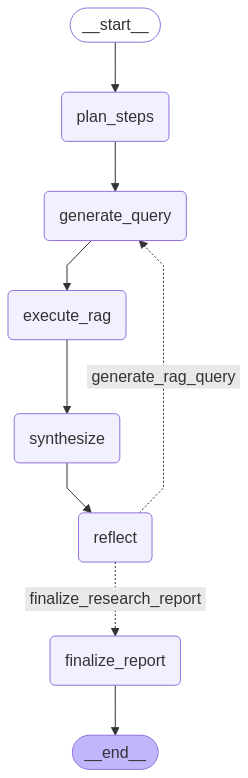

In [4]:
display(Image(research.get_graph().draw_mermaid_png()))

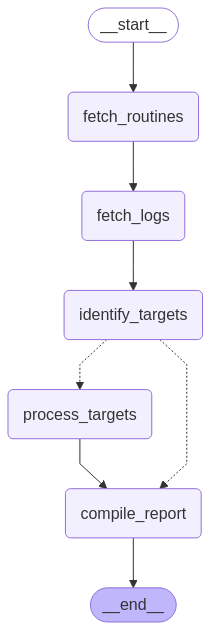

In [5]:
display(Image(progress.get_graph().draw_mermaid_png()))

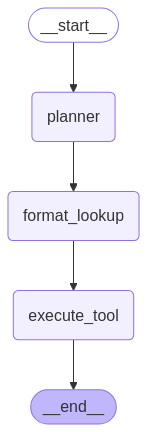

In [6]:
display(Image(routine.get_graph().draw_mermaid_png()))

2025-04-21 17:57:17 - fitness-chatbot.graph_builder - INFO - Building main fitness trainer graph... (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Building main fitness trainer graph...
2025-04-21 17:57:17 - fitness-chatbot.graph_builder - INFO - Building required subgraphs... (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Building required subgraphs...
2025-04-21 17:57:17 - fitness-chatbot.graph_builder - INFO - Building deep research subgraph... (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Building deep research subgraph...
2025-04-21 17:57:17 - fitness-chatbot.graph_builder - INFO - Deep research subgraph compiled successfully. (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Deep research subgraph compiled successfully.
2025-04-21 17:57:17 - fitness-chatbot.graph_builder - INFO - Building streamlined routine creation subgraph... (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Building streamlined routine creation subgraph...
2025-04-21 17:57:1

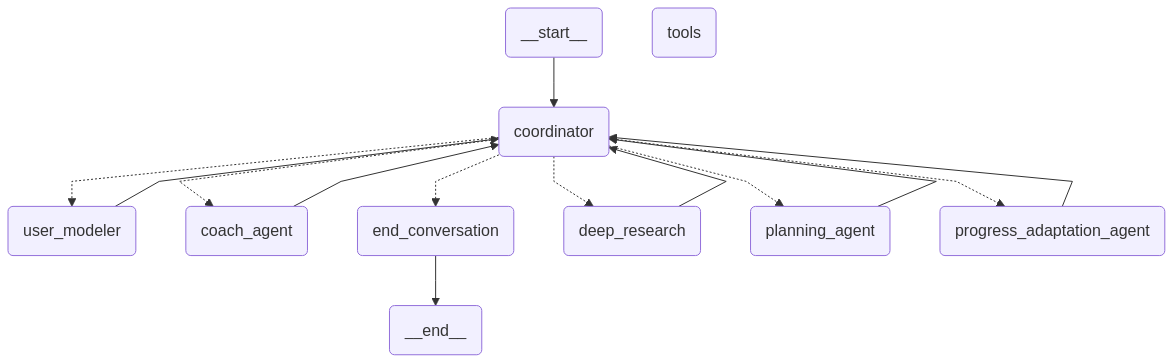

In [7]:
from langgraph.checkpoint.memory import MemorySaver
from agent.graph import build_fitness_trainer_graph
from IPython.display import Image, display
import traceback
from typing_extensions import TypedDict

memory_checkpointer = MemorySaver()

fitness_trainer_graph = build_fitness_trainer_graph(memory_checkpointer)


try:
    display(Image(fitness_trainer_graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Mermaid graph failed to render (you may be missing browser rendering dependencies).")

In [16]:
print(progress.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	fetch_routines(fetch_routines)
	fetch_logs(fetch_logs)
	identify_targets(identify_targets)
	process_targets(process_targets)
	compile_report(compile_report)
	__end__([<p>__end__</p>]):::last
	__start__ --> fetch_routines;
	compile_report --> __end__;
	fetch_logs --> identify_targets;
	fetch_routines --> fetch_logs;
	process_targets --> compile_report;
	identify_targets -.-> process_targets;
	identify_targets -.-> compile_report;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [1]:
# Install LangGraph with all optional extras (includes Postgres & visualizations)


from langgraph.checkpoint.memory import MemorySaver
from agent.graph import build_fitness_trainer_graph
from IPython.display import Image, display
import traceback

memory_checkpointer = MemorySaver()

fitness_trainer_graph = build_fitness_trainer_graph(memory_checkpointer)


try:
    display(Image(fitness_trainer_graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Mermaid graph failed to render (you may be missing browser rendering dependencies).")

2025-04-21 11:08:06 - fitness-chatbot.graph_builder - INFO - Building main fitness trainer graph... (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Building main fitness trainer graph...
2025-04-21 11:08:06 - fitness-chatbot.graph_builder - INFO - Building required subgraphs... (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Building required subgraphs...
2025-04-21 11:08:06 - fitness-chatbot.graph_builder - INFO - Building deep research subgraph... (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Building deep research subgraph...
2025-04-21 11:08:06 - fitness-chatbot.graph_builder - INFO - Deep research subgraph compiled successfully. (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Deep research subgraph compiled successfully.
2025-04-21 11:08:06 - fitness-chatbot.graph_builder - INFO - Building streamlined routine creation subgraph... (elk_logging.py:95)
INFO:fitness-chatbot.graph_builder:Building streamlined routine creation subgraph...
2025-04-21 11:08:0

⚠️ Mermaid visualization failed. You may need 'pyppeteer' and Chrome installed.


Traceback (most recent call last):
  File "/Users/pranavtandra/Desktop/PersonalTrainerAI/venv/lib/python3.9/site-packages/langchain_core/utils/pydantic.py", line 640, in create_model_v2
    return _create_model_cached(model_name, **field_definitions)
  File "/Users/pranavtandra/Desktop/PersonalTrainerAI/venv/lib/python3.9/site-packages/langchain_core/utils/pydantic.py", line 494, in _create_model_cached
    return _create_model_base(
  File "/Users/pranavtandra/Desktop/PersonalTrainerAI/venv/lib/python3.9/site-packages/pydantic/main.py", line 1678, in create_model
    return meta(
  File "/Users/pranavtandra/Desktop/PersonalTrainerAI/venv/lib/python3.9/site-packages/pydantic/_internal/_model_construction.py", line 224, in __new__
    complete_model_class(
  File "/Users/pranavtandra/Desktop/PersonalTrainerAI/venv/lib/python3.9/site-packages/pydantic/_internal/_model_construction.py", line 602, in complete_model_class
    schema = cls.__get_pydantic_core_schema__(cls, handler)
  File "/